# dataset

In [17]:
import pandas as pd

from pathlib import Path
from typing import List, Optional
import os

# Code from CodeSearchNetChallenge: https://github.com/github/CodeSearchNet/blob/master/notebooks/ExploreData.ipynb
def jsonl_list_to_dataframe(file_list, columns=['code', 'docstring']):


    """Load a list of jsonl.gz files into a pandas DataFrame."""
    df = pd.concat([pd.read_json(f,
                            orient='records',
                            lines=True)[columns]    # removed the .gz extension compression as my data is not compressed
                for f in file_list], sort=False)

    return df

def get_dfs(path: Path) -> List[pd.DataFrame]:
    """Grabs the different data splits and converts them into dataframes"""
    dfs = []
    for split in ["train", "val", "test"]:
        files = path/split
        f_list  = os.listdir(files)
        f_list = [files/f for f in f_list]   # changed the paths to include the files
        df = jsonl_list_to_dataframe(f_list).rename(columns = {'code': 'mthd', 'docstring': 'cmt'})
        dfs.append(df)

    return dfs

path = Path('.')
df_trn, df_val, df_tst = get_dfs(path/"./data/Java")
sample = 0.01
df_trn = df_trn.sample(frac = sample)
df_val = df_val.sample(frac = sample)
df_tst = df_tst.sample(frac = sample)

len(df_trn), len(df_val), len(df_tst)

(300, 153, 269)

In [18]:
df_trn.head()

mthd  \
3601   public Throwable unwrap() {\n\t\tThrowable cau...   
7336   public String wrap(String field){\r\n\t\tif(pr...   
10019  public static ShardingRouter newInstance(final...   
29998  public final Snapshot createSnapshot(\n      P...   
19457  private void readValues()\n            throws ...   

                                                     cmt  
3601   Recursively unwraps this WrappingRuntimeExcept...  
7336   包装字段名<br>\n有时字段与SQL的某些关键字冲突，导致SQL出错，因此需要将字段名用单...  
10019  Create new instance of sharding router.\n\n@pa...  
29998  Creates a snapshot from the requested subscrip...  
19457           This comes from the Apache Hive ORC code

# Cleaning

In [19]:
# collapse
# From https://stackoverflow.com/a/27084708/5768407
def is_ascii(s):
    '''
    Determines if the given string contains only ascii characters

    :param s: the string to check
    :returns: whether or not the given string contains only ascii characters
    '''
    try:
        s.encode(encoding='utf-8').decode('ascii')
    except UnicodeDecodeError:
        return False
    else:
        return True

df_trn = df_trn[df_trn['mthd'].apply(lambda x: is_ascii(x))]
df_val = df_val[df_val['mthd'].apply(lambda x: is_ascii(x))]
df_tst = df_tst[df_tst['mthd'].apply(lambda x: is_ascii(x))]

df_trn = df_trn[df_trn['cmt'].apply(lambda x: is_ascii(x))]
df_val = df_val[df_val['cmt'].apply(lambda x: is_ascii(x))]
df_tst = df_tst[df_tst['cmt'].apply(lambda x: is_ascii(x))]

len(df_trn), len(df_val), len(df_tst)

(244, 144, 264)

In [20]:
df_trn.head()

mthd  \
3601   public Throwable unwrap() {\n\t\tThrowable cau...   
10019  public static ShardingRouter newInstance(final...   
29998  public final Snapshot createSnapshot(\n      P...   
19457  private void readValues()\n            throws ...   
28980  public List<Entity> fetchEntitiesWithKeys(Stri...   

                                                     cmt  
3601   Recursively unwraps this WrappingRuntimeExcept...  
10019  Create new instance of sharding router.\n\n@pa...  
29998  Creates a snapshot from the requested subscrip...  
19457           This comes from the Apache Hive ORC code  
28980                    [VARIABLE "my_second_key_name"]

In [24]:
# skipped as the JAVA dataset is already in Language version 14


# import re

# from fast_trees.core import FastParser

# parser = FastParser('java')

# def get_cmt_params(cmt: str) -> List[str]:
#     '''
#     Grabs the parameter identifier names from a JavaDoc comment

#     :param cmt: the comment to extract the parameter identifier names from
#     :returns: an array of the parameter identifier names found in the given comment
#     '''
#     params = re.findall('@param+\s+\w+', cmt)
#     param_names = []
#     for param in params:
#         param_names.append(param.split()[1])

#     return param_names

# def is_outdated(mthd: str, cmt: str, parser: FastParser) -> bool:
#     '''
#     Determines if a given method and comment are outdated by checking
#     if the method's parameter identifier names match the comment's

#     :param mthd: the method to compare against its corresponding comment
#     :param cmt: the comment to compare against its corresponding method
#     :param parser: parser for easily getting the parameter identifier names from a given method
#     :returns: wheather or not a given comment is outdated compared to its corresponding method
#     '''
#     try:
#         mthd_params = parser.get_params(mthd)
#     except:
#         return False

#     cmt_params = get_cmt_params(cmt)

#     return mthd_params != cmt_params

# df_trn = df_trn[
#     ~df_trn.apply(
#         lambda x: is_outdated(x.mthd, x.cmt, parser), axis = 1
#     )
# ]
# df_val = df_val[
#     ~df_val.apply(
#         lambda x: is_outdated(x.mthd, x.cmt, parser), axis = 1
#     )
# ]
# df_tst = df_tst[
#     ~df_tst.apply(
#         lambda x: is_outdated(x.mthd, x.cmt, parser), axis = 1
#     )
# ]

# len(df_trn), len(df_val), len(df_tst)



In [25]:
## adding inline pairs


from tqdm.auto import tqdm

def get_inline_pairs(mthd):
    '''
    Get all pairs of inline comments and corresponding code snippets

    :param mthd: the method to retrieve the pairs of comments and corresponding
    code snippets from
    :returns: all pairs of comments and corresponding code snippets
    '''
    pairs = [[]]

    comment = False
    bracket = False
    indent_lvl = -1
    lines = mthd.split("\n")
    for line in lines:
        if "//" in line and not bracket and not "://" in line: # Ignore URLs and accept only inline comments
            pairs[-1].append(line)
            if '\t' in line:
                indent_lvl = line.count('\t')
            else:
                indent_lvl = line.split("//")[0].count(' ')
            comment = True
            bracket = False
        elif comment:
            if '{' in line and not bracket:
                bracket = True
                pairs[-1].append(line)
            elif '}' in line:
                line_indent = -1
                if '\t' in line:
                    line_indent = line.count('\t')
                else:
                    line_indent = line.split("//")[0].count(' ')
                if indent_lvl == line_indent:
                    pairs[-1].append(line)
                if not bracket:
                    pairs.append([])
                    comment = False
                    bracket = False
            elif line.isspace() or line == '' and not bracket:
                pairs.append([])
                comment = False
            else:
                pairs[-1].append(line)

    # Convert pairs into proper format of (code snippet, inline comment) dataframe
    code_snippets   = []
    comments        = []
    for pair in pairs:
        if pair and len(pair) < 5:
            code    = []
            comment = []
            skip = False
            for line in pair:
                if "TODO" in line: break
                if "//" in line:
                    comment.append(line.replace('//', ''))
                else:
                    code.append(line)
            if len(code) > 1 and len(comment) > 0:
                        code_snippets.append('\n'.join(code))
                        comments.append('\n'.join(comment))

    pairs = pd.DataFrame(zip(code_snippets, comments), columns = ["mthd", "cmt"])
    return pairs


def add_inline(df: pd.DataFrame) -> pd.DataFrame:
    '''
    Helper function to go through all methods in a given dataframe and add all
    pairs of inline comments and corresponding code snippets

    :param df: the dataframe to retrieve and add all pairs of inline comments
    and corresponding code snippets to
    :returns: a new dataframe with the newly added pairs of inline comments and
    corresponding code snippets
    '''
    new_df = df[df['mthd'].str.contains("//")]
    all_pairs = []
    for mthd in tqdm(new_df.mthd.values):
        pairs = get_inline_pairs(mthd)
        all_pairs.append(pairs)

    df_pairs = pd.concat([pairs for pairs in all_pairs])
    return pd.concat([df, df_pairs])

df_trn = add_inline(df_trn)
df_val = add_inline(df_val)
df_tst = add_inline(df_tst)

len(df_trn), len(df_val), len(df_tst)

/home/deadbytes/Documents/ML/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 98/98 [00:00<00:00, 2296.87it/s]


(256, 149, 279)

In [26]:
df_trn.head()

mthd  \
3601   public Throwable unwrap() {\n\t\tThrowable cau...   
10019  public static ShardingRouter newInstance(final...   
29998  public final Snapshot createSnapshot(\n      P...   
19457  private void readValues()\n            throws ...   
28980  public List<Entity> fetchEntitiesWithKeys(Stri...   

                                                     cmt  
3601   Recursively unwraps this WrappingRuntimeExcept...  
10019  Create new instance of sharding router.\n\n@pa...  
29998  Creates a snapshot from the requested subscrip...  
19457           This comes from the Apache Hive ORC code  
28980                    [VARIABLE "my_second_key_name"]

In [28]:
## Removing the examples where the code is smaller than the comment

df_trn = df_trn[df_trn.apply(lambda row: len(row.mthd) > len(row.cmt), axis = 1)]
df_val = df_val[df_val.apply(lambda row: len(row.mthd) > len(row.cmt), axis = 1)]
df_tst = df_tst[df_tst.apply(lambda row: len(row.mthd) > len(row.cmt), axis = 1)]

len(df_trn), len(df_val), len(df_tst)

(206, 115, 240)

In [31]:
def has_code(cmt: str) -> bool:
    '''
    Determinine if the given comment contains the HTML <code> tag

    :param cmt: the comment to check whether it contains the HTML <code> tag
    :returns: whether or not the given comment contains the HTML <code> tag
    '''
    if '<code>' in cmt: return True
    else: return False

df_trn = df_trn[~df_trn['cmt'].apply(lambda x: has_code(x))]
df_val = df_val[~df_val['cmt'].apply(lambda x: has_code(x))]
df_tst = df_tst[~df_tst['cmt'].apply(lambda x: has_code(x))]

len(df_trn), len(df_val), len(df_tst)

(204, 110, 226)

In [32]:
def remove_jdocs(df: pd.DataFrame) -> pd.DataFrame:
    '''
    Remove the JavaDocs leaving only the description of the comment

    :param df: the pandas dataframe to remove the JavaDocs from
    :returns: a new pandas dataframe with the JavaDocs removed
    '''
    methods = []
    comments = []
    for i, row in tqdm(list(df.iterrows())):
        comment = row["cmt"]
        # Remove {} text in comments from https://stackoverflow.com/questions/14596884/remove-text-between-and-in-python/14598135
        comment = re.sub("([\{\[]).*?([\)\}])", '', comment)


        cleaned = []
        for line in comment.split('\n'):
            if "@" in line: break
            cleaned.append(line)
        comments.append('\n'.join(cleaned))
        methods.append(row["mthd"])
    new_df = pd.DataFrame(zip(methods, comments), columns = ["mthd", "cmt"])

    return new_df

df_trn = remove_jdocs(df_trn);
df_val = remove_jdocs(df_val);
df_tst = remove_jdocs(df_tst);

<>:13: SyntaxWarning: invalid escape sequence '\{'
<>:13: SyntaxWarning: invalid escape sequence '\{'
/tmp/ipykernel_87009/638258387.py:13: SyntaxWarning: invalid escape sequence '\{'
  comment = re.sub("([\{\[]).*?([\)\}])", '', comment)
100%|██████████| 226/226 [00:00<00:00, 171598.97it/s]


In [34]:
def clean_html(cmt: str) -> str:
    '''
    Remove any HTML tags from a given comment

    :param cmt: the comment to remove any HTML tags from
    :returns: the comment with any HTML tags removed
    '''
    result = re.sub(r"<.?span[^>]*>|<.?code[^>]*>|<.?p[^>]*>|<.?hr[^>]*>|<.?h[1-3][^>]*>|<.?a[^>]*>|<.?b[^>]*>|<.?blockquote[^>]*>|<.?del[^>]*>|<.?dd[^>]*>|<.?dl[^>]*>|<.?dt[^>]*>|<.?em[^>]*>|<.?i[^>]*>|<.?img[^>]*>|<.?kbd[^>]*>|<.?li[^>]*>|<.?ol[^>]*>|<.?pre[^>]*>|<.?s[^>]*>|<.?sup[^>]*>|<.?sub[^>]*>|<.?strong[^>]*>|<.?strike[^>]*>|<.?ul[^>]*>|<.?br[^>]*>", "", cmt)
    return result

df_trn.cmt = df_trn.cmt.apply(clean_html)
df_val.cmt = df_val.cmt.apply(clean_html)
df_tst.cmt = df_tst.cmt.apply(clean_html)

len(df_trn), len(df_val), len(df_tst)

(204, 110, 226)

In [35]:
df_trn = df_trn.applymap(lambda x: ' '.join(x.split()).lower())
df_val = df_val.applymap(lambda x: ' '.join(x.split()).lower())
df_tst = df_tst.applymap(lambda x: ' '.join(x.split()).lower())

df_trn = df_trn[~(df_trn['cmt'] == '')]
df_val = df_val[~(df_val['cmt'] == '')]
df_tst = df_tst[~(df_tst['cmt'] == '')]

df_trn = df_trn[~df_trn['cmt'].duplicated()]
df_val = df_val[~df_val['cmt'].duplicated()]
df_tst = df_tst[~df_tst['cmt'].duplicated()]

len(df_trn), len(df_val), len(df_tst)

/tmp/ipykernel_87009/1607478491.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_trn = df_trn.applymap(lambda x: ' '.join(x.split()).lower())
/tmp/ipykernel_87009/1607478491.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_val = df_val.applymap(lambda x: ' '.join(x.split()).lower())
/tmp/ipykernel_87009/1607478491.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_tst = df_tst.applymap(lambda x: ' '.join(x.split()).lower())


(194, 100, 206)

In [36]:
df_trn.head()

mthd  \
0  public throwable unwrap() { throwable cause = ...   
1  public static shardingrouter newinstance(final...   
2  private void readvalues() throws ioexception {...   
3  public list<entity> fetchentitieswithkeys(stri...   
4  public static <t> t executegroovyscript(final ...   

                                                 cmt  
0  recursively unwraps this wrappingruntimeexcept...  
1            create new instance of sharding router.  
2           this comes from the apache hive orc code  
3                    [variable "my_second_key_name"]  
4              execute groovy script via run object.

In [37]:
# exploring data


import numpy as np

from collections import Counter
from statistics import mean, median, stdev
from transformers import AutoTokenizer

def get_counter(df: pd.DataFrame, tokenizer: AutoTokenizer, col: str) -> Counter:
    '''
    Get the counts for each token in a given pandas dataframe column

    :param df: the pandas dataframe to get the counts of tokens from
    :param tokenizer: the tokenizer to use for tokenizing the rows in the pandas
    dataframe
    :param col: the column to grab rows from when tokenizing
    :returns: the counts of each token in the given pandas dataframe
    column
    '''
    toks = []
    for i, row in df.iterrows():
        toks.extend(tokenizer.tokenize(row[col]))

    cnt = Counter()
    for tok in toks:
        cnt[tok] += 1
    return cnt

tokenizer = AutoTokenizer.from_pretrained('microsoft/codebert-base')
mthd_cnt = get_counter(df_trn, tokenizer, 'mthd')
cmt_cnt = get_counter(df_trn, tokenizer, 'cmt')
mthd_lens = df_trn.mthd.apply(lambda x: len(tokenizer.tokenize(x))).values
cmt_lens = df_trn.cmt.apply(lambda x: len(tokenizer.tokenize(x))).values
max_mthd_len = int(np.quantile(mthd_lens, 0.95))
max_cmt_len = int(np.quantile(cmt_lens, 0.95))

/home/deadbytes/Documents/ML/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Token indices sequence length is longer than the specified maximum sequence length for this model (1125 > 512). Running this sequence through the model will result in indexing errors


In [41]:
import matplotlib.pyplot as plt

def plot_counts(counts:Counter, top_k: Optional[int] = 30):
    '''
    Plot a bar chart of the most common tokens

    :param counts: the counts of each token
    :param top_k: the number of tokens to display in the plot
    '''
    labels, values = zip(*counts.most_common()[:top_k])

    indexes = np.arange(len(labels))
    width = 1
    plt.figure(num=None, figsize=(22, 4), dpi=60, facecolor='w', edgecolor='k')
    plt.bar(indexes, values, width)
    plt.xticks(indexes + width * 0.5, labels)
    plt.show()

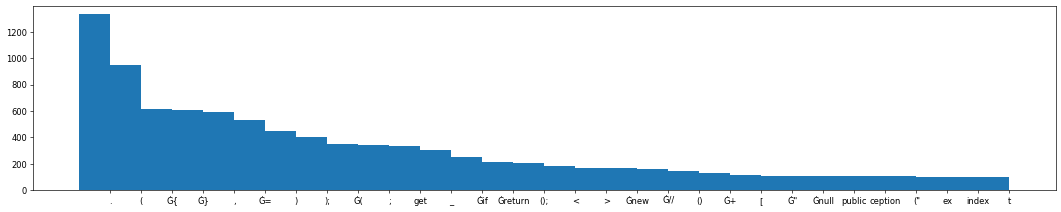

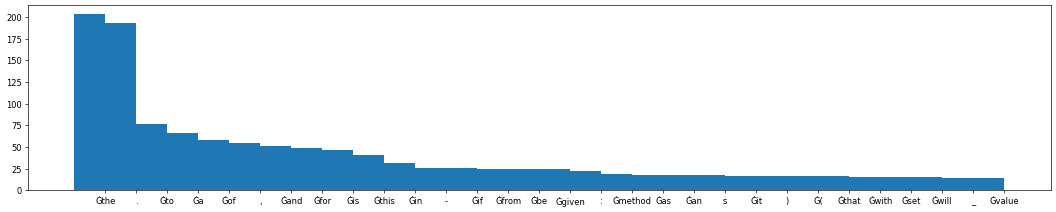

In [42]:
plot_counts(mthd_cnt, top_k = 30)
plot_counts(cmt_cnt, top_k = 30)

In [43]:
def plot_hist(lens: List[int], n_bins: Optional[int] = 50):
    '''
    Plot a histogram of the given number of tokens in a column

    :param lens: the number of tokens in a column
    :param n_bins: the number of bins to sort the number of tokens into
    '''
    n, bins, patches = plt.hist(lens, n_bins, facecolor='blue', alpha=0.9)
    plt.show()

146 96.0


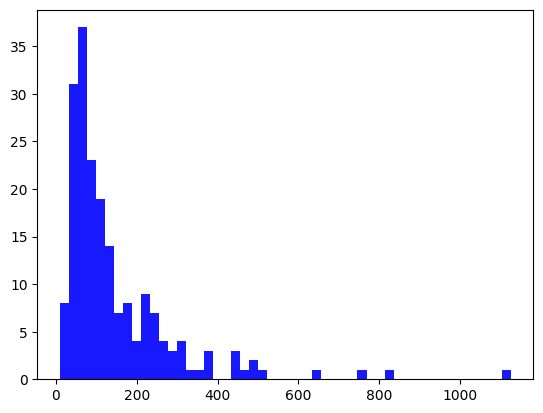

18 12.0


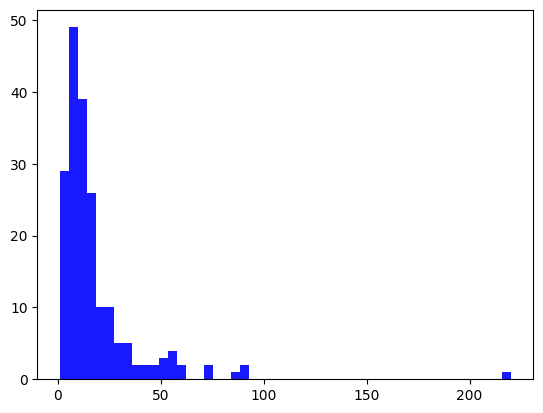

In [46]:
print(mean(mthd_lens), median(mthd_lens)) # removed starndard deviation as it was not used
plot_hist(mthd_lens)
print(mean(cmt_lens), median(cmt_lens)) # removed starndard deviation as it was not used
plot_hist(cmt_lens)

In [47]:
## taking only 95 percentile of the data

def filter_len(
    row: pd.Series, tokenizer: AutoTokenizer, mthd_len: int, cmt_len: int
    ) -> bool:
    '''
    Determine if a given panda dataframe row has a method or comment that has
    more tokens than max length

    :param row: the row to check if it has a method or comment that is too long
    :param tokenizer: the tokenizer to tokenize a method or comment
    :param mthd_len: the max number of tokens a method can have
    :param cmt_len: the max number of tokens a comment can have
    :returns: whether or not the given row have a method or comment that have
    more tokens than a max length
    '''
    return len(tokenizer.tokenize(row.mthd)) < mthd_len and len(tokenizer.tokenize(row.cmt)) < cmt_len

df_trn = df_trn[df_trn.apply(
    lambda row: filter_len(
        row, tokenizer, max_mthd_len,
        max_cmt_len
    ), axis = 1
)]
df_val = df_val[df_val.apply(
    lambda row: filter_len(
        row, tokenizer, max_mthd_len,
        max_cmt_len
    ), axis = 1
)]
df_tst = df_tst[df_tst.apply(
    lambda row: filter_len(
        row, tokenizer, max_mthd_len,
        max_cmt_len
    ), axis = 1
)]

len(df_trn), len(df_val), len(df_tst)

(172, 94, 183)

In [48]:
max_mthd_len, max_cmt_len

(437, 55)

In [59]:

import json

df_trn['code_tokens'] = df_trn.mthd.apply(lambda x: x.split())
df_trn['docstring_tokens'] = df_trn.cmt.apply(lambda x: x.split())
with open('./data/code/java/train.jsonl','w') as f:
    for _, row in df_trn.iterrows():
        f.write(json.dumps(row.to_dict()) + '\n')

df_val['code_tokens'] = df_val.mthd.apply(lambda x: x.split())
df_val['docstring_tokens'] = df_val.cmt.apply(lambda x: x.split())
with open('./data/code/java/valid.jsonl','w') as f:
    for _, row in df_val.iterrows():
        f.write(json.dumps(row.to_dict()) + '\n')

df_tst['code_tokens'] = df_tst.mthd.apply(lambda x: x.split())
df_tst['docstring_tokens'] = df_tst.cmt.apply(lambda x: x.split())
with open('./data/code/java/test.jsonl','w') as f:
    for _, row in df_tst.iterrows():
        f.write(json.dumps(row.to_dict()) + '\n')

In [62]:
lang = 'java' # programming language
lr = 5e-5
batch_size = 4 # change depending on the GPU Colab gives you
beam_size = 10
source_length = 256
target_length = max_cmt_len
data_dir = './data/code'
output_dir = f'model/{lang}'
train_file = f'{data_dir}/{lang}/train.jsonl'
dev_file = f'{data_dir}/{lang}/valid.jsonl'
epochs = 10
pretrained_model = 'microsoft/codebert-base'

In [63]:
! python code-to-text/code/run.py \
    --do_train \
    --do_eval \
    --do_lower_case \
    --model_type roberta \
    --model_name_or_path {pretrained_model} \
    --train_filename {train_file} \
    --dev_filename {dev_file} \
    --output_dir {output_dir} \
    --max_source_length {source_length} \
    --max_target_length {target_length} \
    --beam_size {beam_size} \
    --train_batch_size {batch_size} \
    --eval_batch_size {batch_size} \
    --learning_rate {lr} \
    --num_train_epochs {epochs}

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


09/08/2024 13:39:00 - INFO - __main__ -   Namespace(model_type='roberta', model_name_or_path='microsoft/codebert-base', output_dir='model/java', load_model_path=None, train_filename='./data/code/java/train.jsonl', dev_filename='./data/code/java/valid.jsonl', test_filename=None, config_name='', tokenizer_name='', max_source_length=256, max_target_length=55, do_train=True, do_eval=True, do_test=False, do_lower_case=True, no_cuda=False, train_batch_size=4, eval_batch_size=4, gradient_accumulation_steps=1, learning_rate=5e-05, beam_size=10, weight_decay=0.0, adam_epsilon=1e-08, max_grad_norm=1.0, num_train_epochs=10, max_steps=-1, eval_steps=-1, train_steps=-1, warmup_steps=0, local_rank=-1, seed=42)
09/08/2024 13:39:01 - WARNING - __main__ -   Process rank: -1, device: cuda, n_gpu: 1, distributed training: False
/home/deadbytes/Documents/ML/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set t

In [64]:
batch_size=64
dev_file=f"{data_dir}/{lang}/valid.jsonl"
test_file=f"{data_dir}/{lang}/test.jsonl"
test_model=f"{output_dir}/checkpoint-best-bleu/pytorch_model.bin" #checkpoint for test

! python code-to-text/code/run.py \
    --do_test \
    --model_type roberta \
    --model_name_or_path microsoft/codebert-base \
    --load_model_path {test_model} \
    --dev_filename {dev_file} \
    --test_filename {test_file} \
    --output_dir {output_dir} \
    --max_source_length {source_length} \
    --max_target_length {target_length} \
    --beam_size {beam_size} \
    --eval_batch_size {batch_size}

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


09/08/2024 14:07:37 - INFO - __main__ -   Namespace(model_type='roberta', model_name_or_path='microsoft/codebert-base', output_dir='model/java', load_model_path='model/java/checkpoint-best-bleu/pytorch_model.bin', train_filename=None, dev_filename='./data/code/java/valid.jsonl', test_filename='./data/code/java/test.jsonl', config_name='', tokenizer_name='', max_source_length=256, max_target_length=55, do_train=False, do_eval=False, do_test=True, do_lower_case=False, no_cuda=False, train_batch_size=8, eval_batch_size=64, gradient_accumulation_steps=1, learning_rate=5e-05, beam_size=10, weight_decay=0.0, adam_epsilon=1e-08, max_grad_norm=1.0, num_train_epochs=3, max_steps=-1, eval_steps=-1, train_steps=-1, warmup_steps=0, local_rank=-1, seed=42)
09/08/2024 14:07:37 - WARNING - __main__ -   Process rank: -1, device: cuda, n_gpu: 1, distributed training: False
/home/deadbytes/Documents/ML/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_to

In [80]:
import torch

import torch.nn as nn
from md import Seq2Seq
from transformers import RobertaConfig, RobertaModel

config = RobertaConfig.from_pretrained(pretrained_model)
encoder = RobertaModel.from_pretrained(pretrained_model, config = config)
decoder_layer = nn.TransformerDecoderLayer(d_model=config.hidden_size, nhead=config.num_attention_heads)
decoder = nn.TransformerDecoder(decoder_layer, num_layers=6)
model = Seq2Seq(encoder = encoder,decoder = decoder,config=config,
                beam_size=beam_size,max_length=target_length,
                sos_id=tokenizer.cls_token_id,eos_id=tokenizer.sep_token_id)
model.load_state_dict(torch.load(Path(output_dir)/"checkpoint-last/pytorch_model.bin"))
model.to('cuda')

/tmp/ipykernel_87009/843991713.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(Path(output_dir)/"checkpoint-last/pytorch_model.bin"))


Seq2Seq(
  (encoder): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((

RobertaEncoder(
  (layer): ModuleList(
    (0-11): 12 x RobertaLayer(
      (attention): RobertaAttention(
        (self): RobertaSelfAttention(
          (query): Linear(in_features=768, out_features=768, bias=True)
          (key): Linear(in_features=768, out_features=768, bias=True)
          (value): Linear(in_features=768, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (output): RobertaSelfOutput(
          (dense): Linear(in_features=768, out_features=768, bias=True)
          (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (intermediate): RobertaIntermediate(
        (dense): Linear(in_features=768, out_features=3072, bias=True)
        (intermediate_act_fn): GELUActivation()
      )
      (output): RobertaOutput(
        (dense): Linear(in_features=3072, out_features=768, bias=True)
        (LayerNorm): LayerNorm((768,), eps=1e-05, ele

In [99]:
model.encoder.embeddings

RobertaEmbeddings(
  (word_embeddings): Embedding(50265, 768, padding_idx=1)
  (position_embeddings): Embedding(514, 768, padding_idx=1)
  (token_type_embeddings): Embedding(1, 768)
  (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [81]:
idx = 0
TEXT_TO_SUMMARIZE = df_val.mthd.values[idx]
print('Code:', TEXT_TO_SUMMARIZE)
print('Original Comment:', df_val.cmt.values[idx])

Code: protected static localdatetime getaslocaldatetime(resultset rs, int index) throws sqlexception { timestamp timestamp = rs.gettimestamp(index); if (timestamp != null) { return timestamp.tolocaldatetime(); } return null; }
Original Comment: get the column value as localdatetime.


In [104]:
from run import convert_examples_to_features, Example # fixed imports
import matplotlib.pyplot as plt # added hook to plot activations

class Args:
    max_source_length = source_length
    max_target_length = target_length

args = Args()

# Dictionary to store activations
activations_encoder = {}
activations_decoder = {}

# Hook function to capture activations

def get_activation_encoder(name):
    def hook(module, input, output):
        if isinstance(output, tuple):
            output = output[0]  # Extract the first element of the tuple if it's a tuple
        activations_encoder[name] = output.detach()
    return hook

def get_activation_decoder(name):
    def hook(module, input, output):
        if isinstance(output, tuple):
            output = output[0]  # Extract the first element of the tuple if it's a tuple
        activations_decoder[name] = output.detach()
    return hook

# Register hooks on each layer of the model


for i, layer in enumerate(model.encoder.encoder.layer):
    layer.register_forward_hook(get_activation_encoder(f'layer_{i}'))

for i, layer in enumerate(model.decoder.layers):
    layer.register_forward_hook(get_activation_decoder(f'layer_{i}'))


def get_preds(df: pd.DataFrame):
    ps = []
    for idx, row in tqdm(df.iterrows(), total=len(df)):
        examples = [
            Example(idx, source = row.mthd, target = row.cmt)
        ]
        eval_features = convert_examples_to_features(
            examples, tokenizer, args, stage='test'
        )
        source_ids = torch.tensor(eval_features[0].source_ids, dtype = torch.long).unsqueeze(0).to('cuda')
        source_mask = torch.tensor(eval_features[0].source_mask, dtype = torch.long).unsqueeze(0).to('cuda')

        with torch.no_grad():
            preds = model(source_ids = source_ids, source_mask = source_mask)
            for pred in preds:
                t = pred[0].cpu().numpy()
                t = list(t)
                if 0 in t:
                    t = t[:t.index(0)]
                text = tokenizer.decode(t,clean_up_tokenization_spaces=False)
                ps.append(text)


    return ps

In [106]:
df_val = df_val
preds = get_preds(df_val.head(10))
for idx, row in df_val.head(10).iterrows():
    print('Code:', row.mthd)
    print('Original Comment:', row.cmt)
    print('Generated Comment:', preds[idx])
    print('='*40)

100%|██████████| 10/10 [00:05<00:00,  1.79it/s]

Code: protected static localdatetime getaslocaldatetime(resultset rs, int index) throws sqlexception { timestamp timestamp = rs.gettimestamp(index); if (timestamp != null) { return timestamp.tolocaldatetime(); } return null; }
Original Comment: get the column value as localdatetime.
Generated Comment: returns the given element.
Code: @override public void setstatementparameters(preparedstatement statement, boolean setdefaultid) throws sqlexception { int onebasedindex = 1; if (!setdefaultid) statement.setint(onebasedindex++, id); statement.setstring(onebasedindex++, pattern_id); statement.setstring(onebasedindex++, route_id); statement.setstring(onebasedindex++, name); // editor-specific fields setintparameter(statement, onebasedindex++, direction_id); // note: pattern#use_frequency is set in jdbcgtfssnapshotter here: // https://github.com/conveyal/gtfs-lib/blob/0c6aca98a83d534853b74011e6cc7bf376592581/src/main/java/com/conveyal/gtfs/loader/jdbcgtfssnapshotter.java#l196-l211 setintparam

In [109]:
!pip install seaborn

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)


In [110]:
import seaborn as sns

In [154]:
layer_activations_encoder = []
layer_activations_decoder = []

# Aggregate activations across all layers
for layer_name, activation in activations_encoder.items():
    # Sum activations across all neurons in the layer
    total_activation = activation.sum().item()
    layer_activations_encoder.append(total_activation)

for layer_name, activation in activations_decoder.items():
    # Sum activations across all neurons in the layer
    total_activation = activation.sum().item()
    layer_activations_decoder.append(total_activation)

# Plot the total activations for each layer


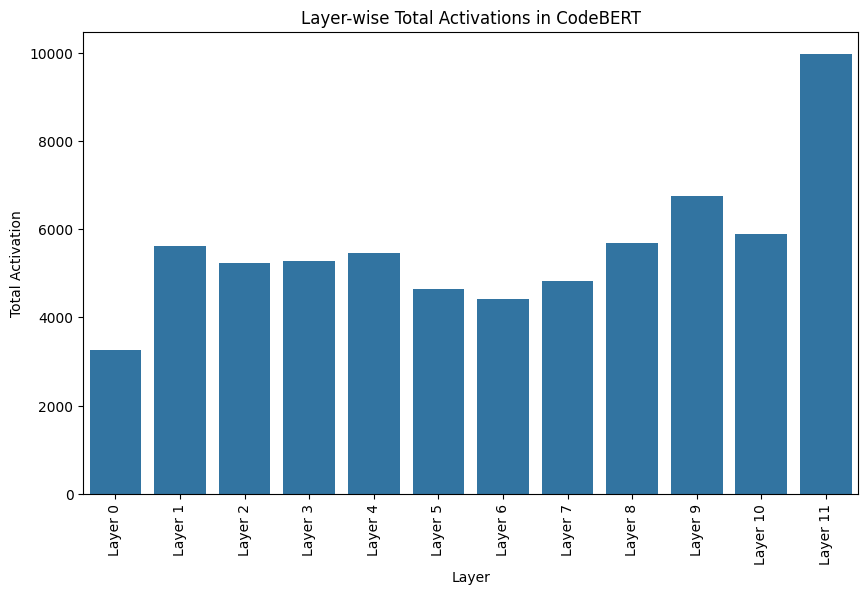

In [117]:
plt.figure(figsize=(10, 6))
sns.barplot(x=[f'Layer {i}' for i in range(len(layer_activations_encoder))], y=layer_activations_encoder)
plt.xlabel('Layer')
plt.ylabel('Total Activation')
plt.title('Layer-wise Total Activations in CodeBERT')
plt.xticks(rotation=90)
plt.show()

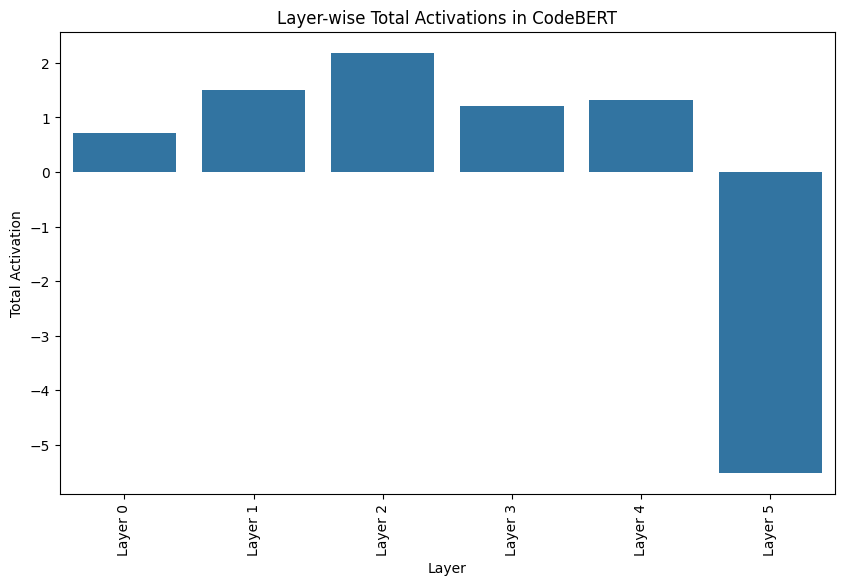

In [155]:
plt.figure(figsize=(10, 6))
sns.barplot(x=[f'Layer {i}' for i in range(len(layer_activations_decoder))], y=layer_activations_decoder)
plt.xlabel('Layer')
plt.ylabel('Total Activation')
plt.title('Layer-wise Total Activations in CodeBERT')
plt.xticks(rotation=90)
plt.show()

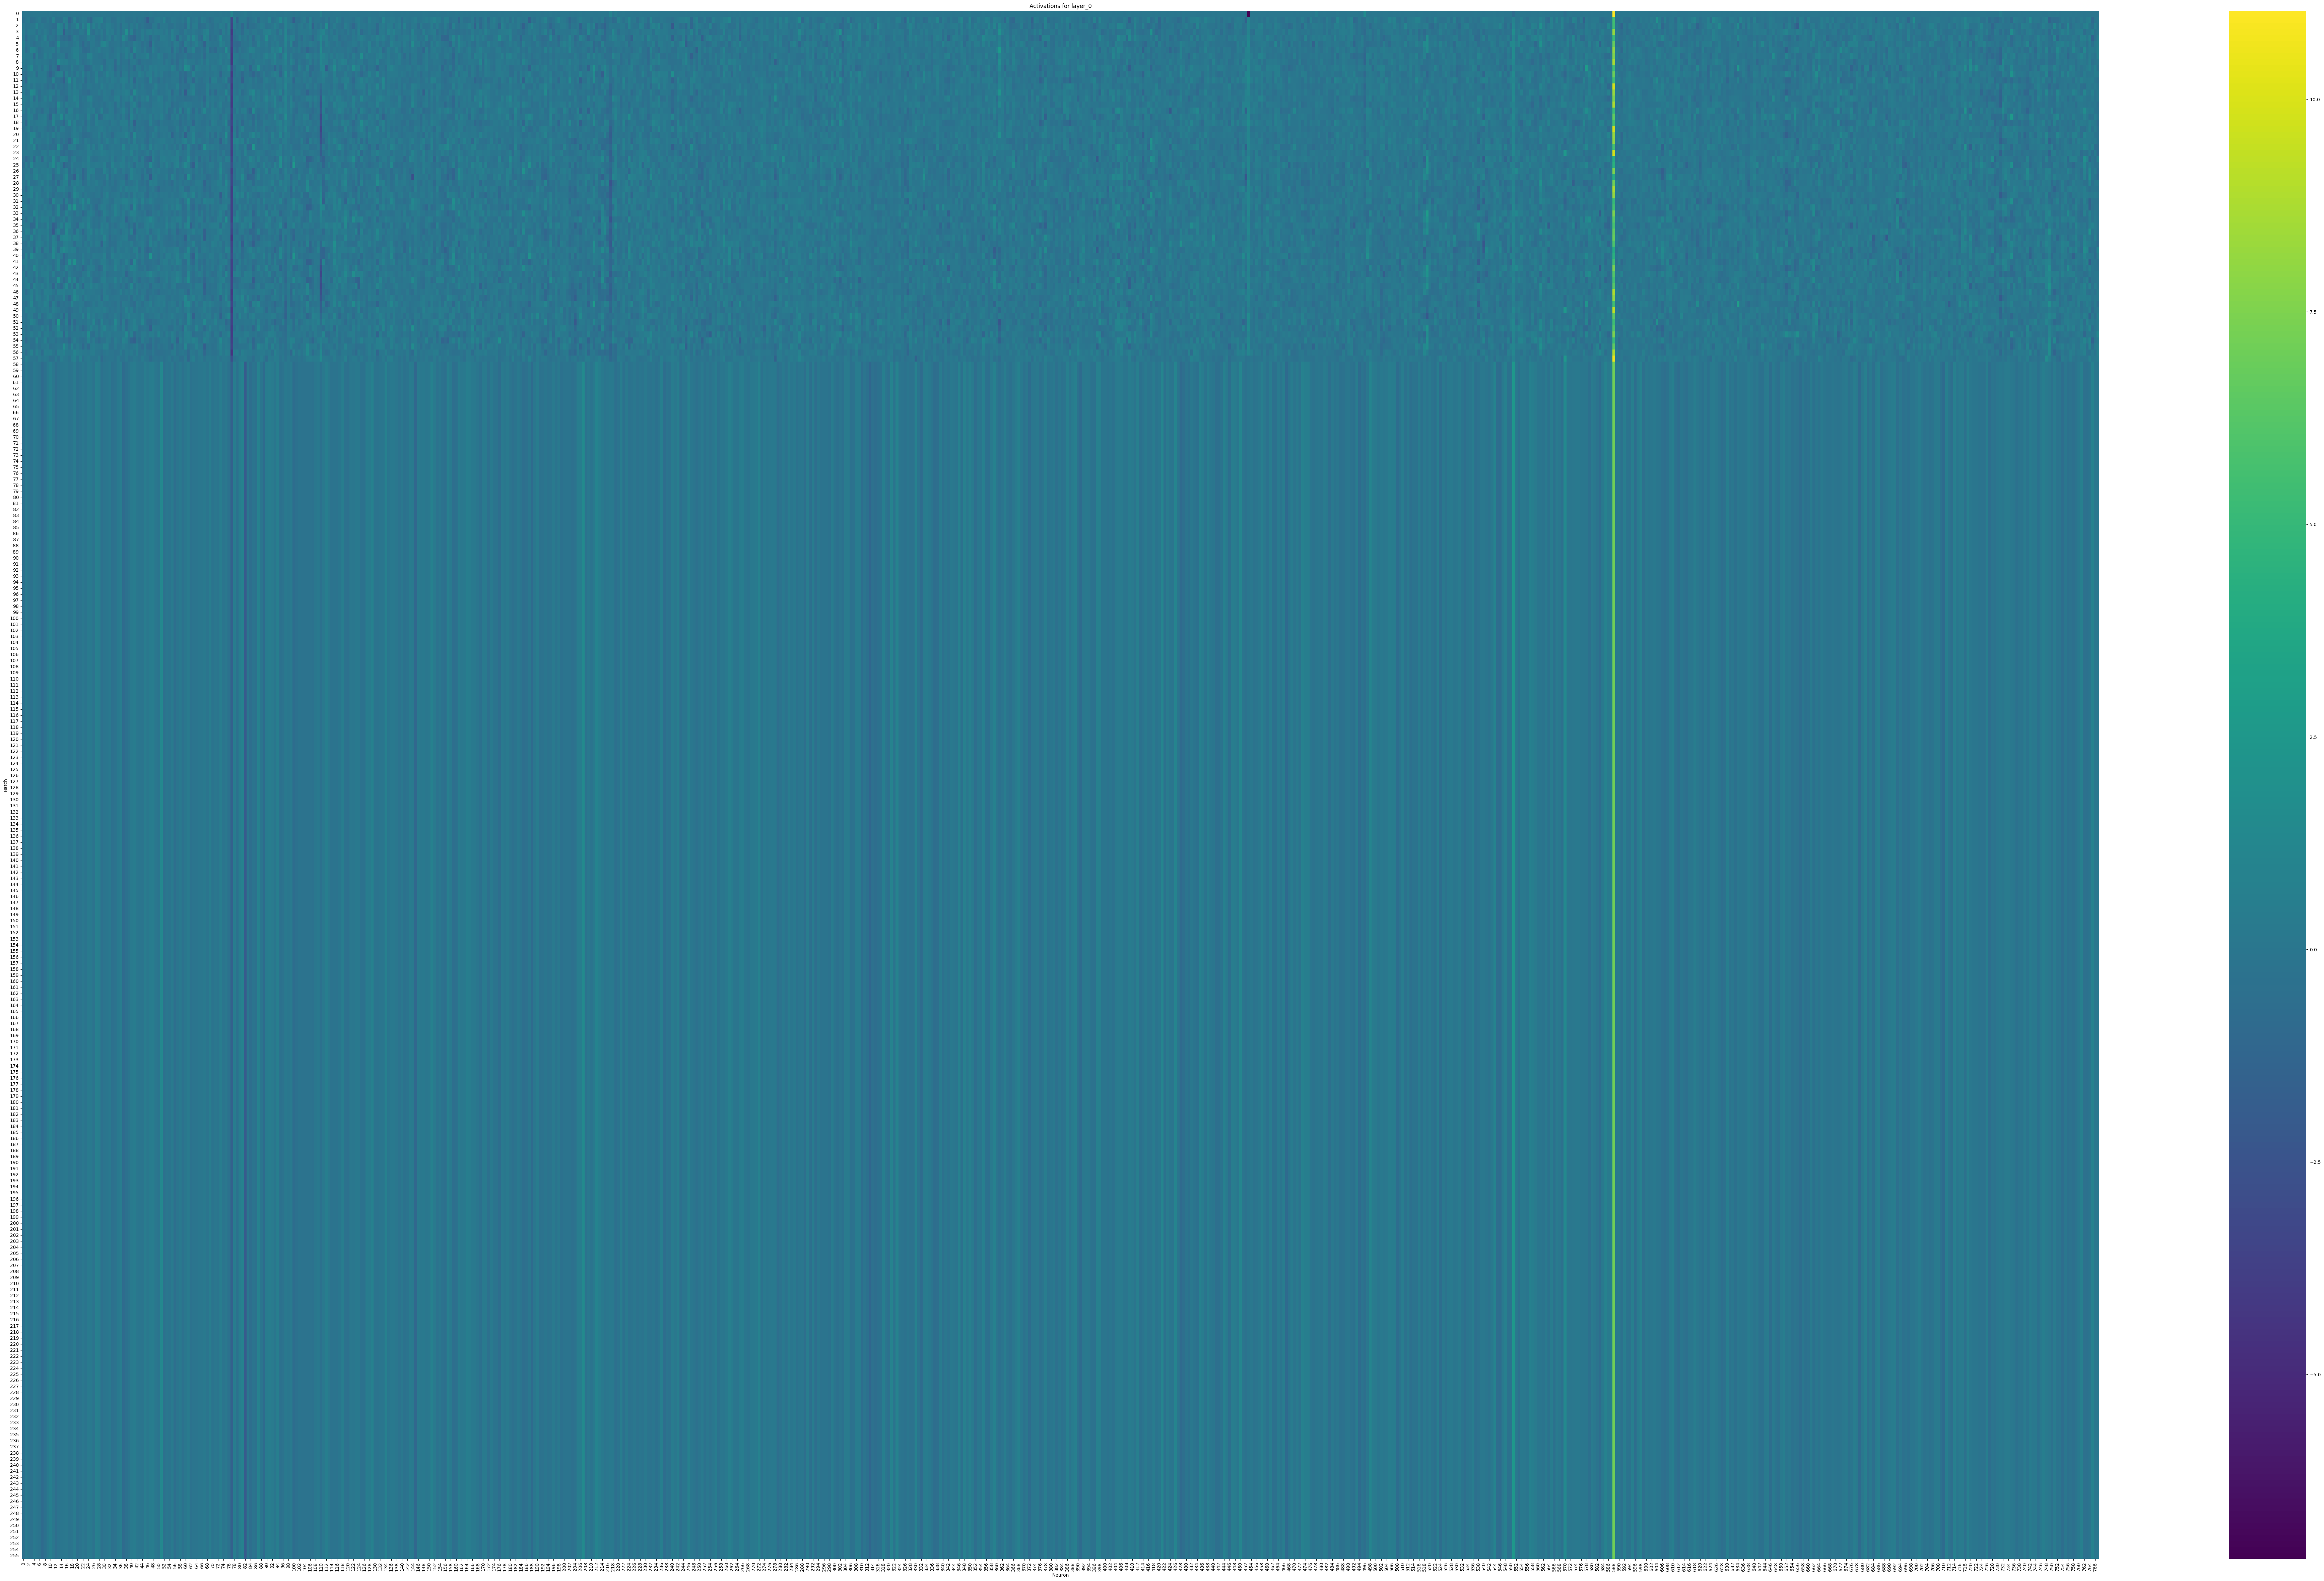

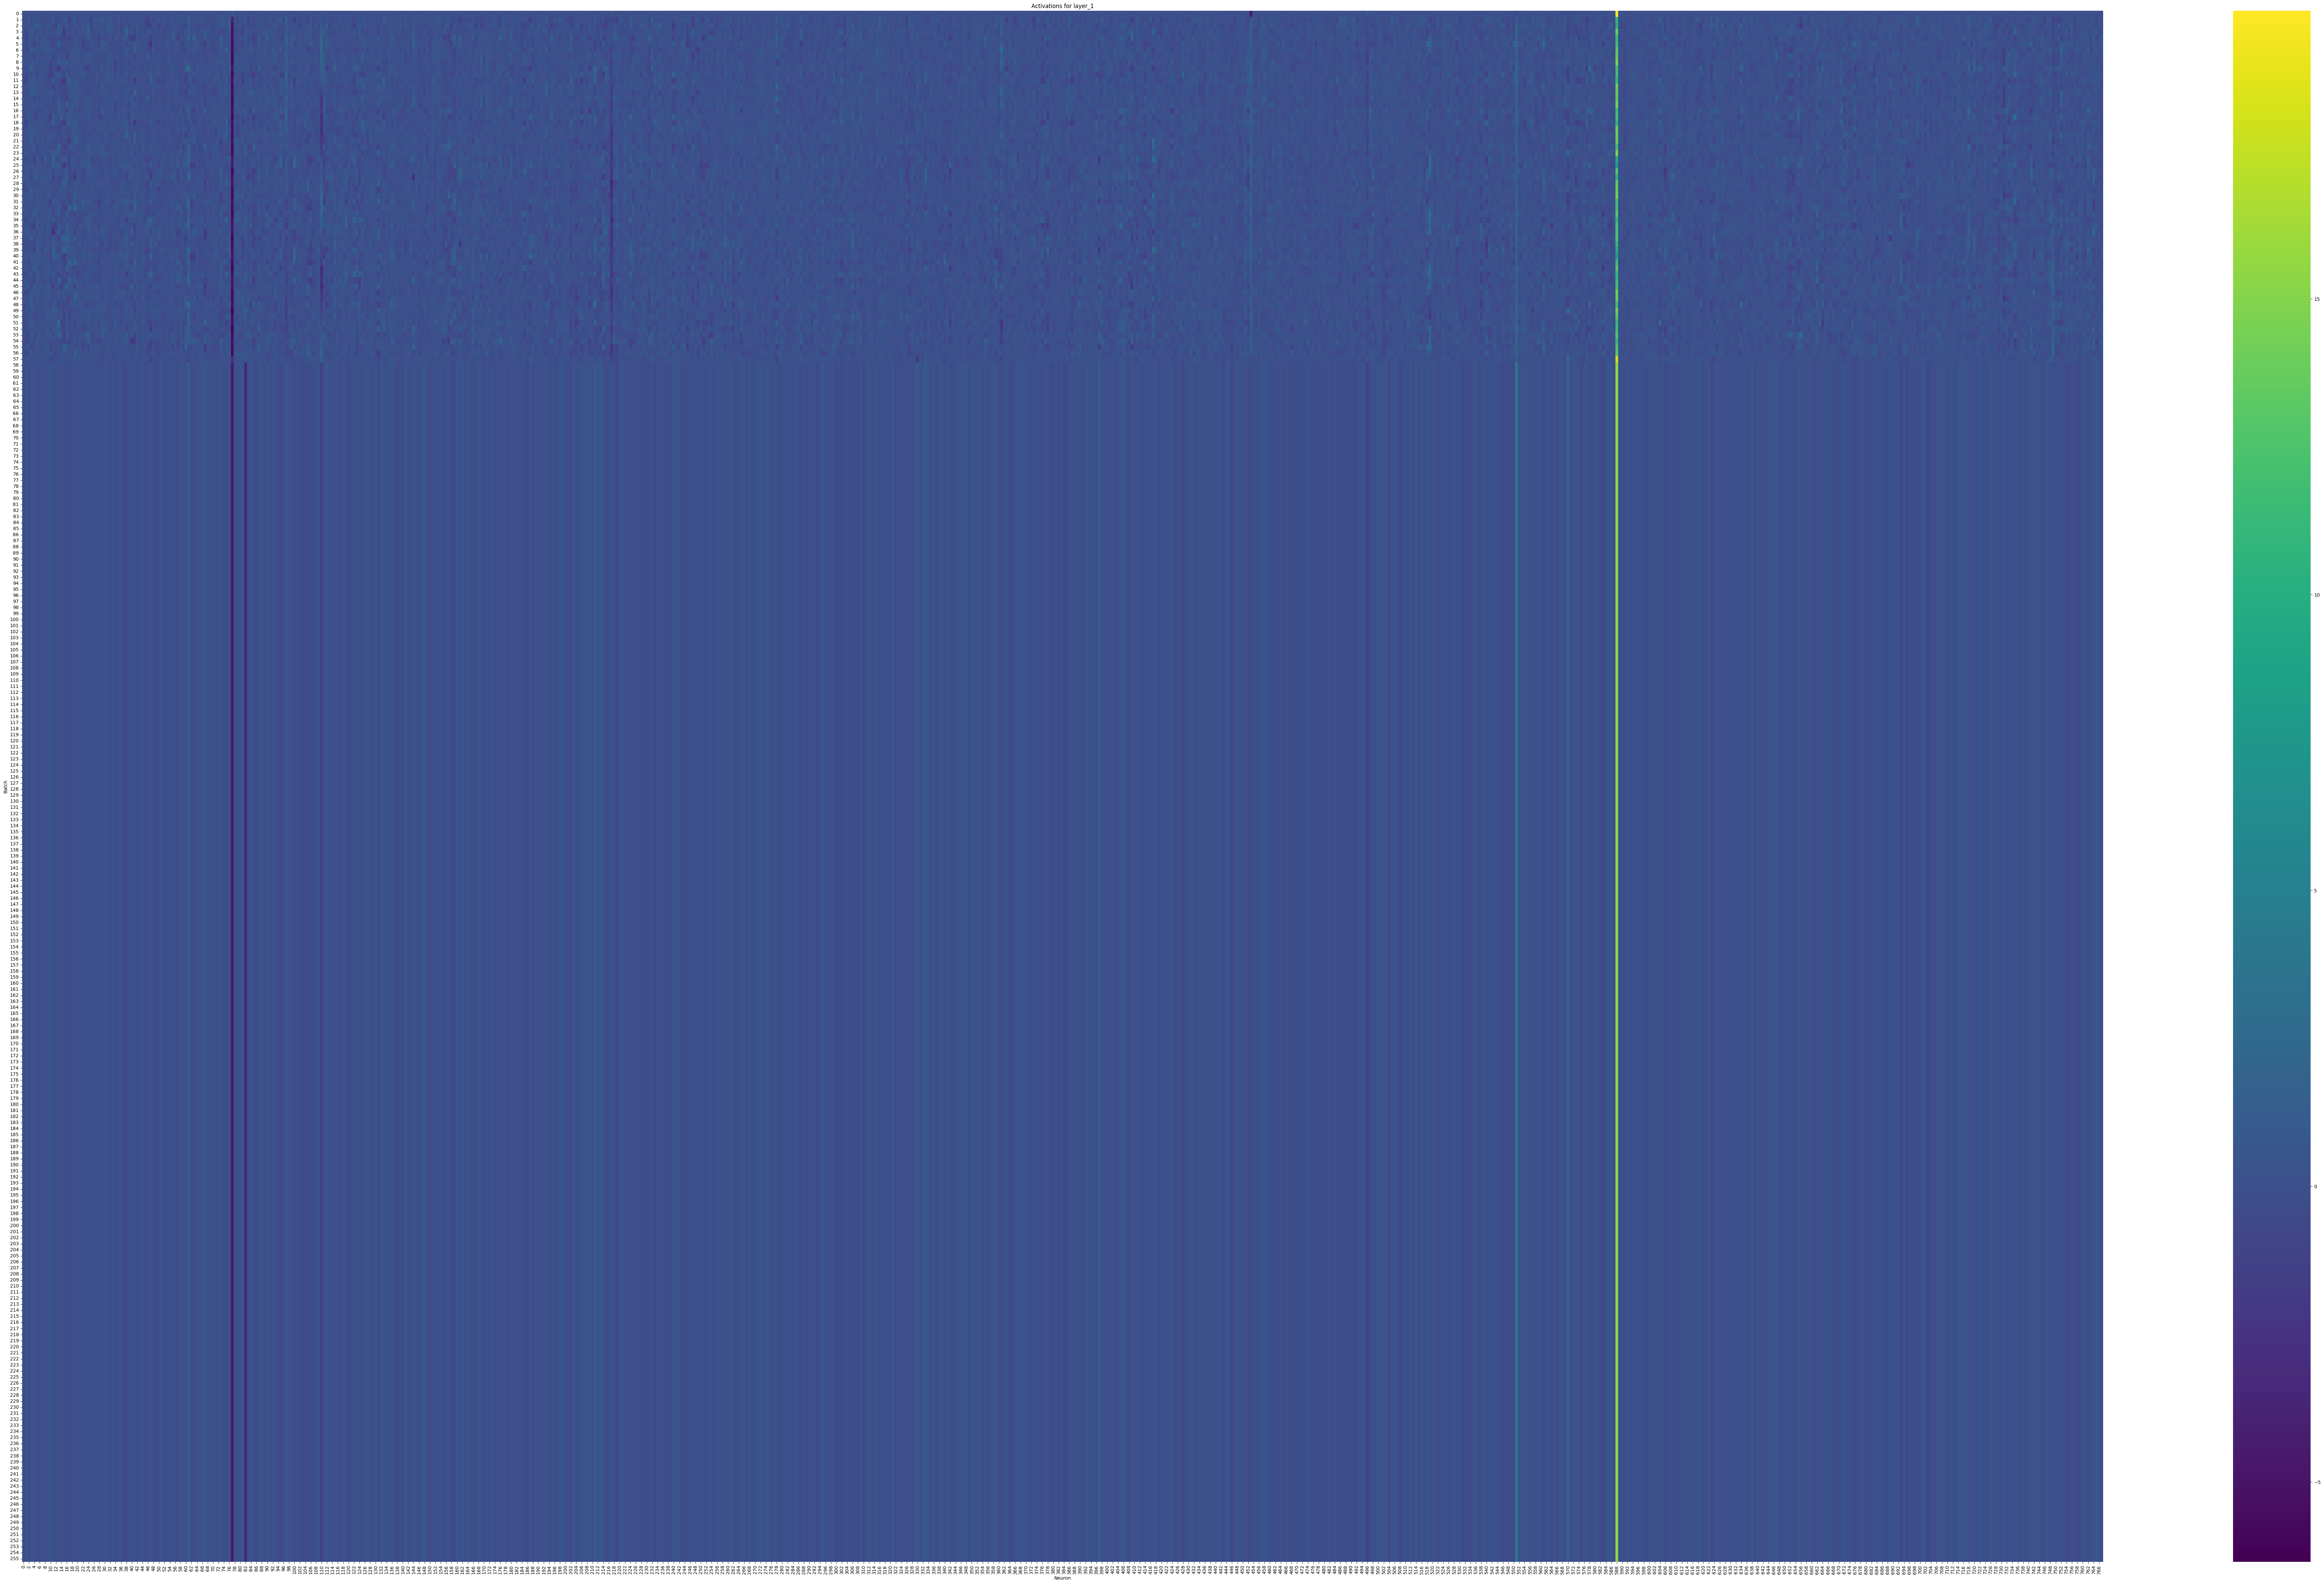

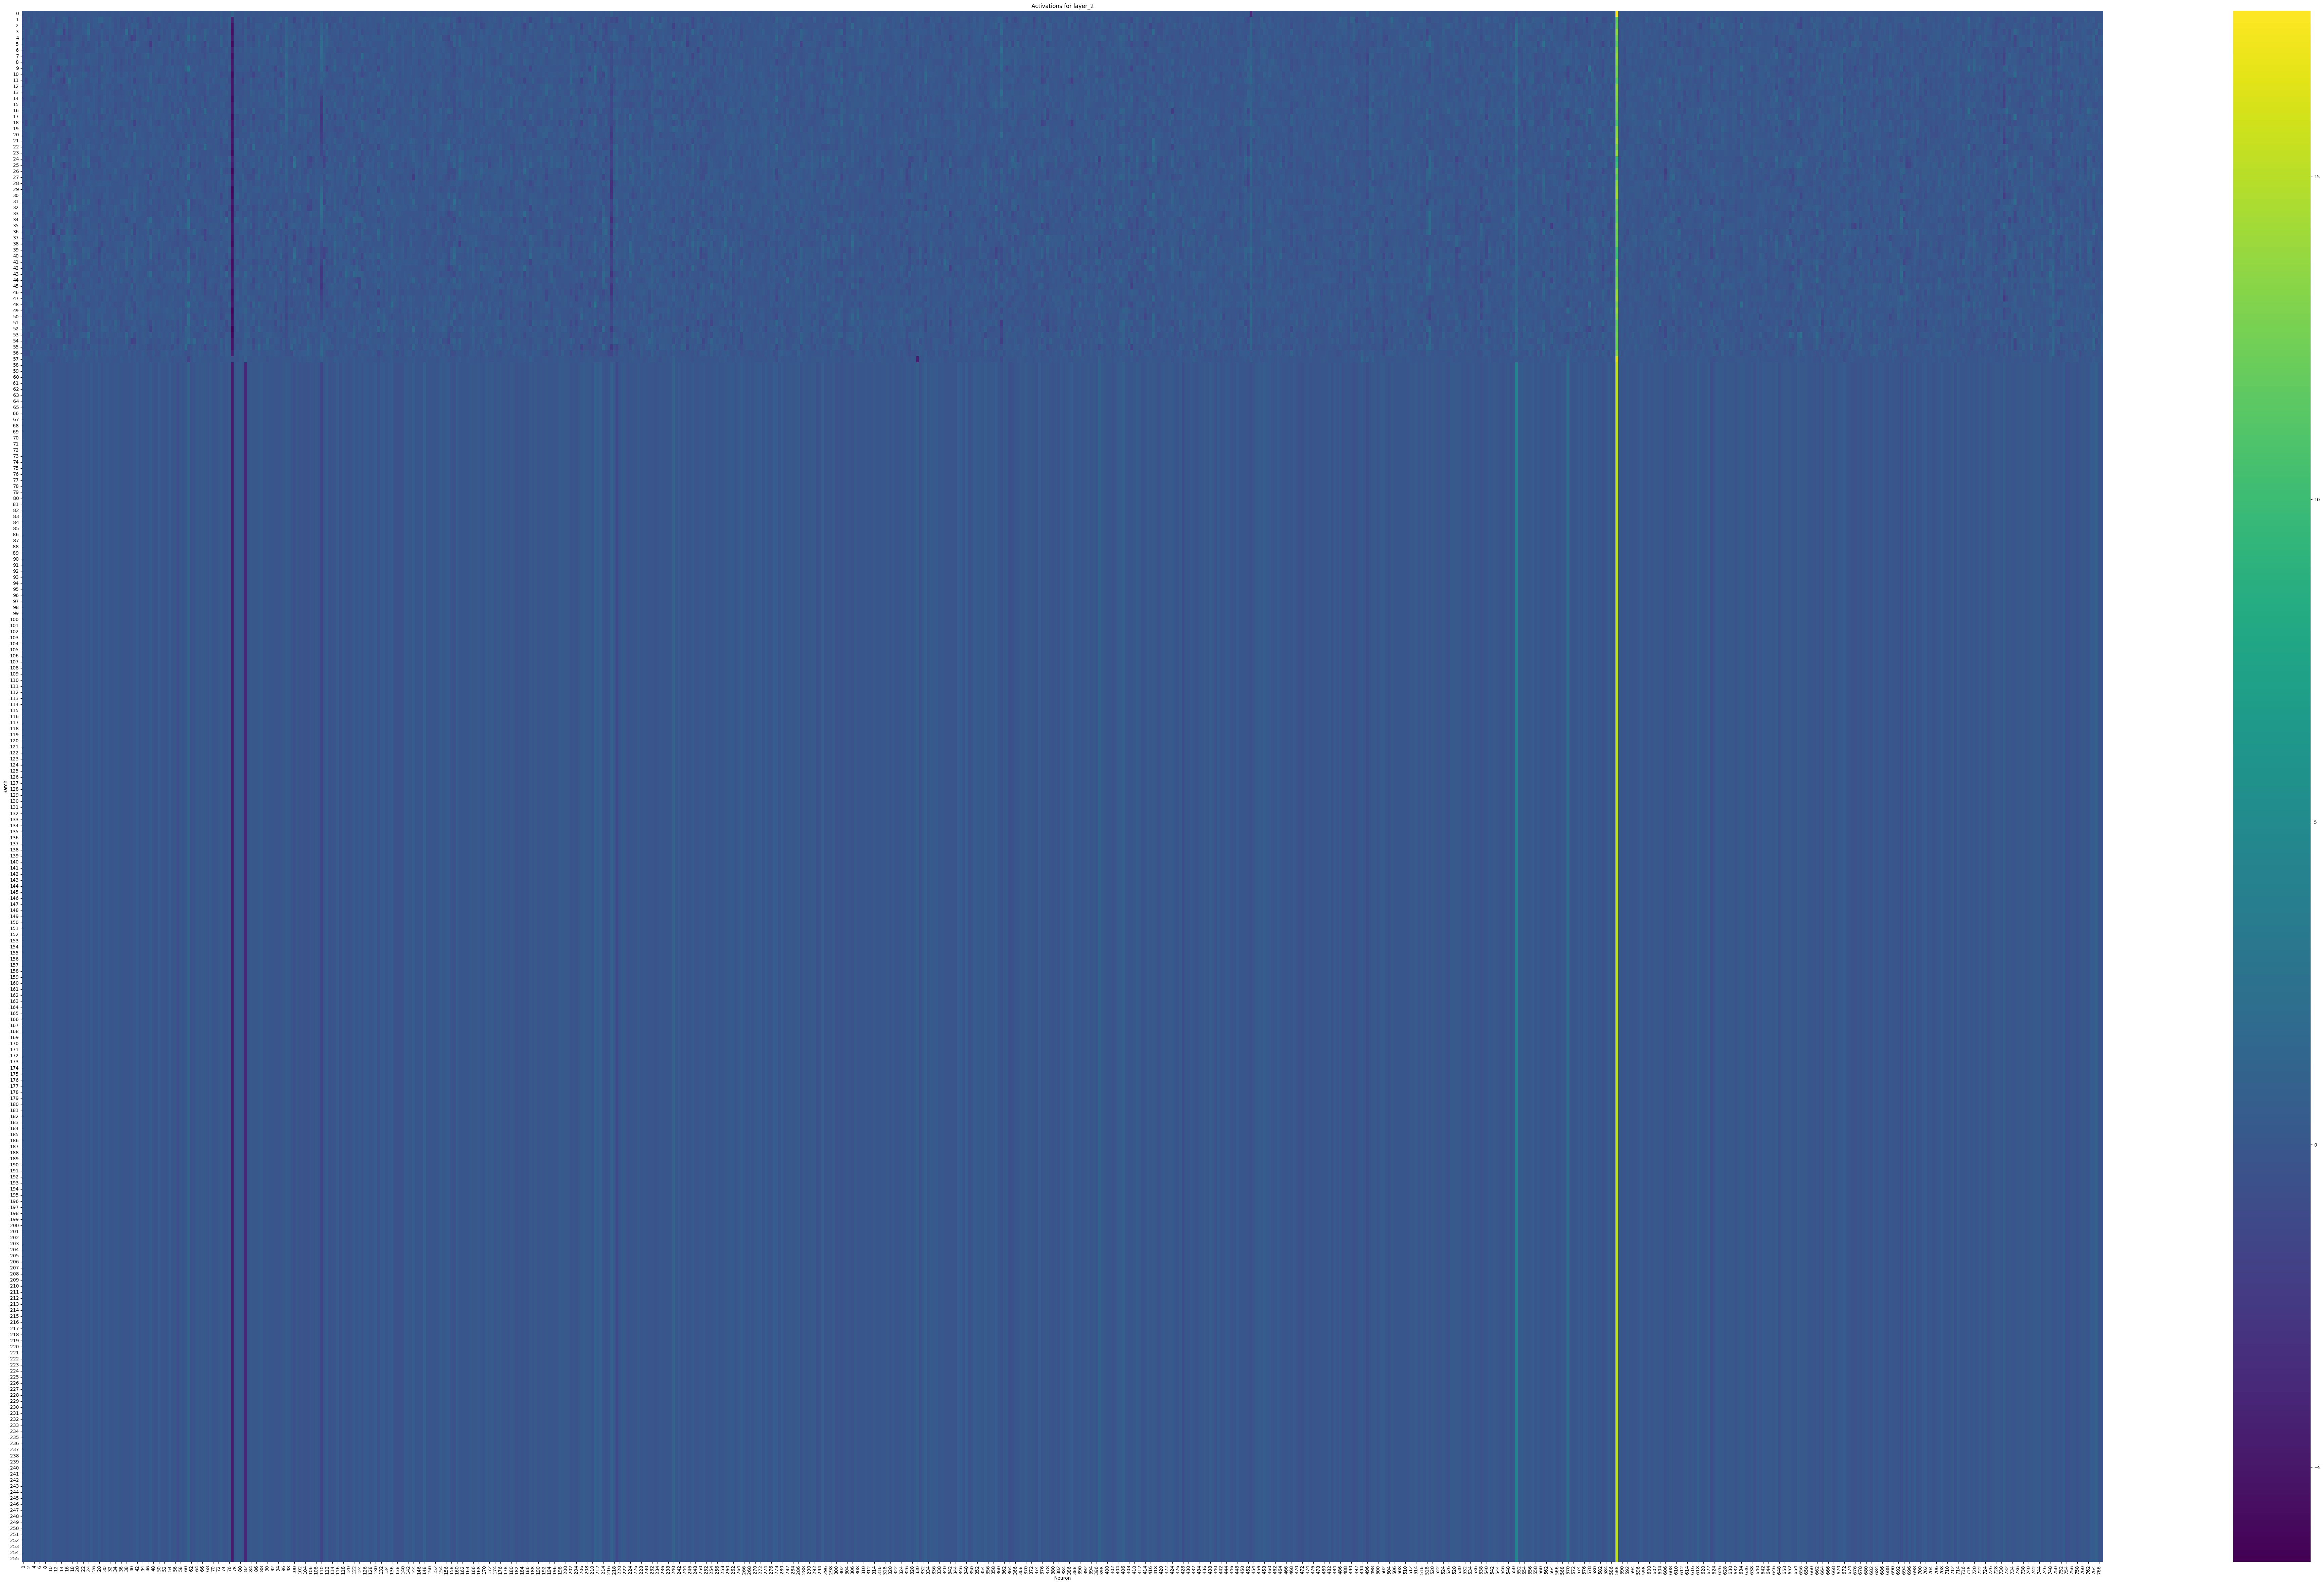

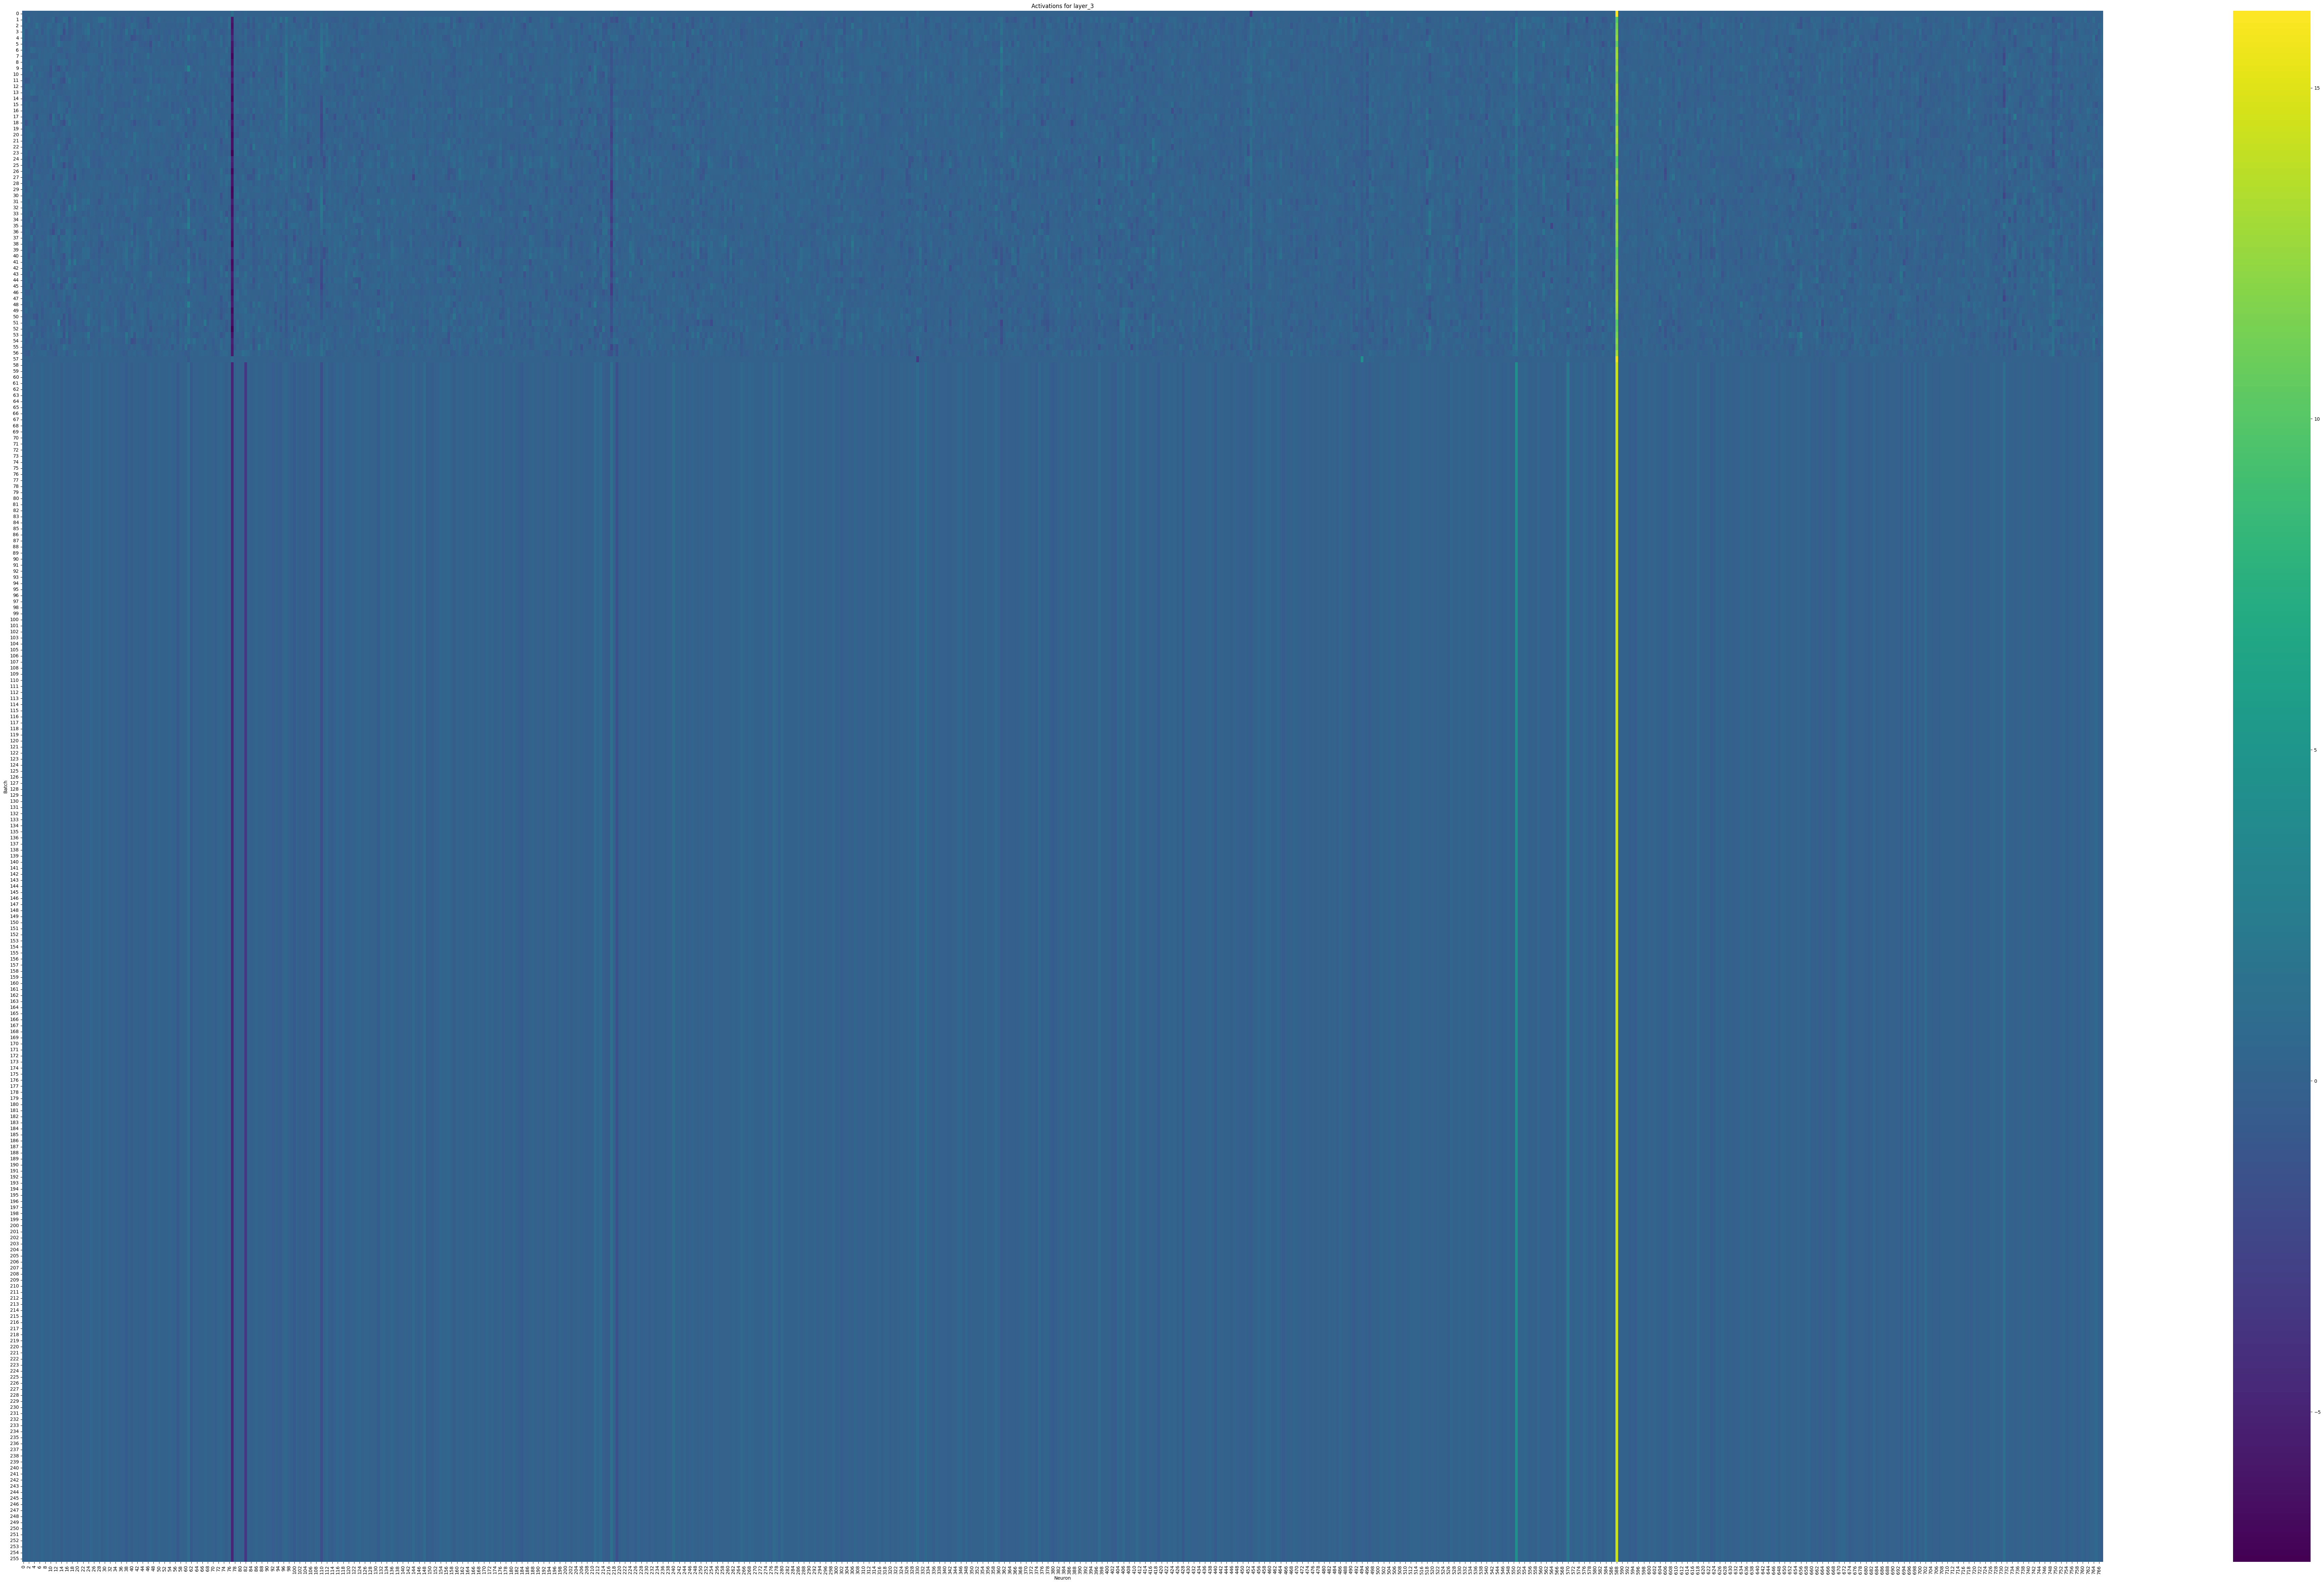

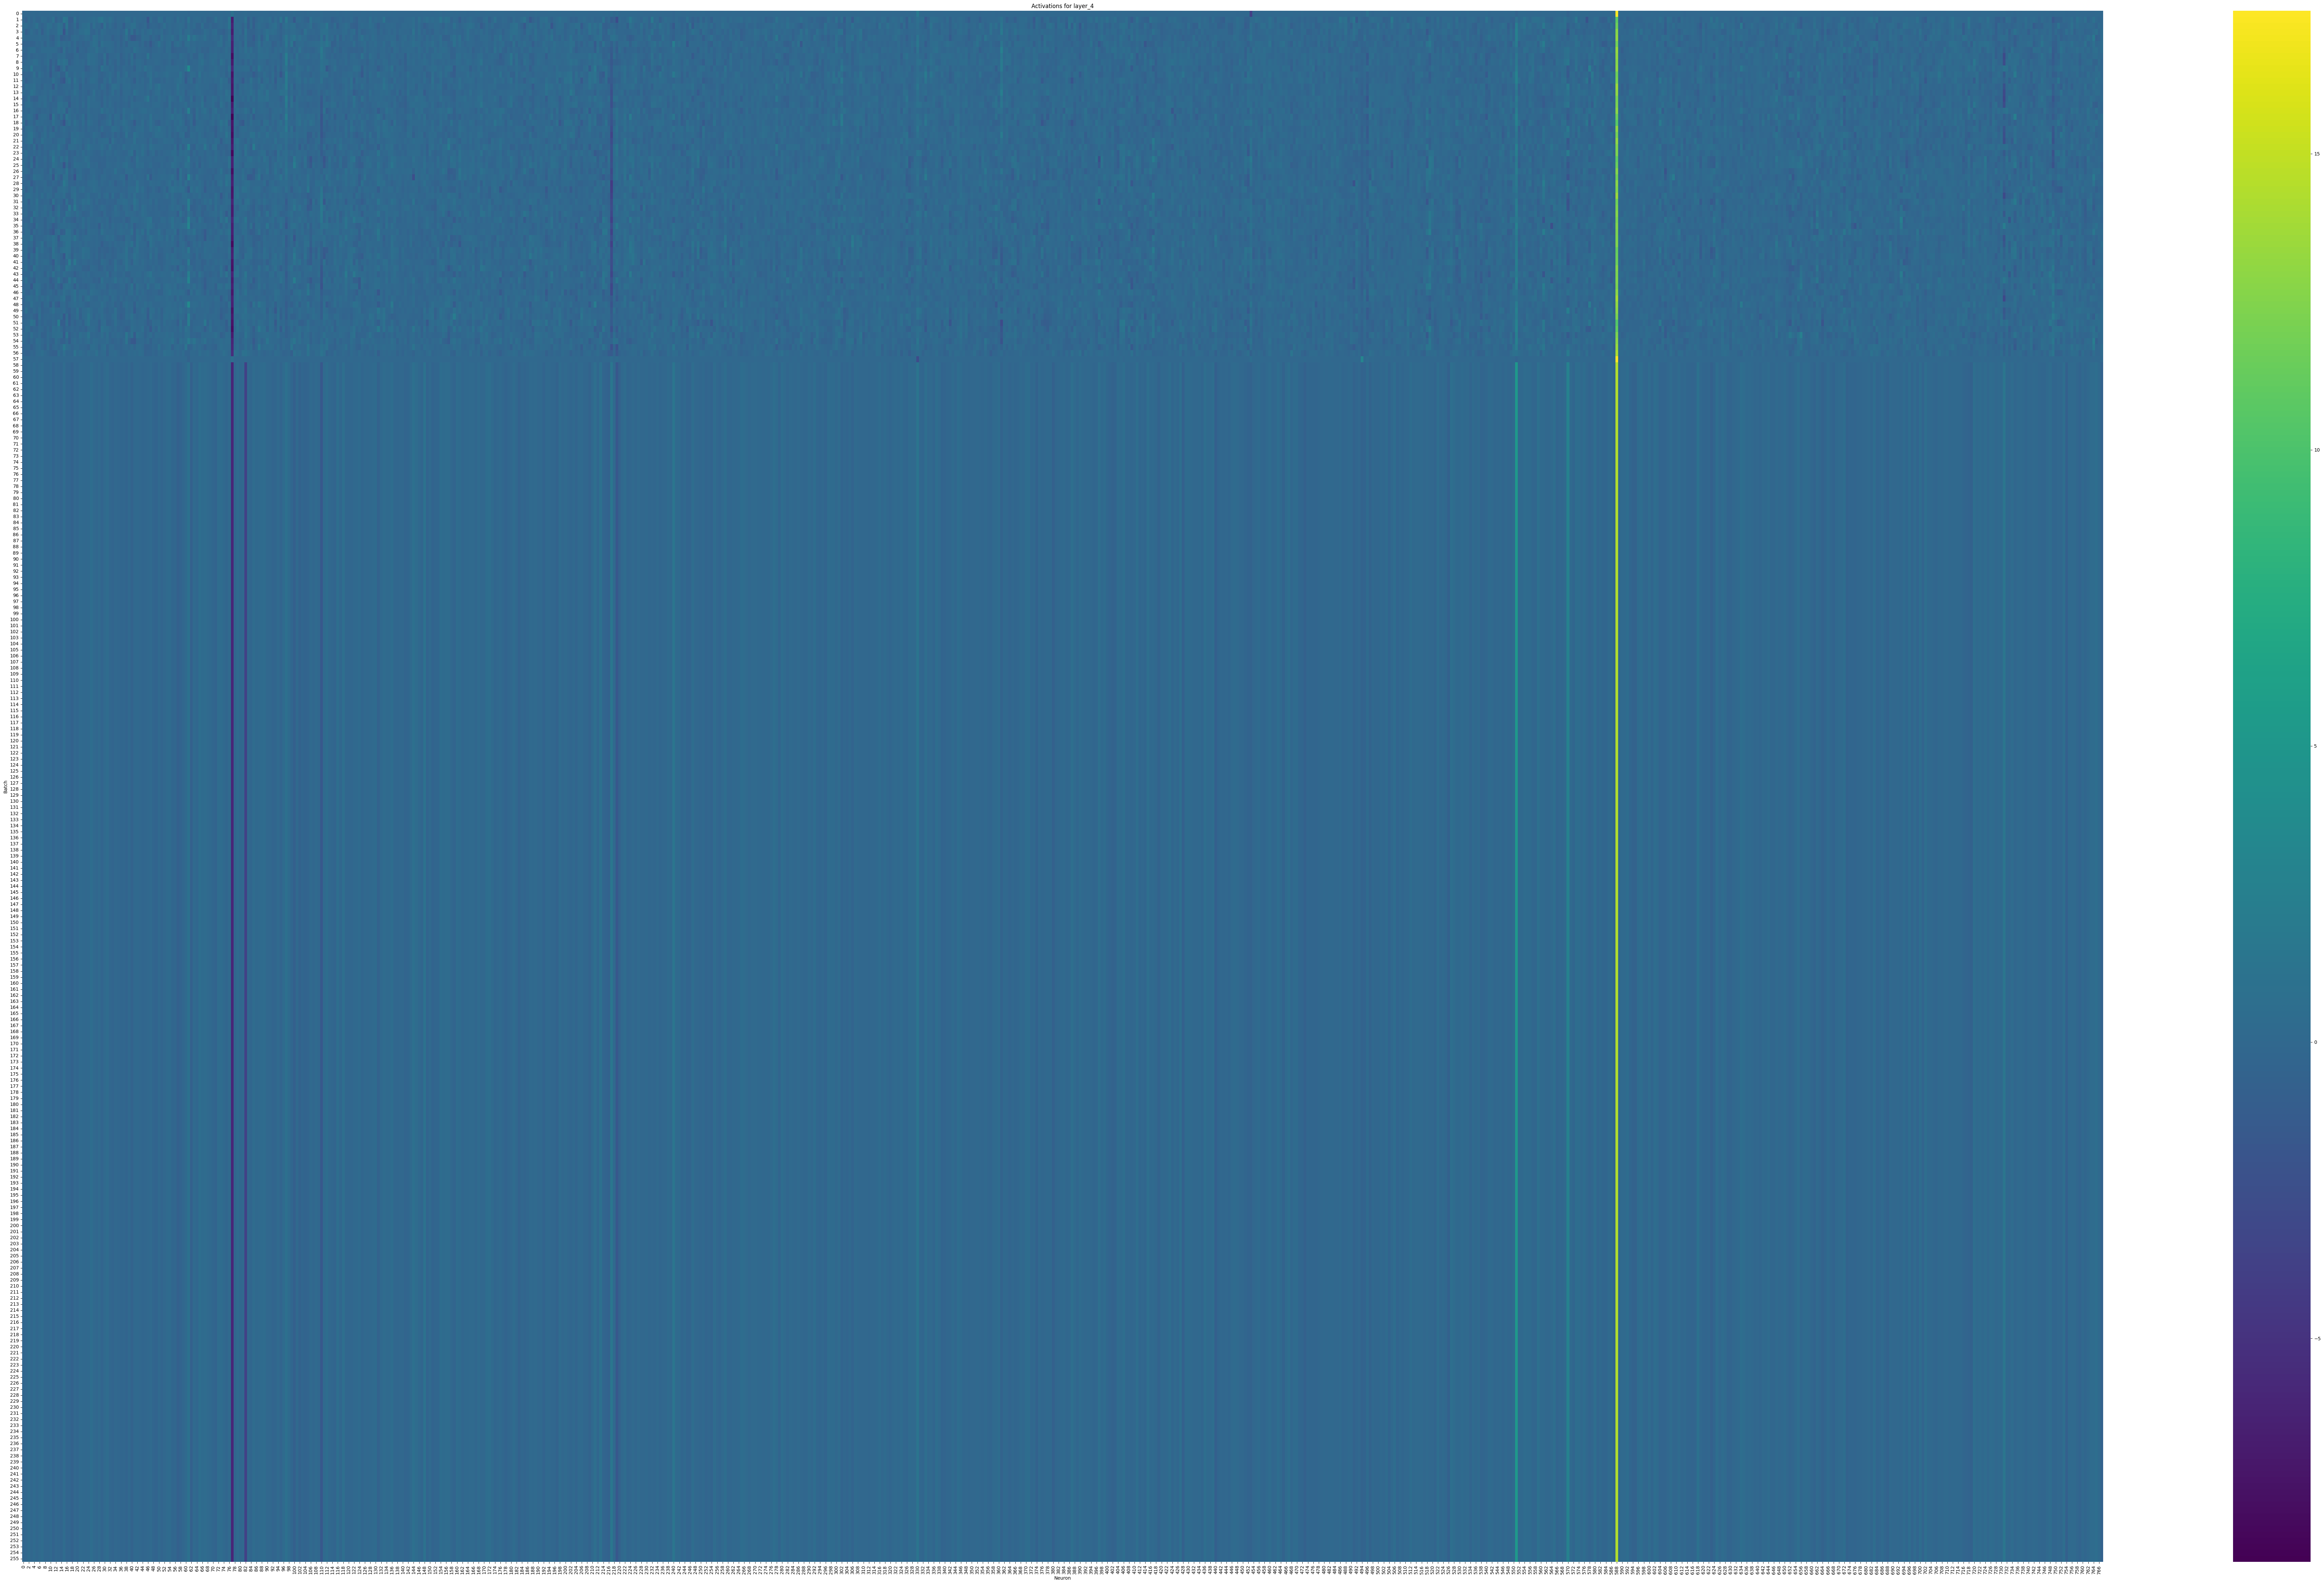

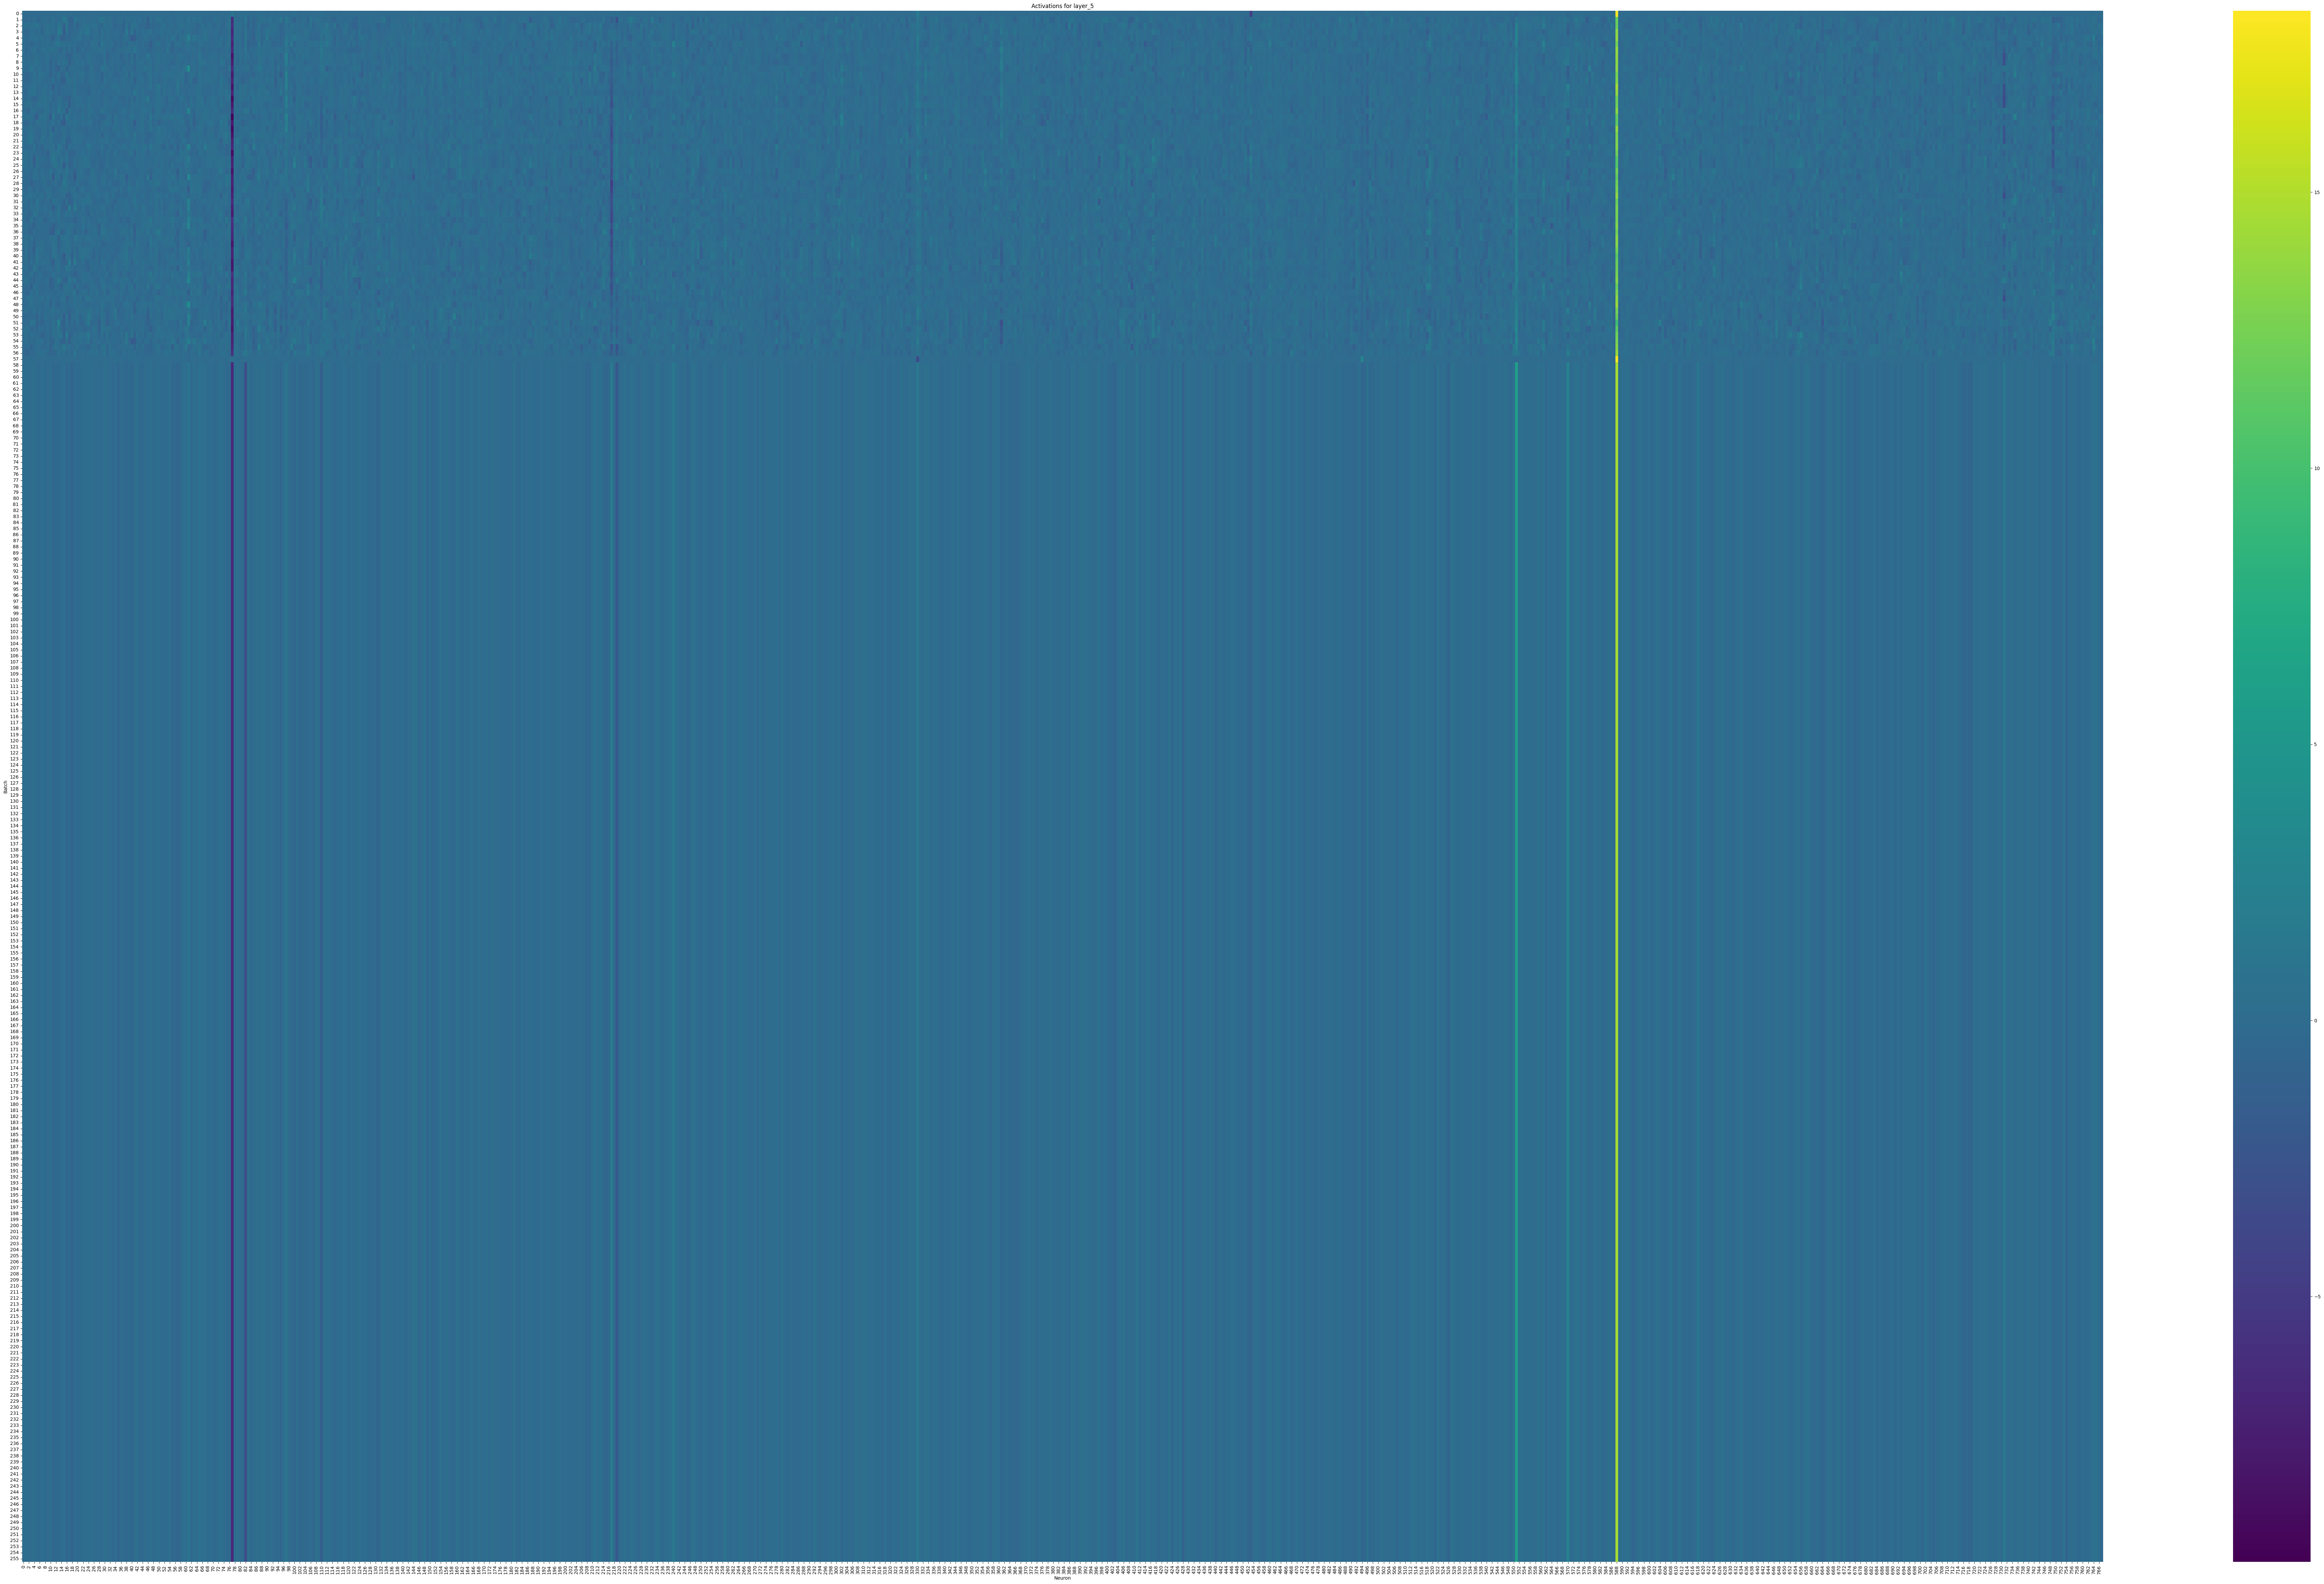

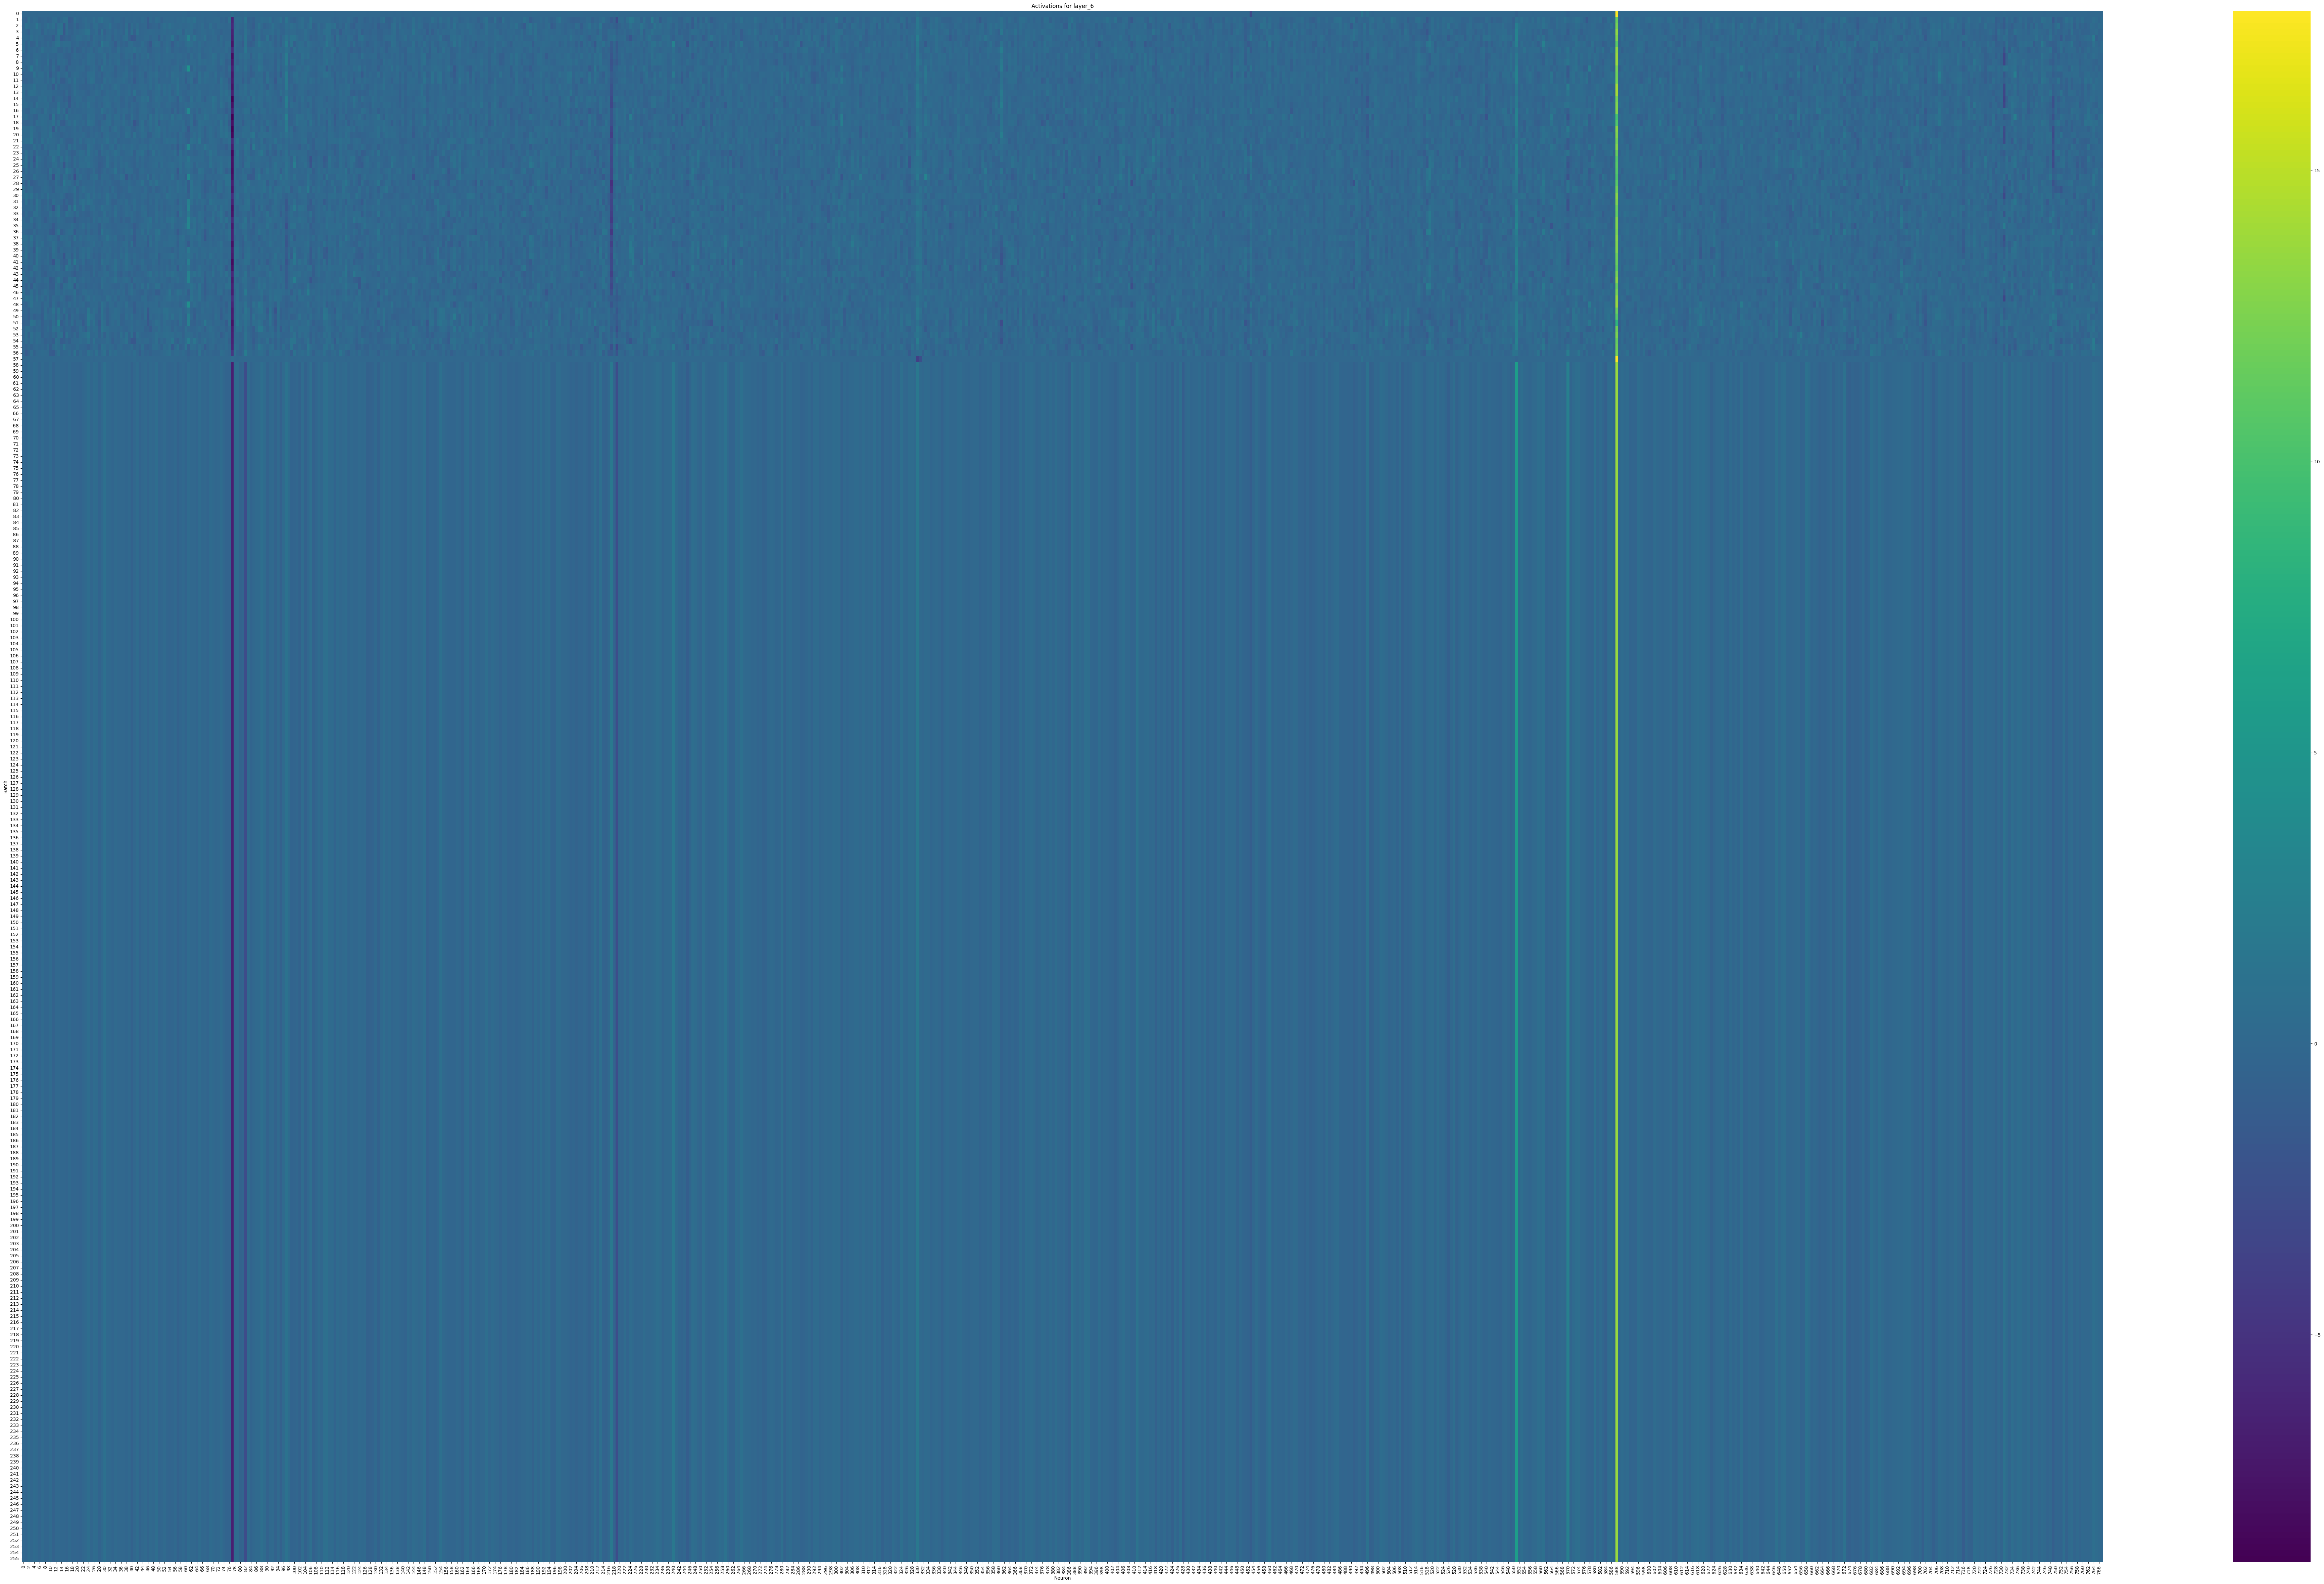

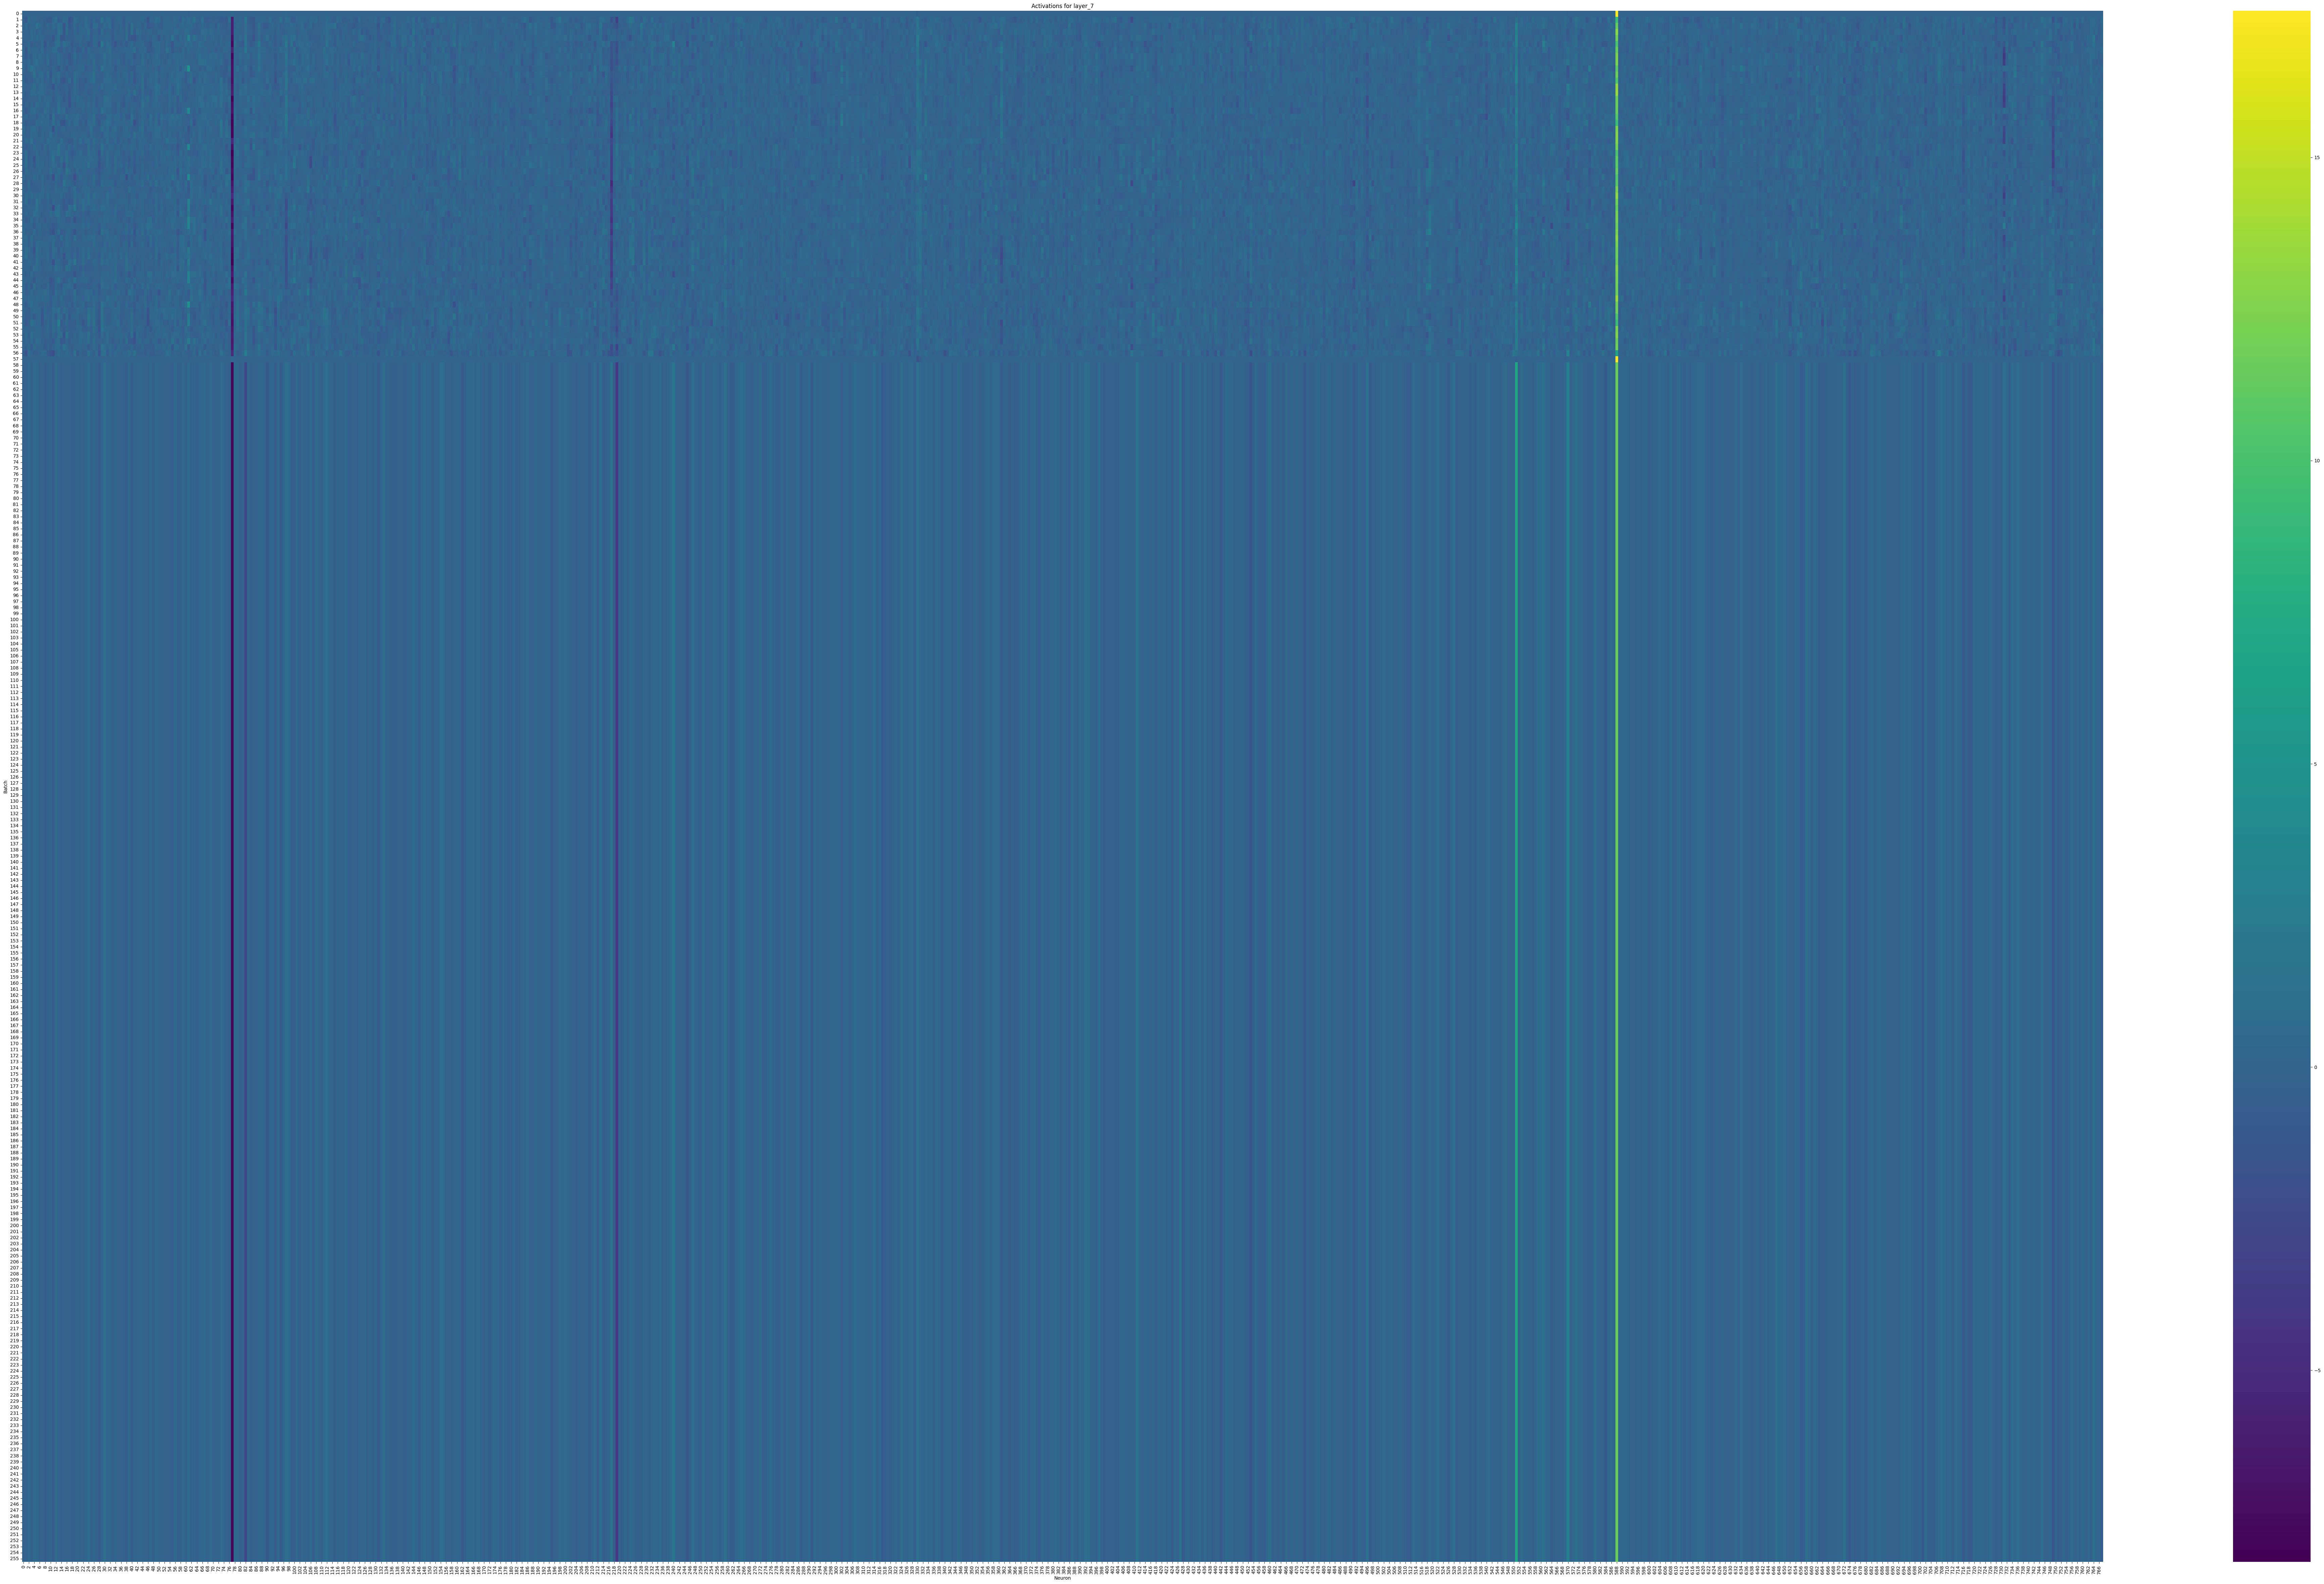

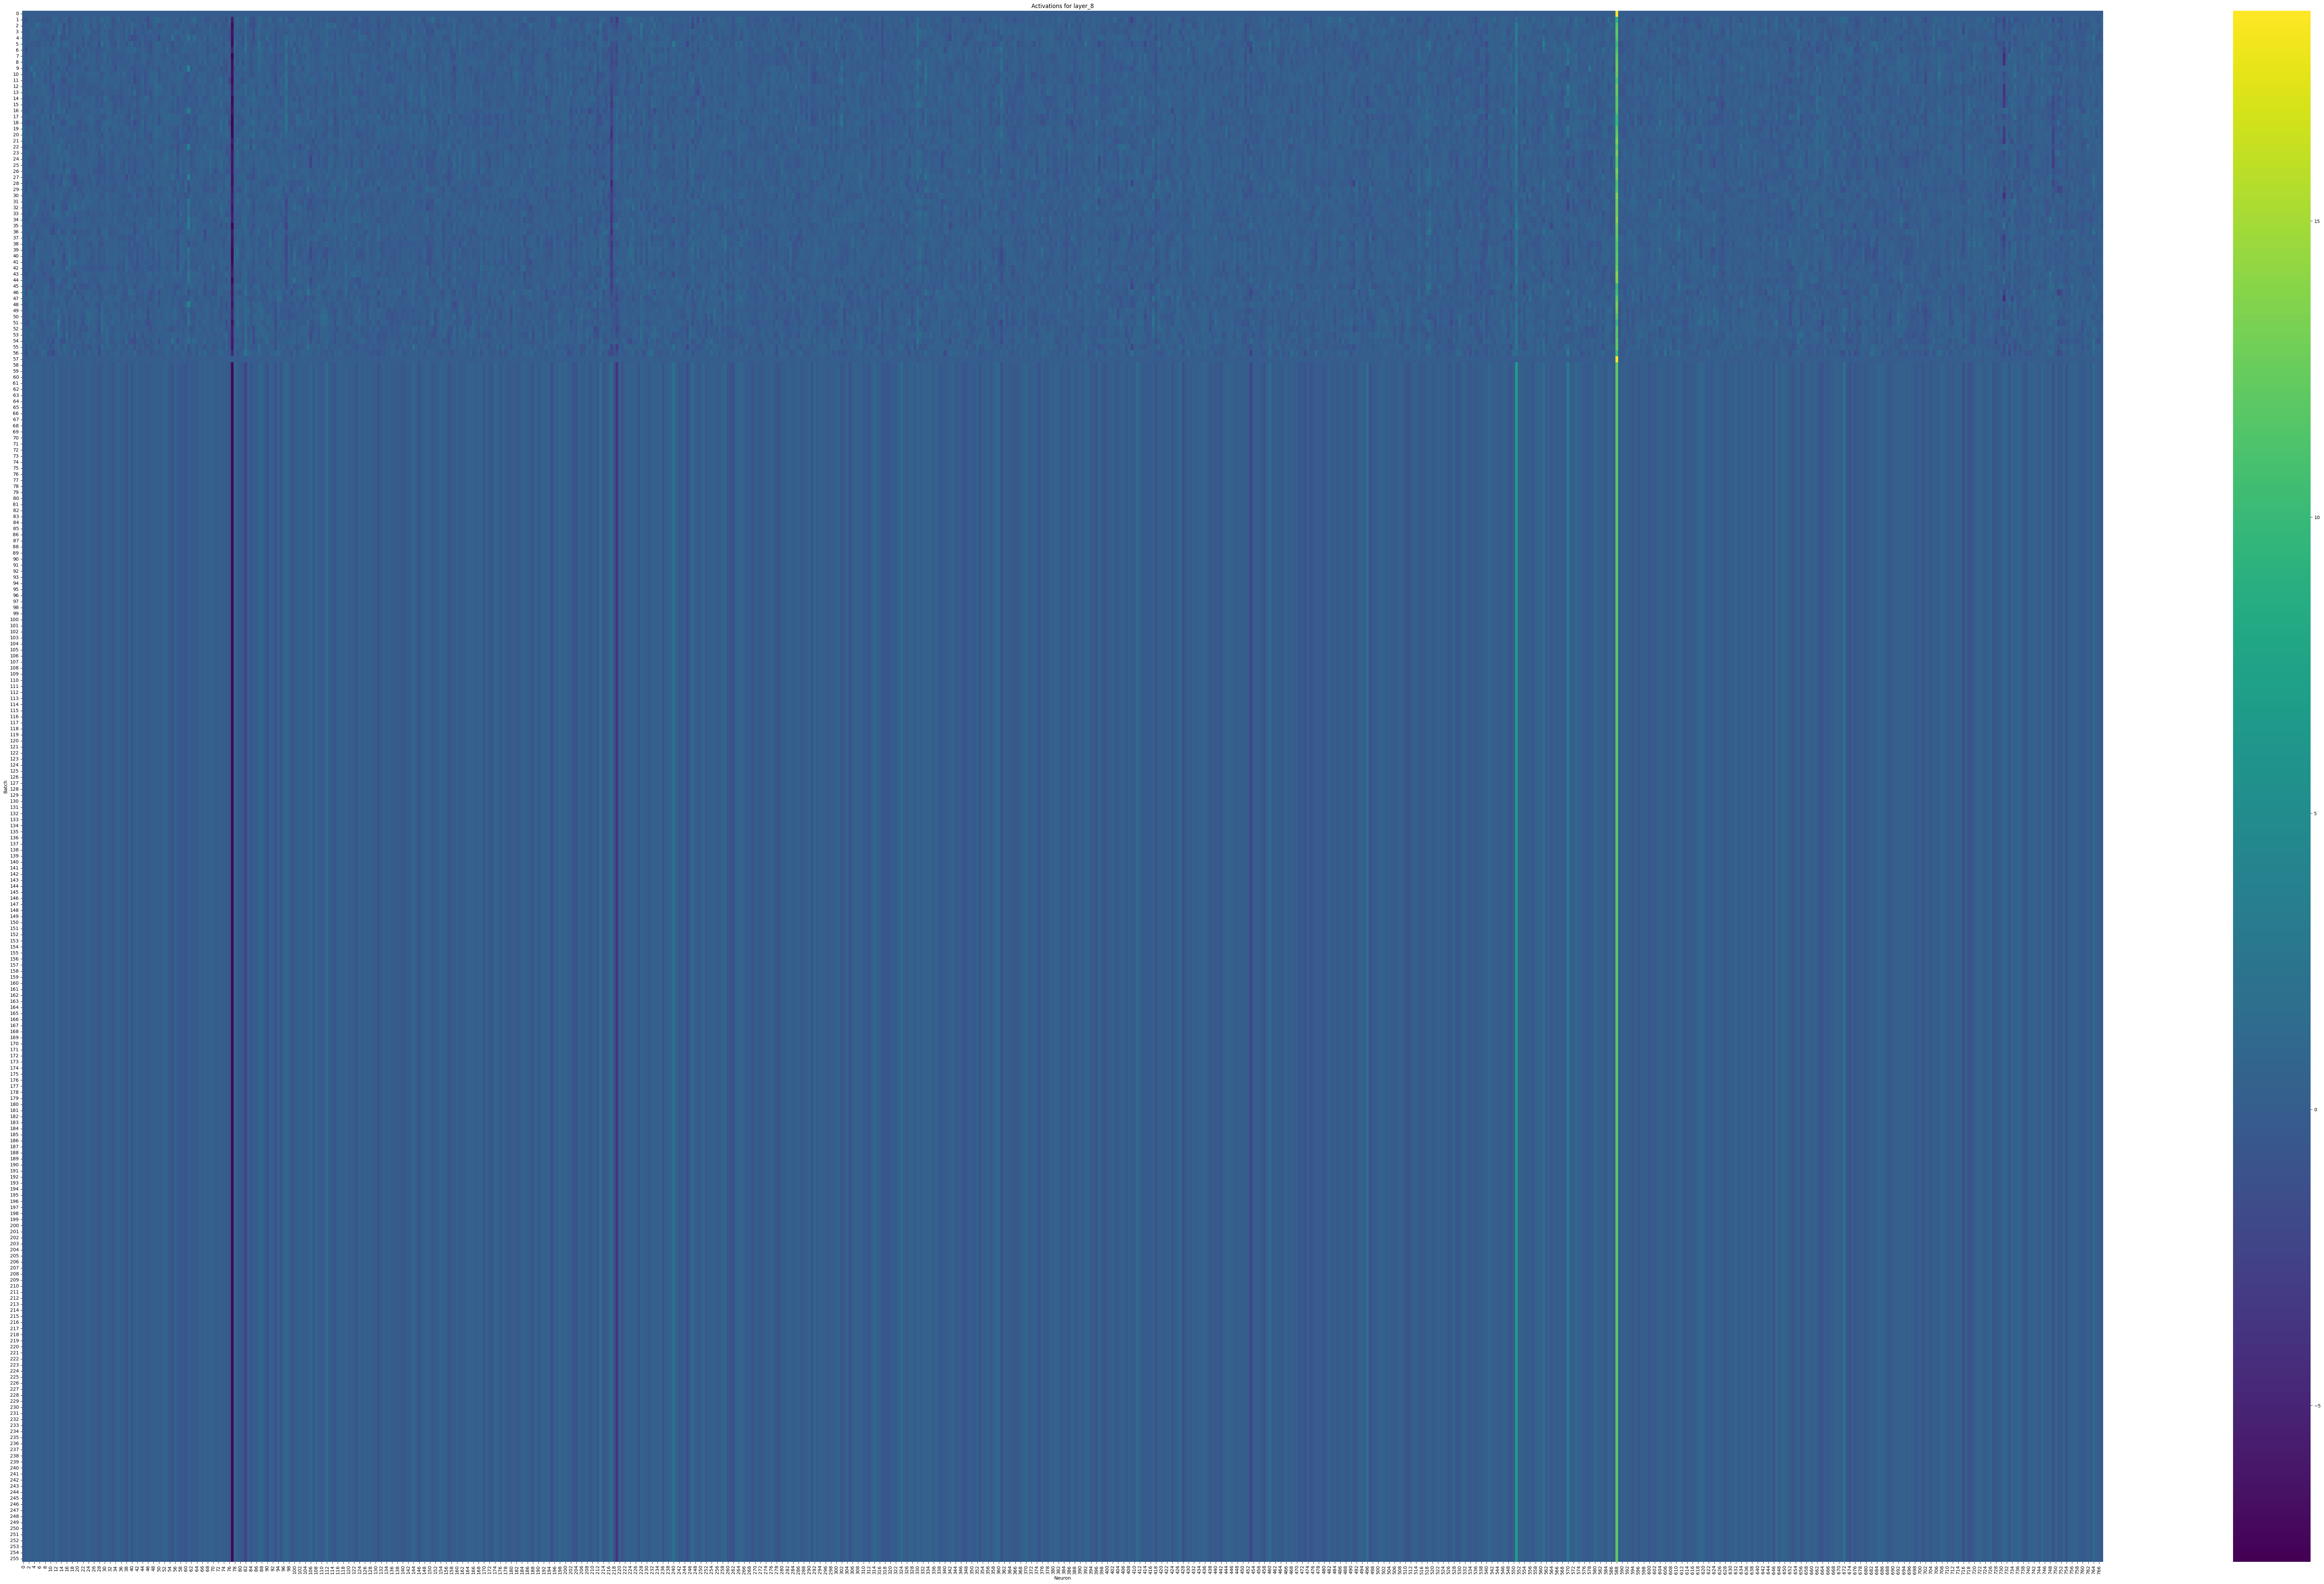

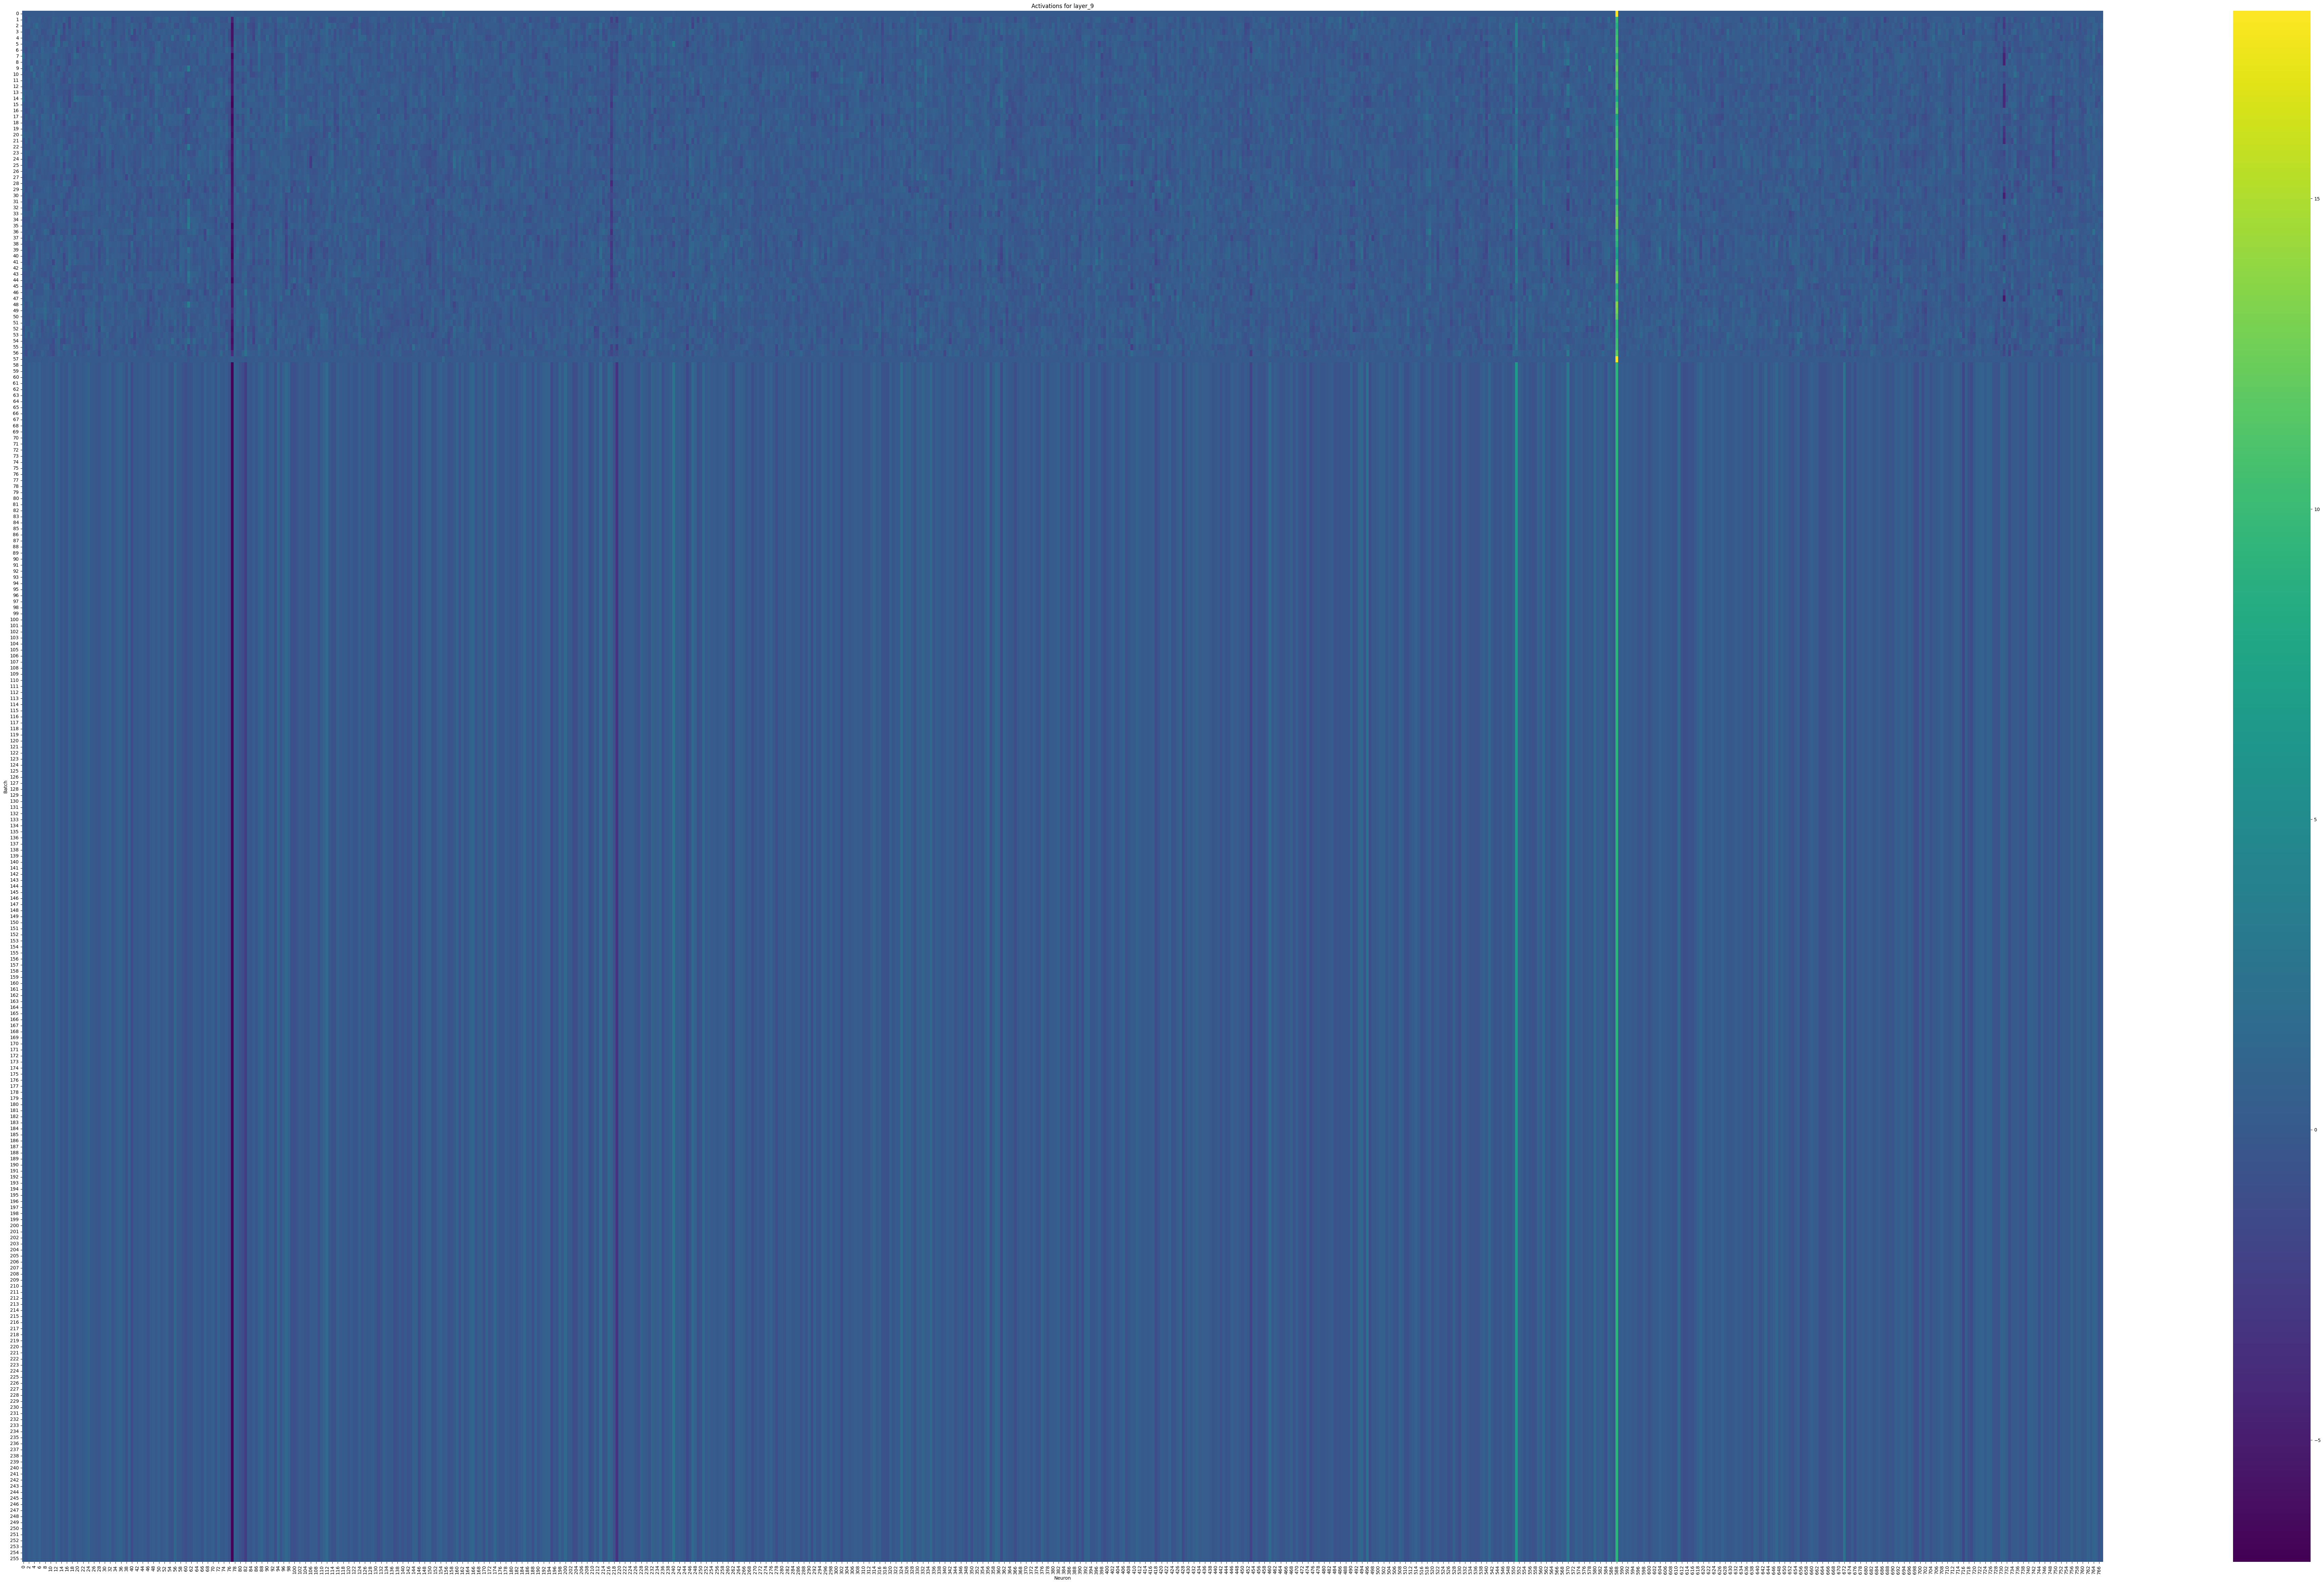

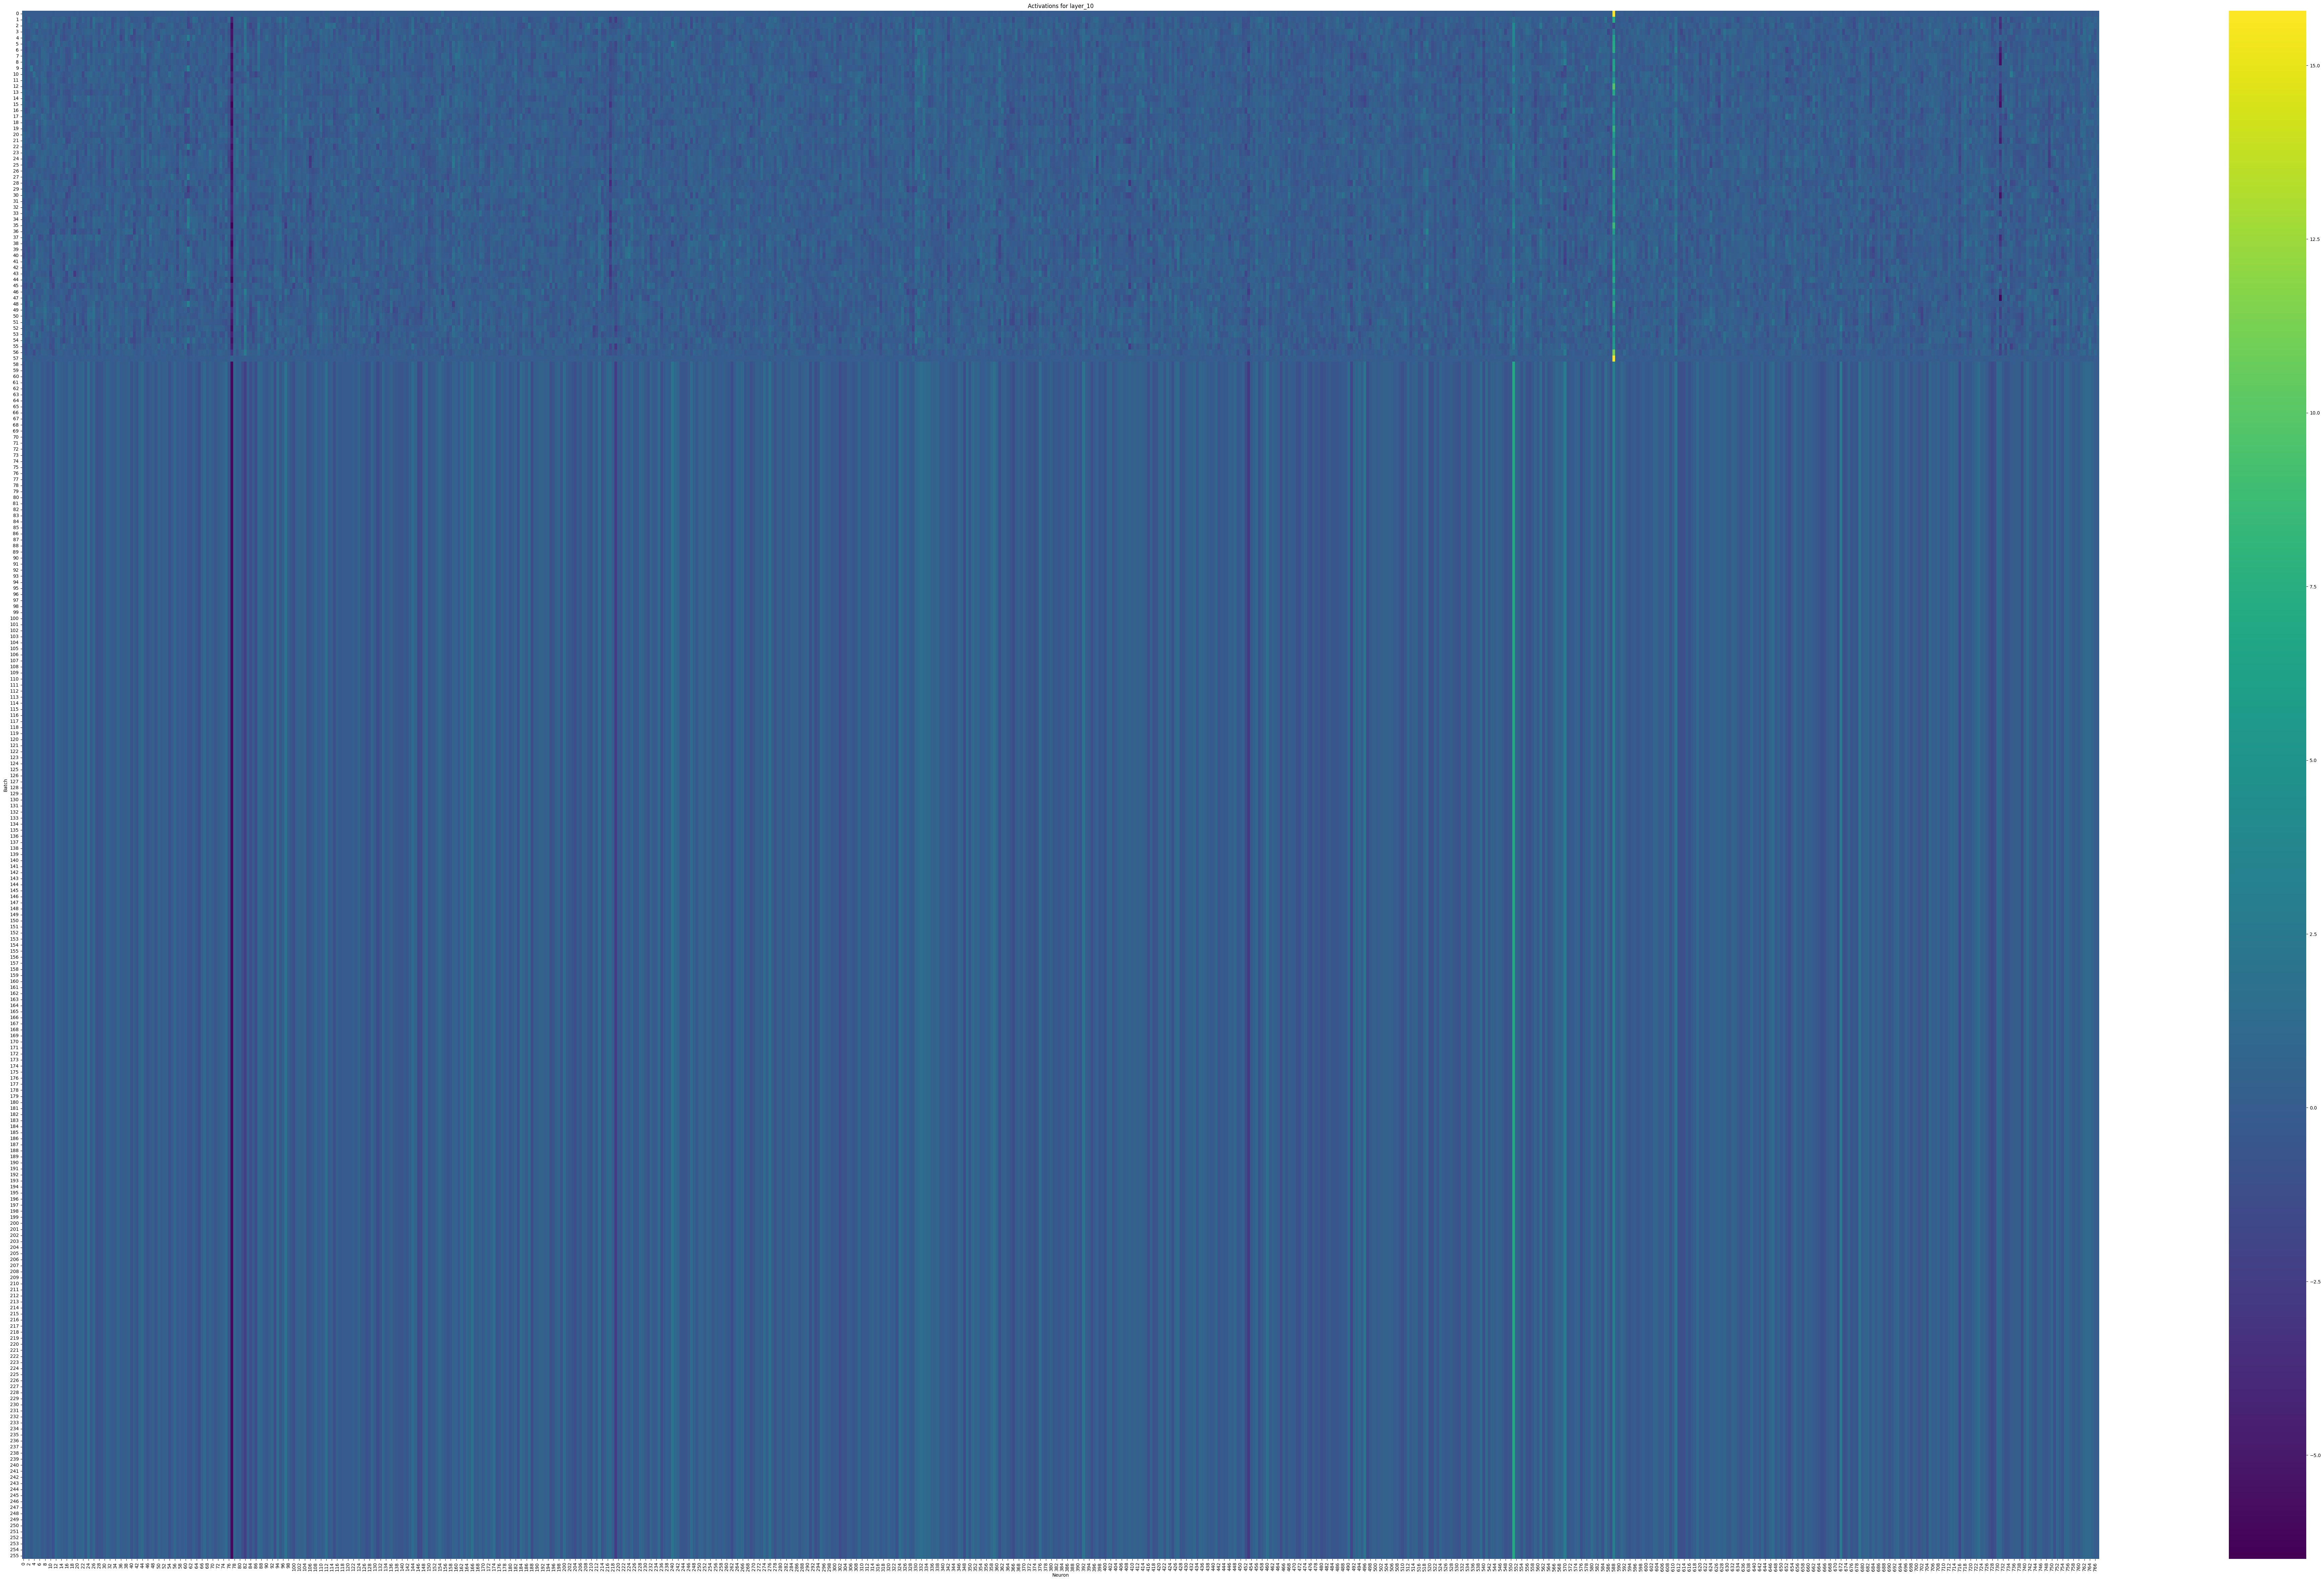

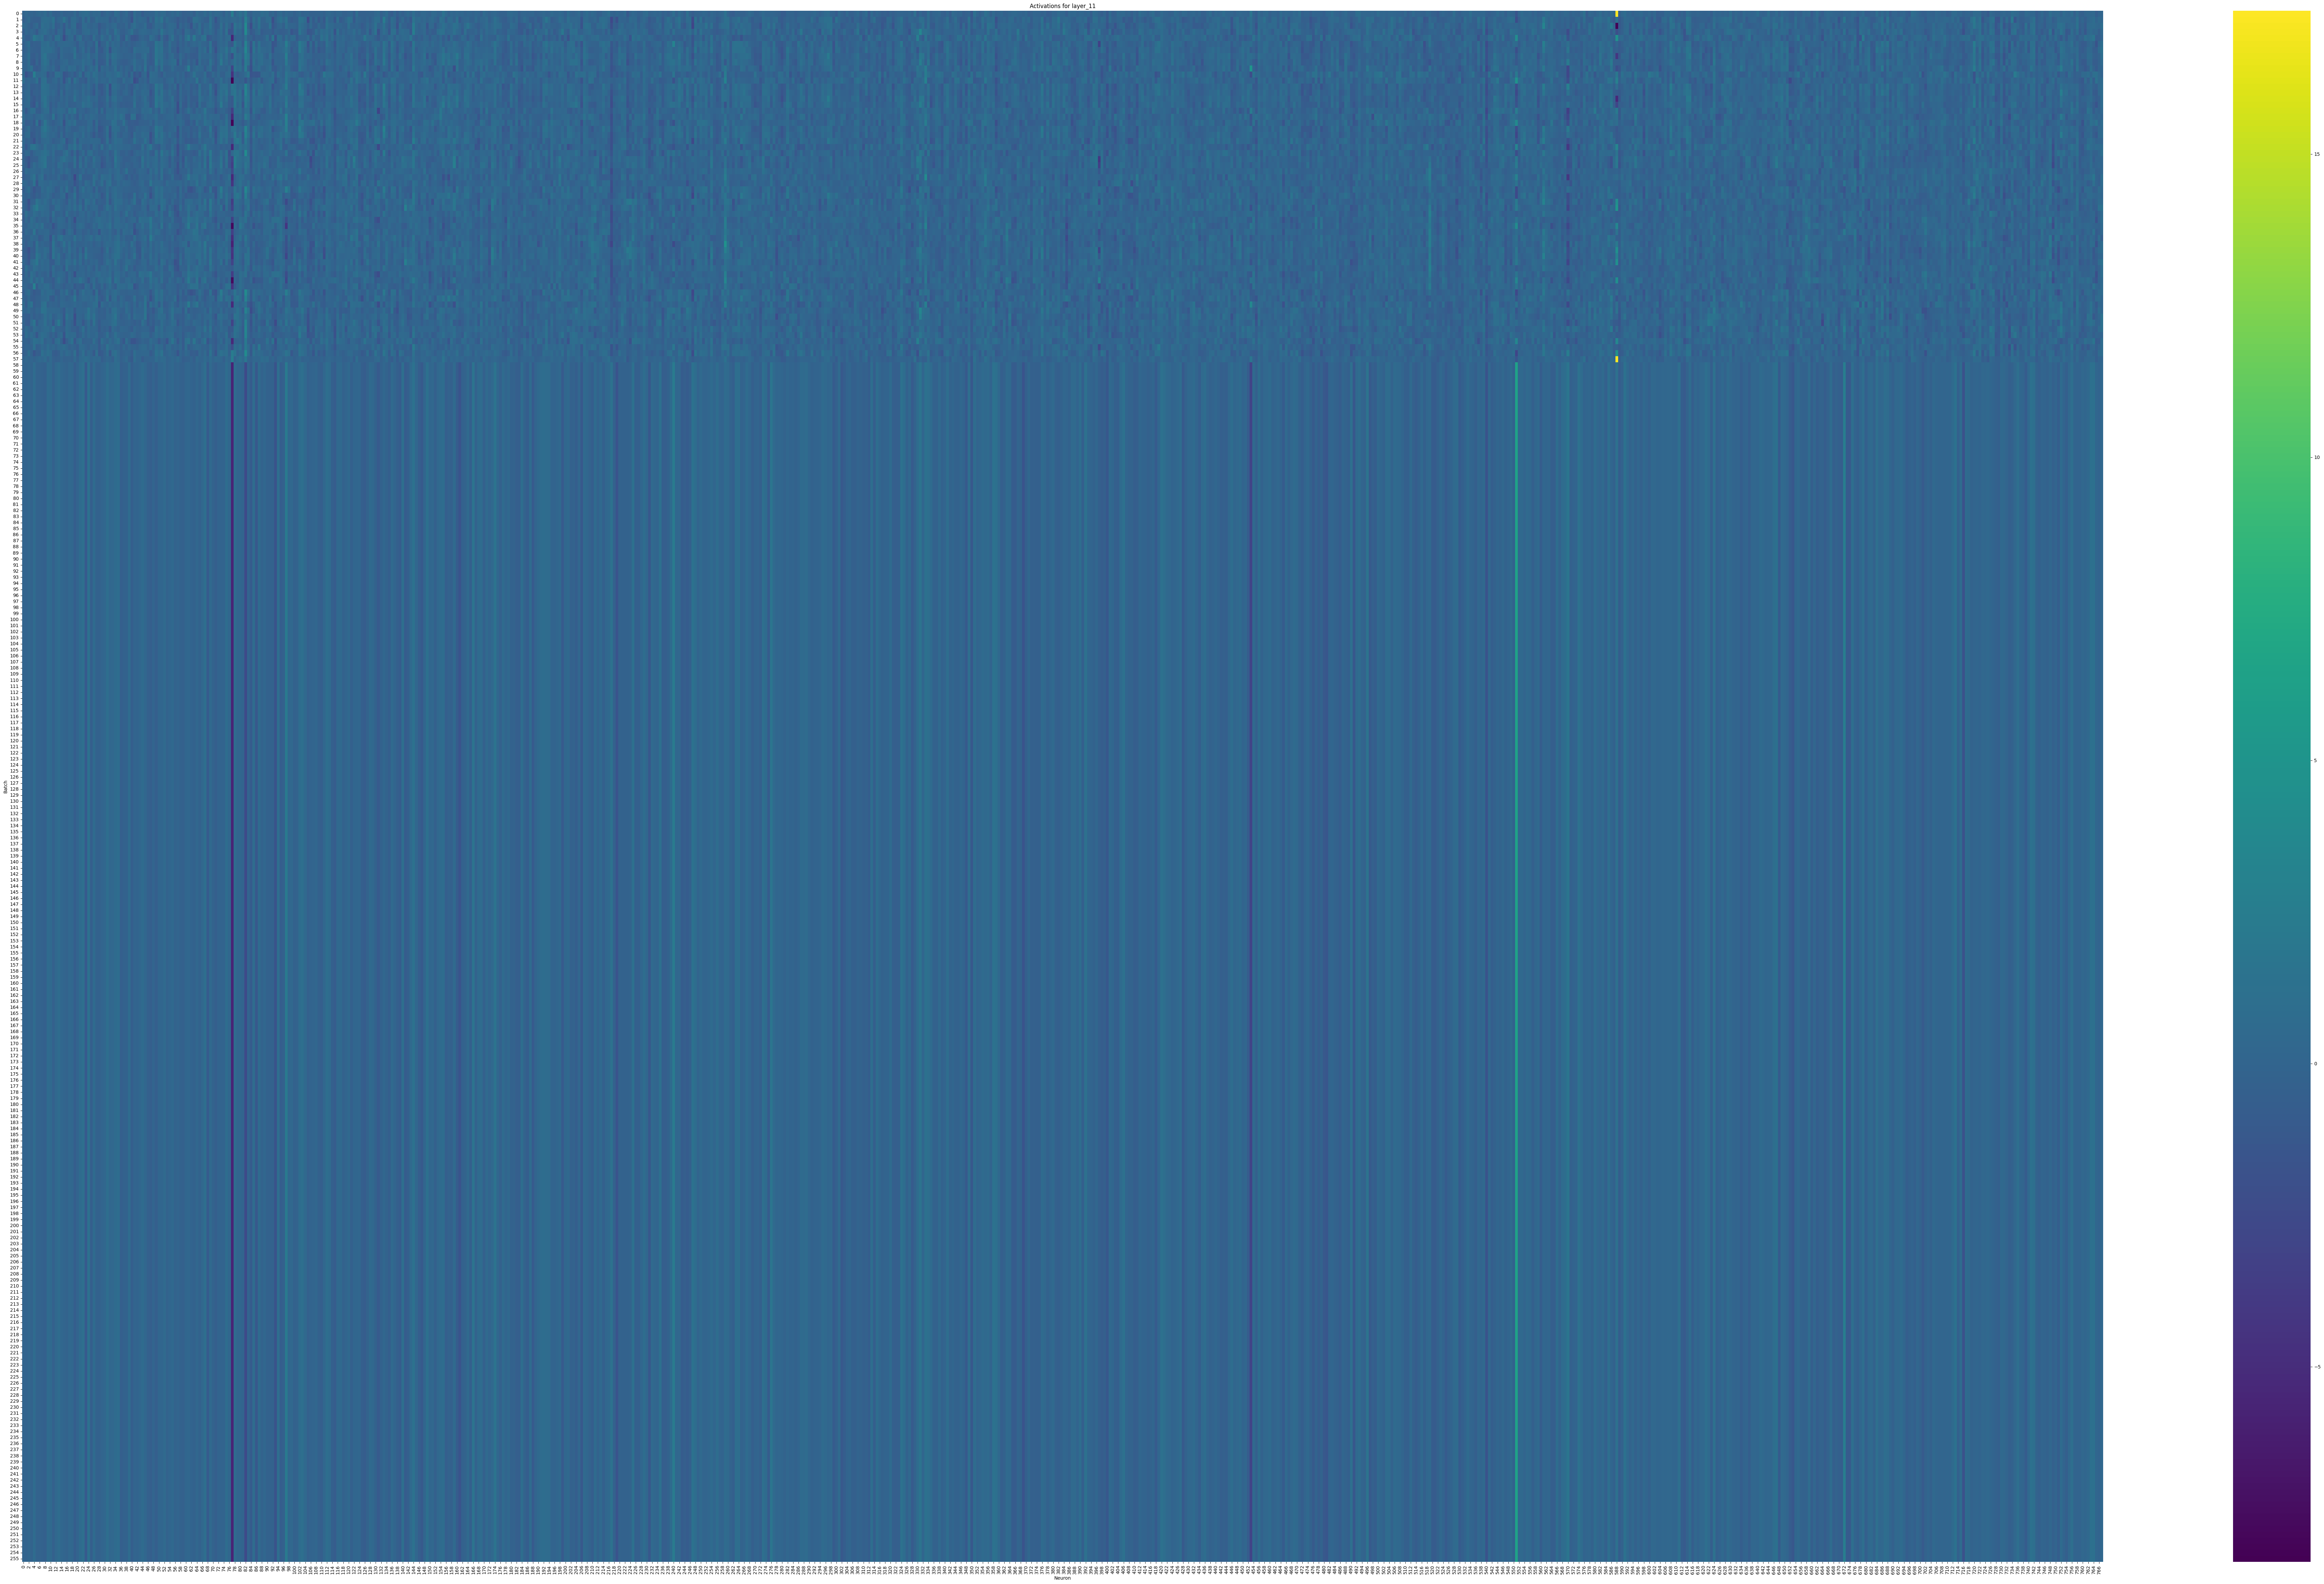

In [119]:
for layer_name, activation in activations_encoder.items():
    plt.figure(figsize=(100, 60))
    sns.heatmap(activation.squeeze().to("cpu").numpy(), cmap='viridis')
    plt.title(f'Activations for {layer_name}')
    plt.xlabel('Neuron')
    plt.ylabel('Batch')
    plt.show()

In [128]:
model.encoder.encoder.layer[0]

RobertaLayer(
  (attention): RobertaAttention(
    (self): RobertaSelfAttention(
      (query): Linear(in_features=768, out_features=768, bias=True)
      (key): Linear(in_features=768, out_features=768, bias=True)
      (value): Linear(in_features=768, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (output): RobertaSelfOutput(
      (dense): Linear(in_features=768, out_features=768, bias=True)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (intermediate): RobertaIntermediate(
    (dense): Linear(in_features=768, out_features=3072, bias=True)
    (intermediate_act_fn): GELUActivation()
  )
  (output): RobertaOutput(
    (dense): Linear(in_features=3072, out_features=768, bias=True)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
)

In [135]:
model.decoder.layers

ModuleList(
  (0-5): 6 x TransformerDecoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
    )
    (multihead_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
    )
    (linear1): Linear(in_features=768, out_features=2048, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=2048, out_features=768, bias=True)
    (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (norm3): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
    (dropout3): Dropout(p=0.1, inplace=False)
  )
)

In [138]:
for layer, activation in activations_decoder.items():
    count = 0
    for i in activation:
        count+=1
        if % 8 == 0: 
        print(f"{i} ")
    print(f'Layer: {layer}')
    print(f'Shape: {activation.shape}')
    


tensor([[ 0.6320, -0.4205,  0.1492,  ...,  0.1193,  0.7347,  0.0507],
        [ 0.2439, -0.2693,  0.2914,  ..., -0.6835,  0.4032, -0.4429],
        [-0.0034, -0.4479,  0.2273,  ..., -0.8653,  0.5770, -0.4575],
        ...,
        [-0.1418, -0.7847,  0.6244,  ..., -0.7519,  0.4250, -0.2168],
        [ 0.5023, -0.3564,  0.4004,  ..., -1.0402,  0.4933, -0.3170],
        [ 0.0906, -0.4756,  0.3582,  ..., -1.3133,  0.7901, -0.3093]],
       device='cuda:0') 
tensor([[ 0.7533,  0.8286, -1.0808,  ..., -1.3576,  0.9585, -0.4675],
        [ 0.9702,  0.7790, -1.2017,  ..., -0.9344,  0.5831, -0.3409],
        [ 1.0849,  0.9168, -1.1614,  ..., -1.3559,  0.9472, -0.1615],
        ...,
        [ 1.4070,  0.8406, -1.1146,  ..., -1.1847,  0.4380, -0.4792],
        [ 0.9909,  0.8475, -1.2832,  ..., -0.7364,  0.6307, -0.2893],
        [ 1.1921,  0.5868, -1.2509,  ..., -0.8724,  0.8057, -0.1166]],
       device='cuda:0') 
tensor([[-0.3624,  1.3123,  0.6456,  ...,  2.2904, -1.3291,  0.5559],
        [-0.

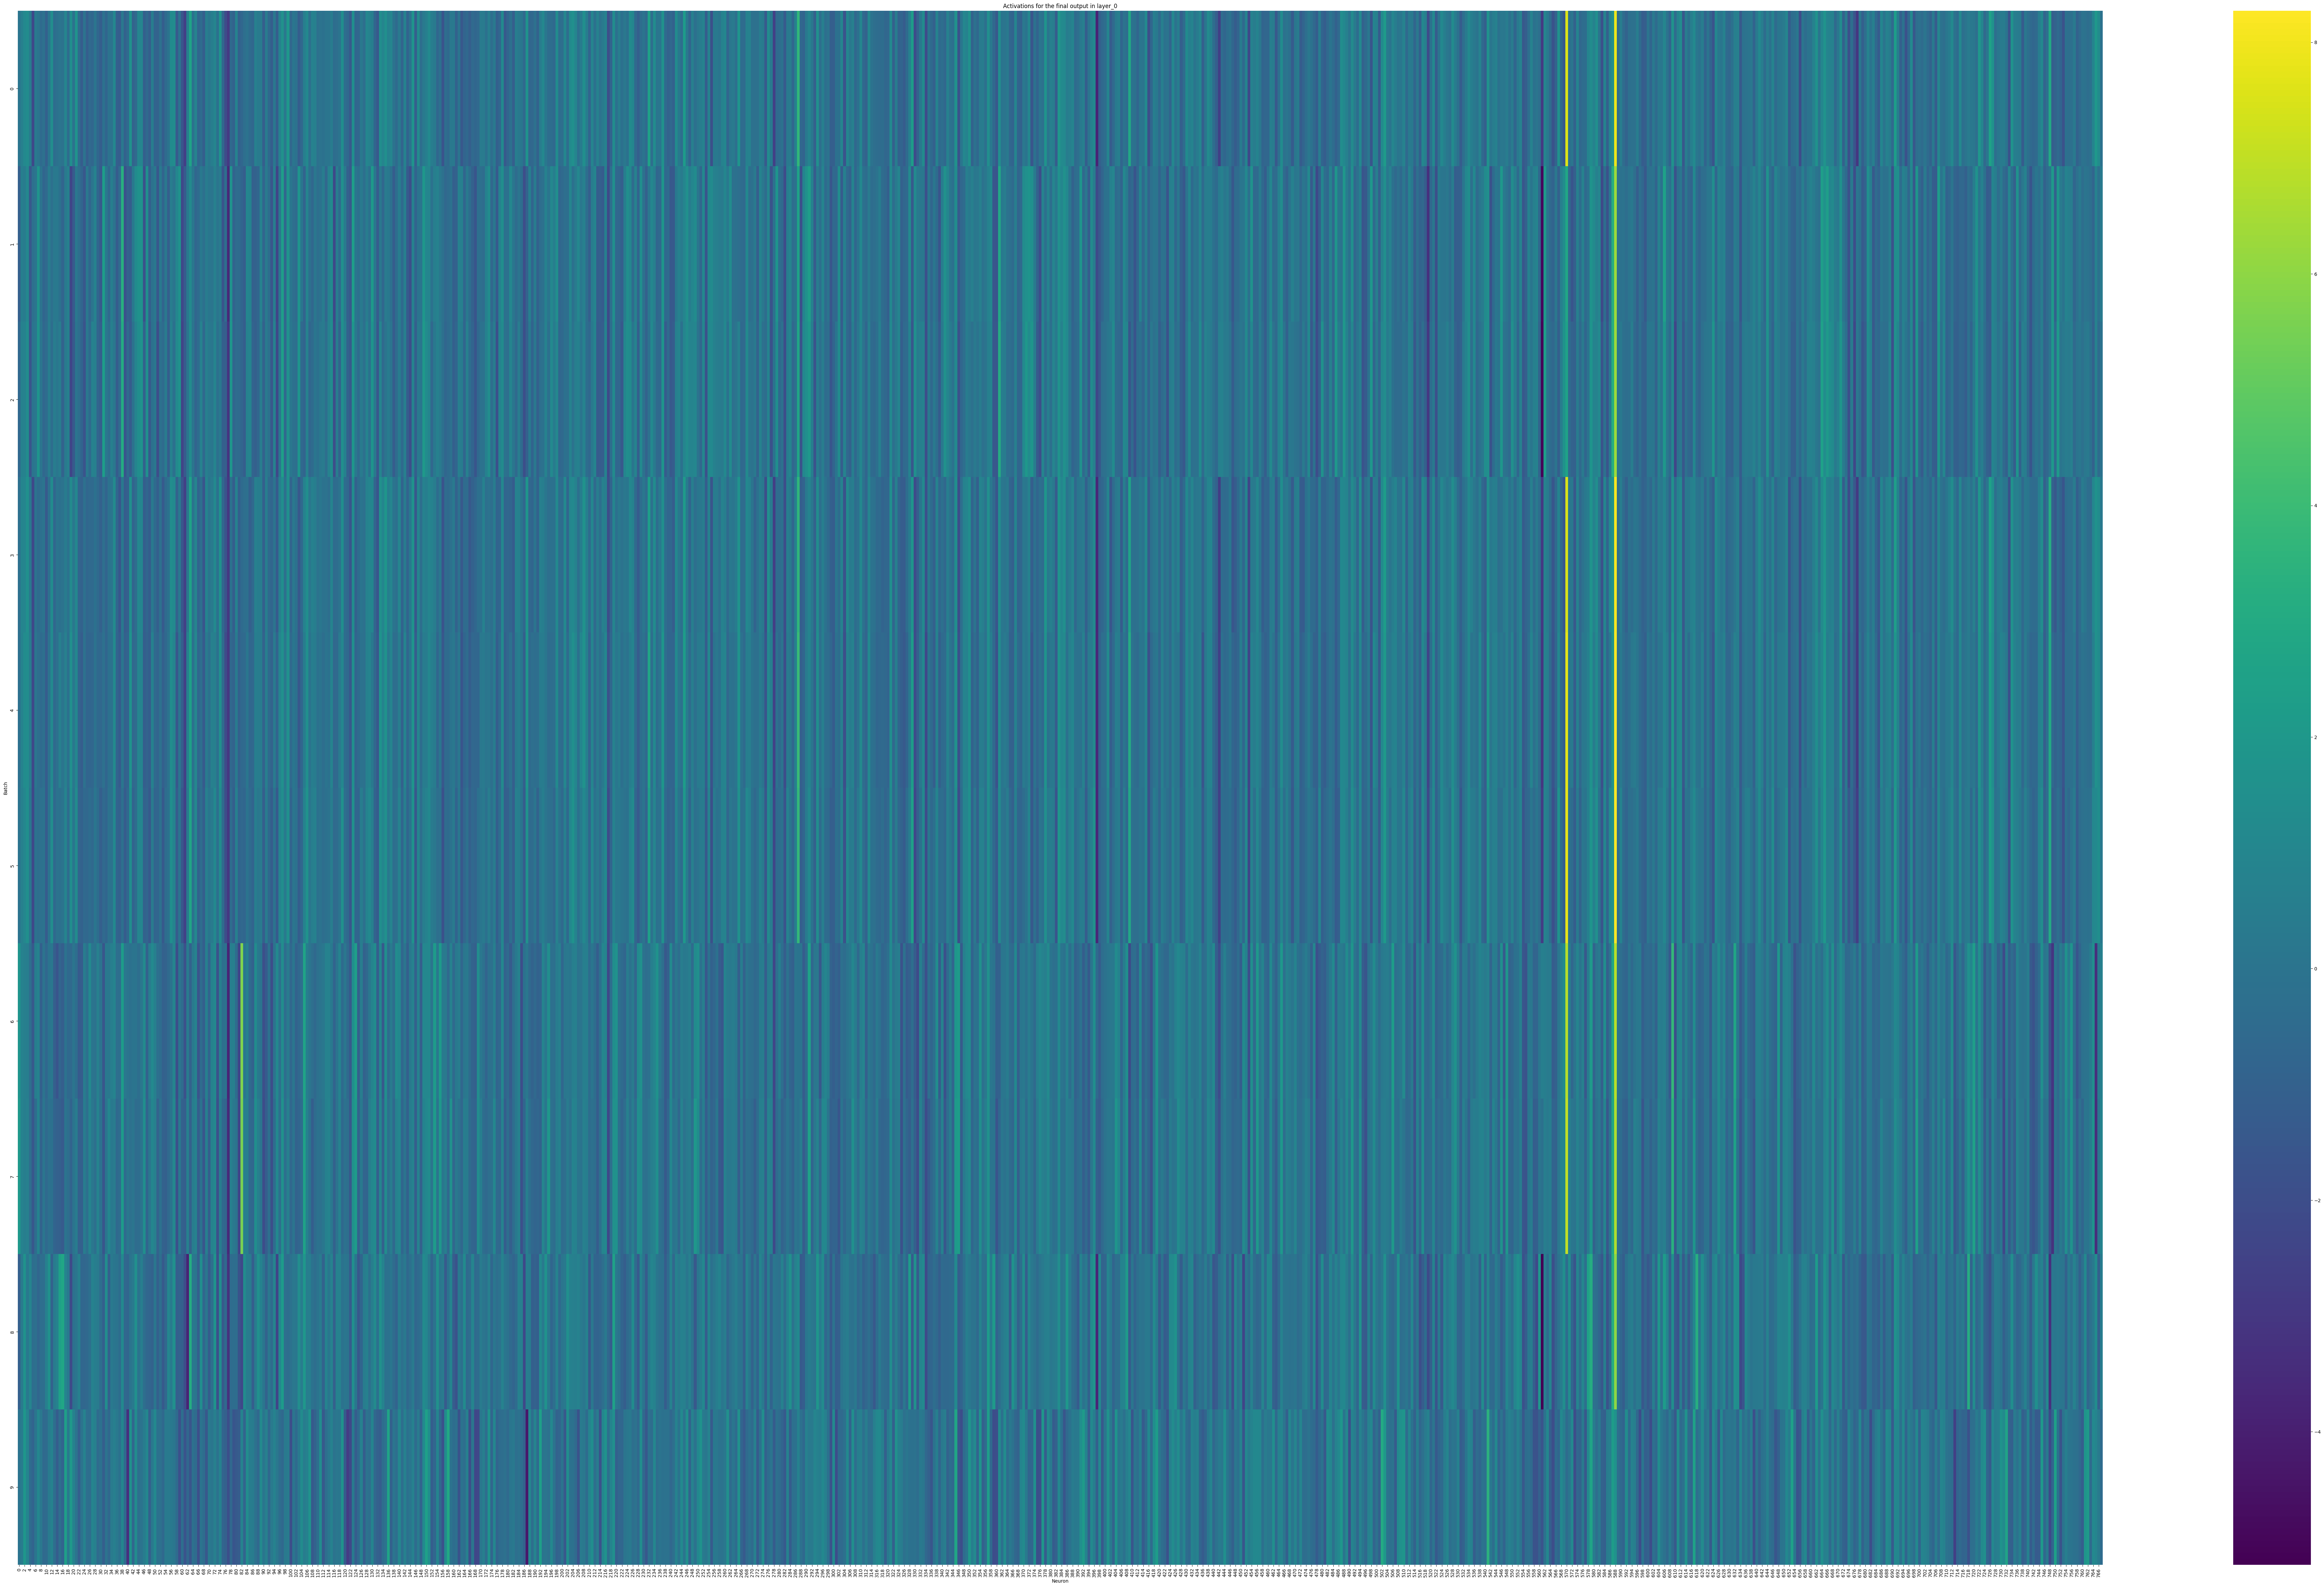

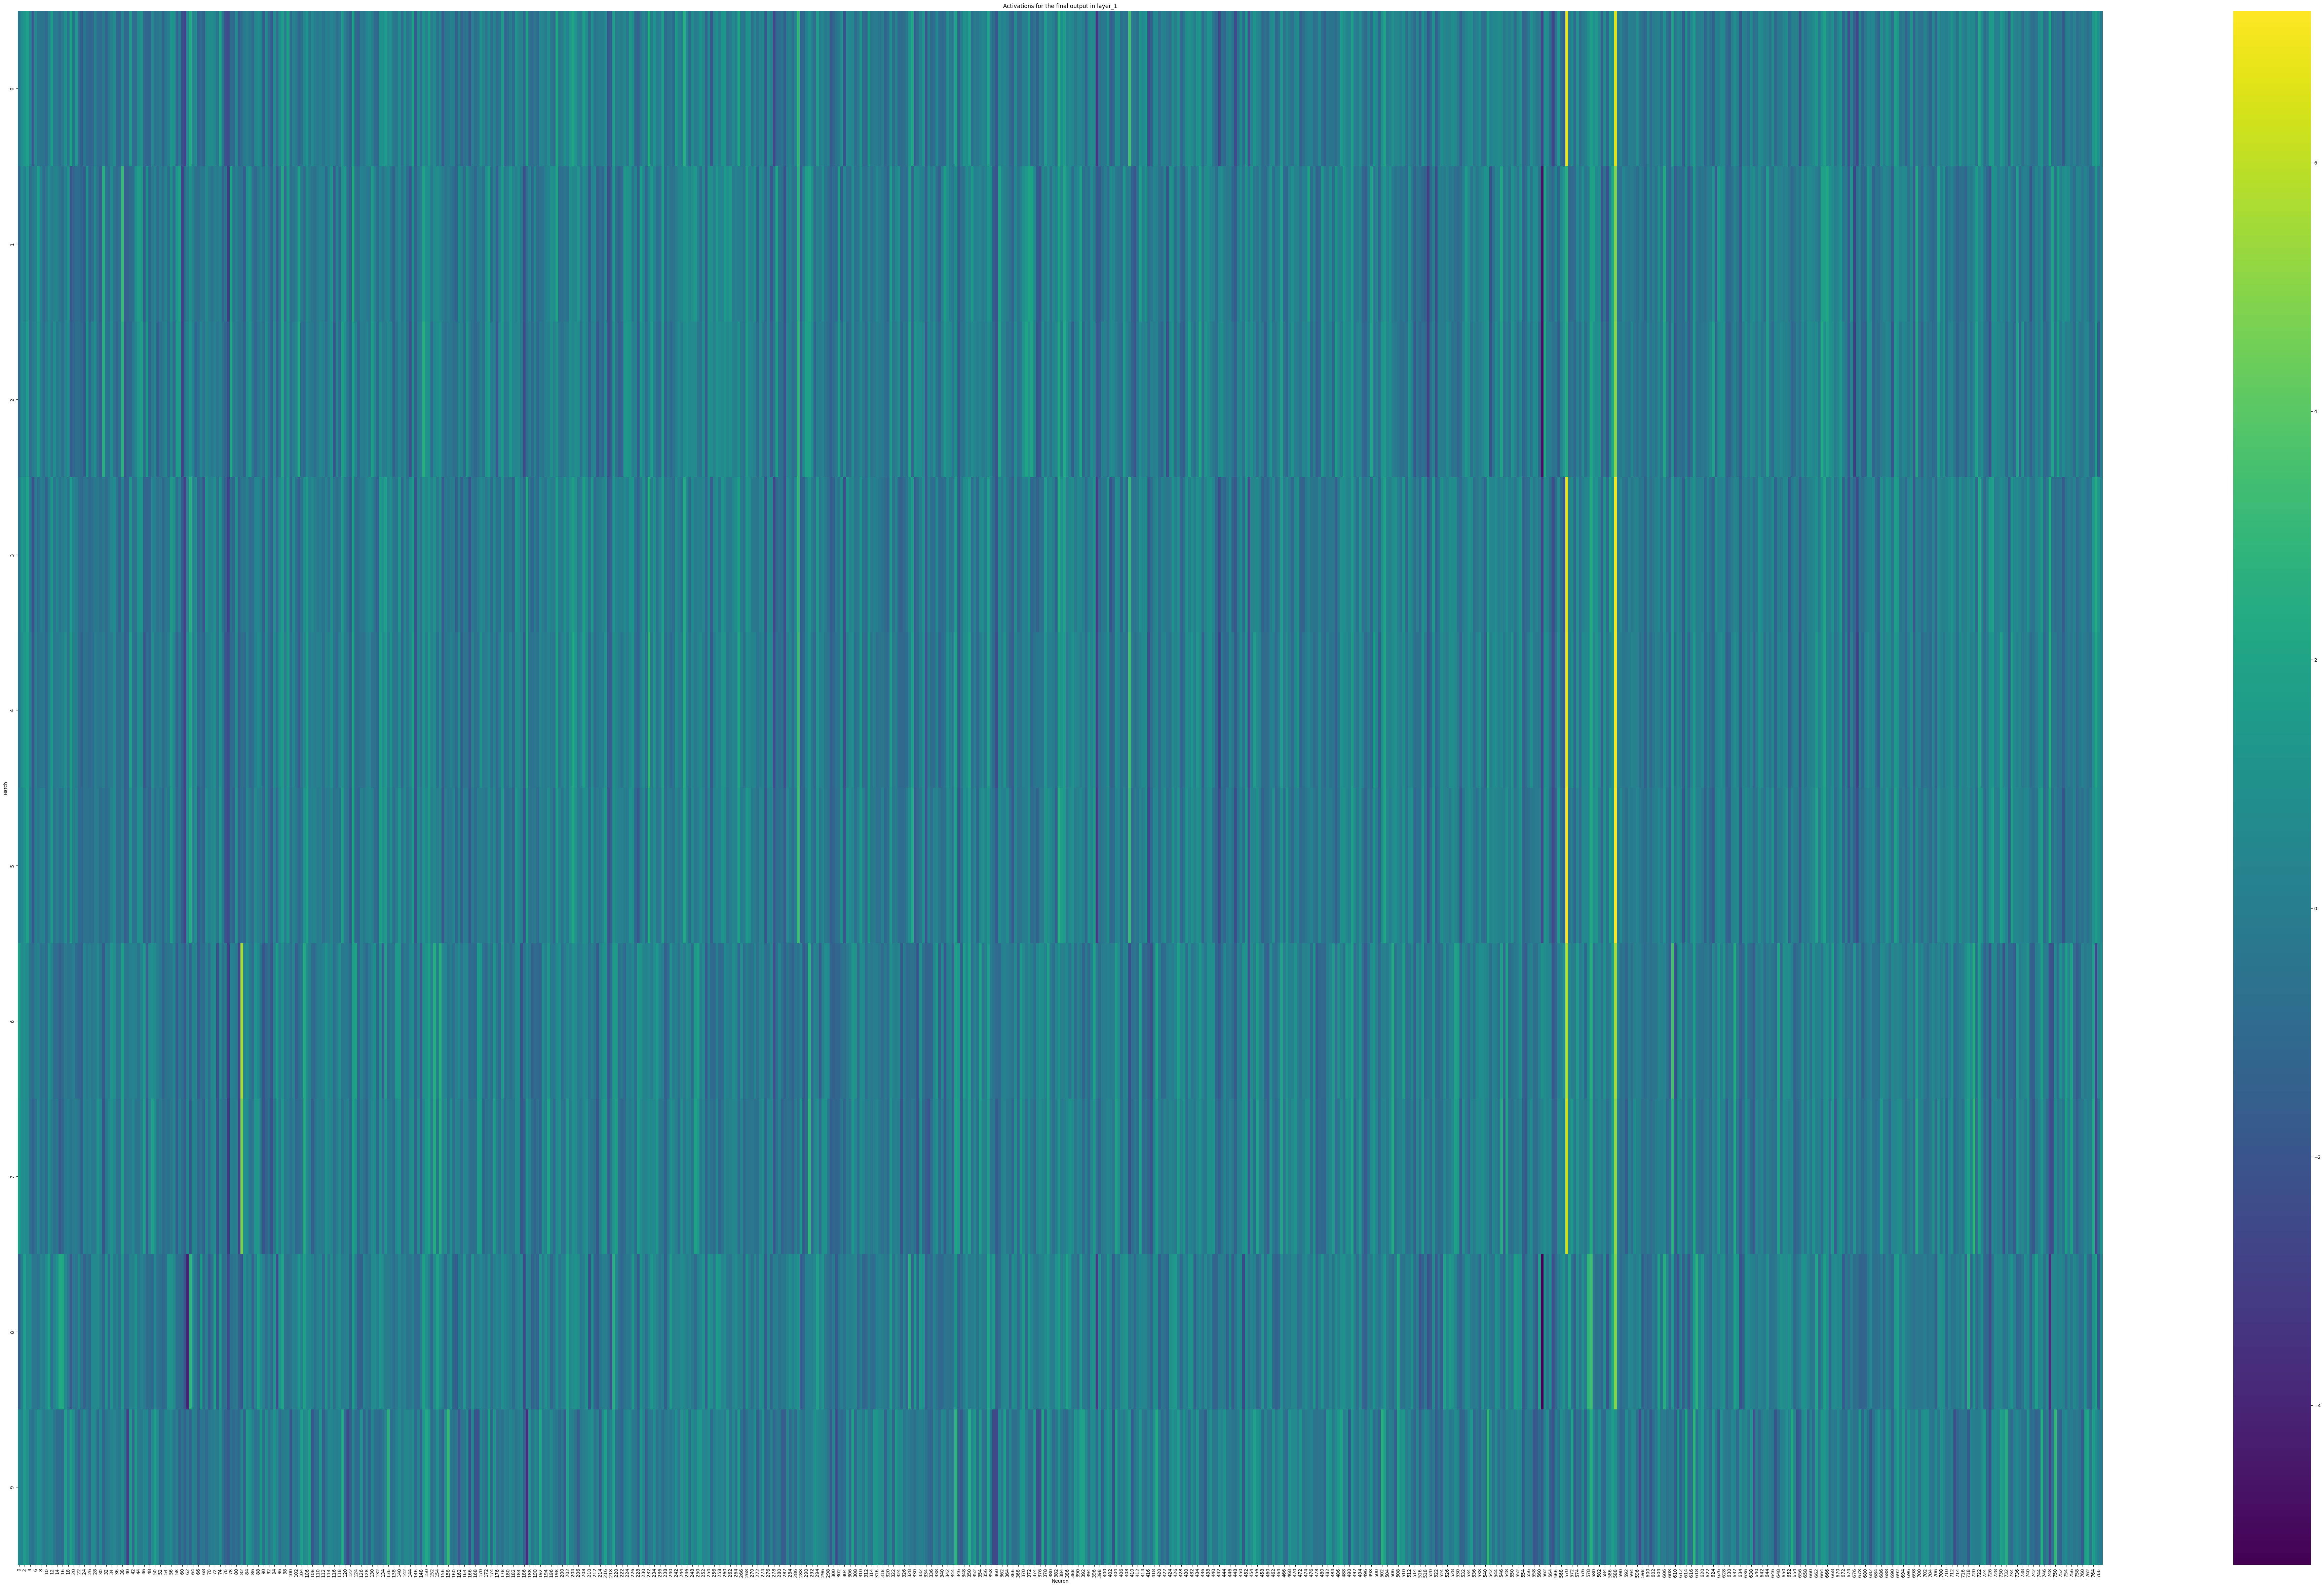

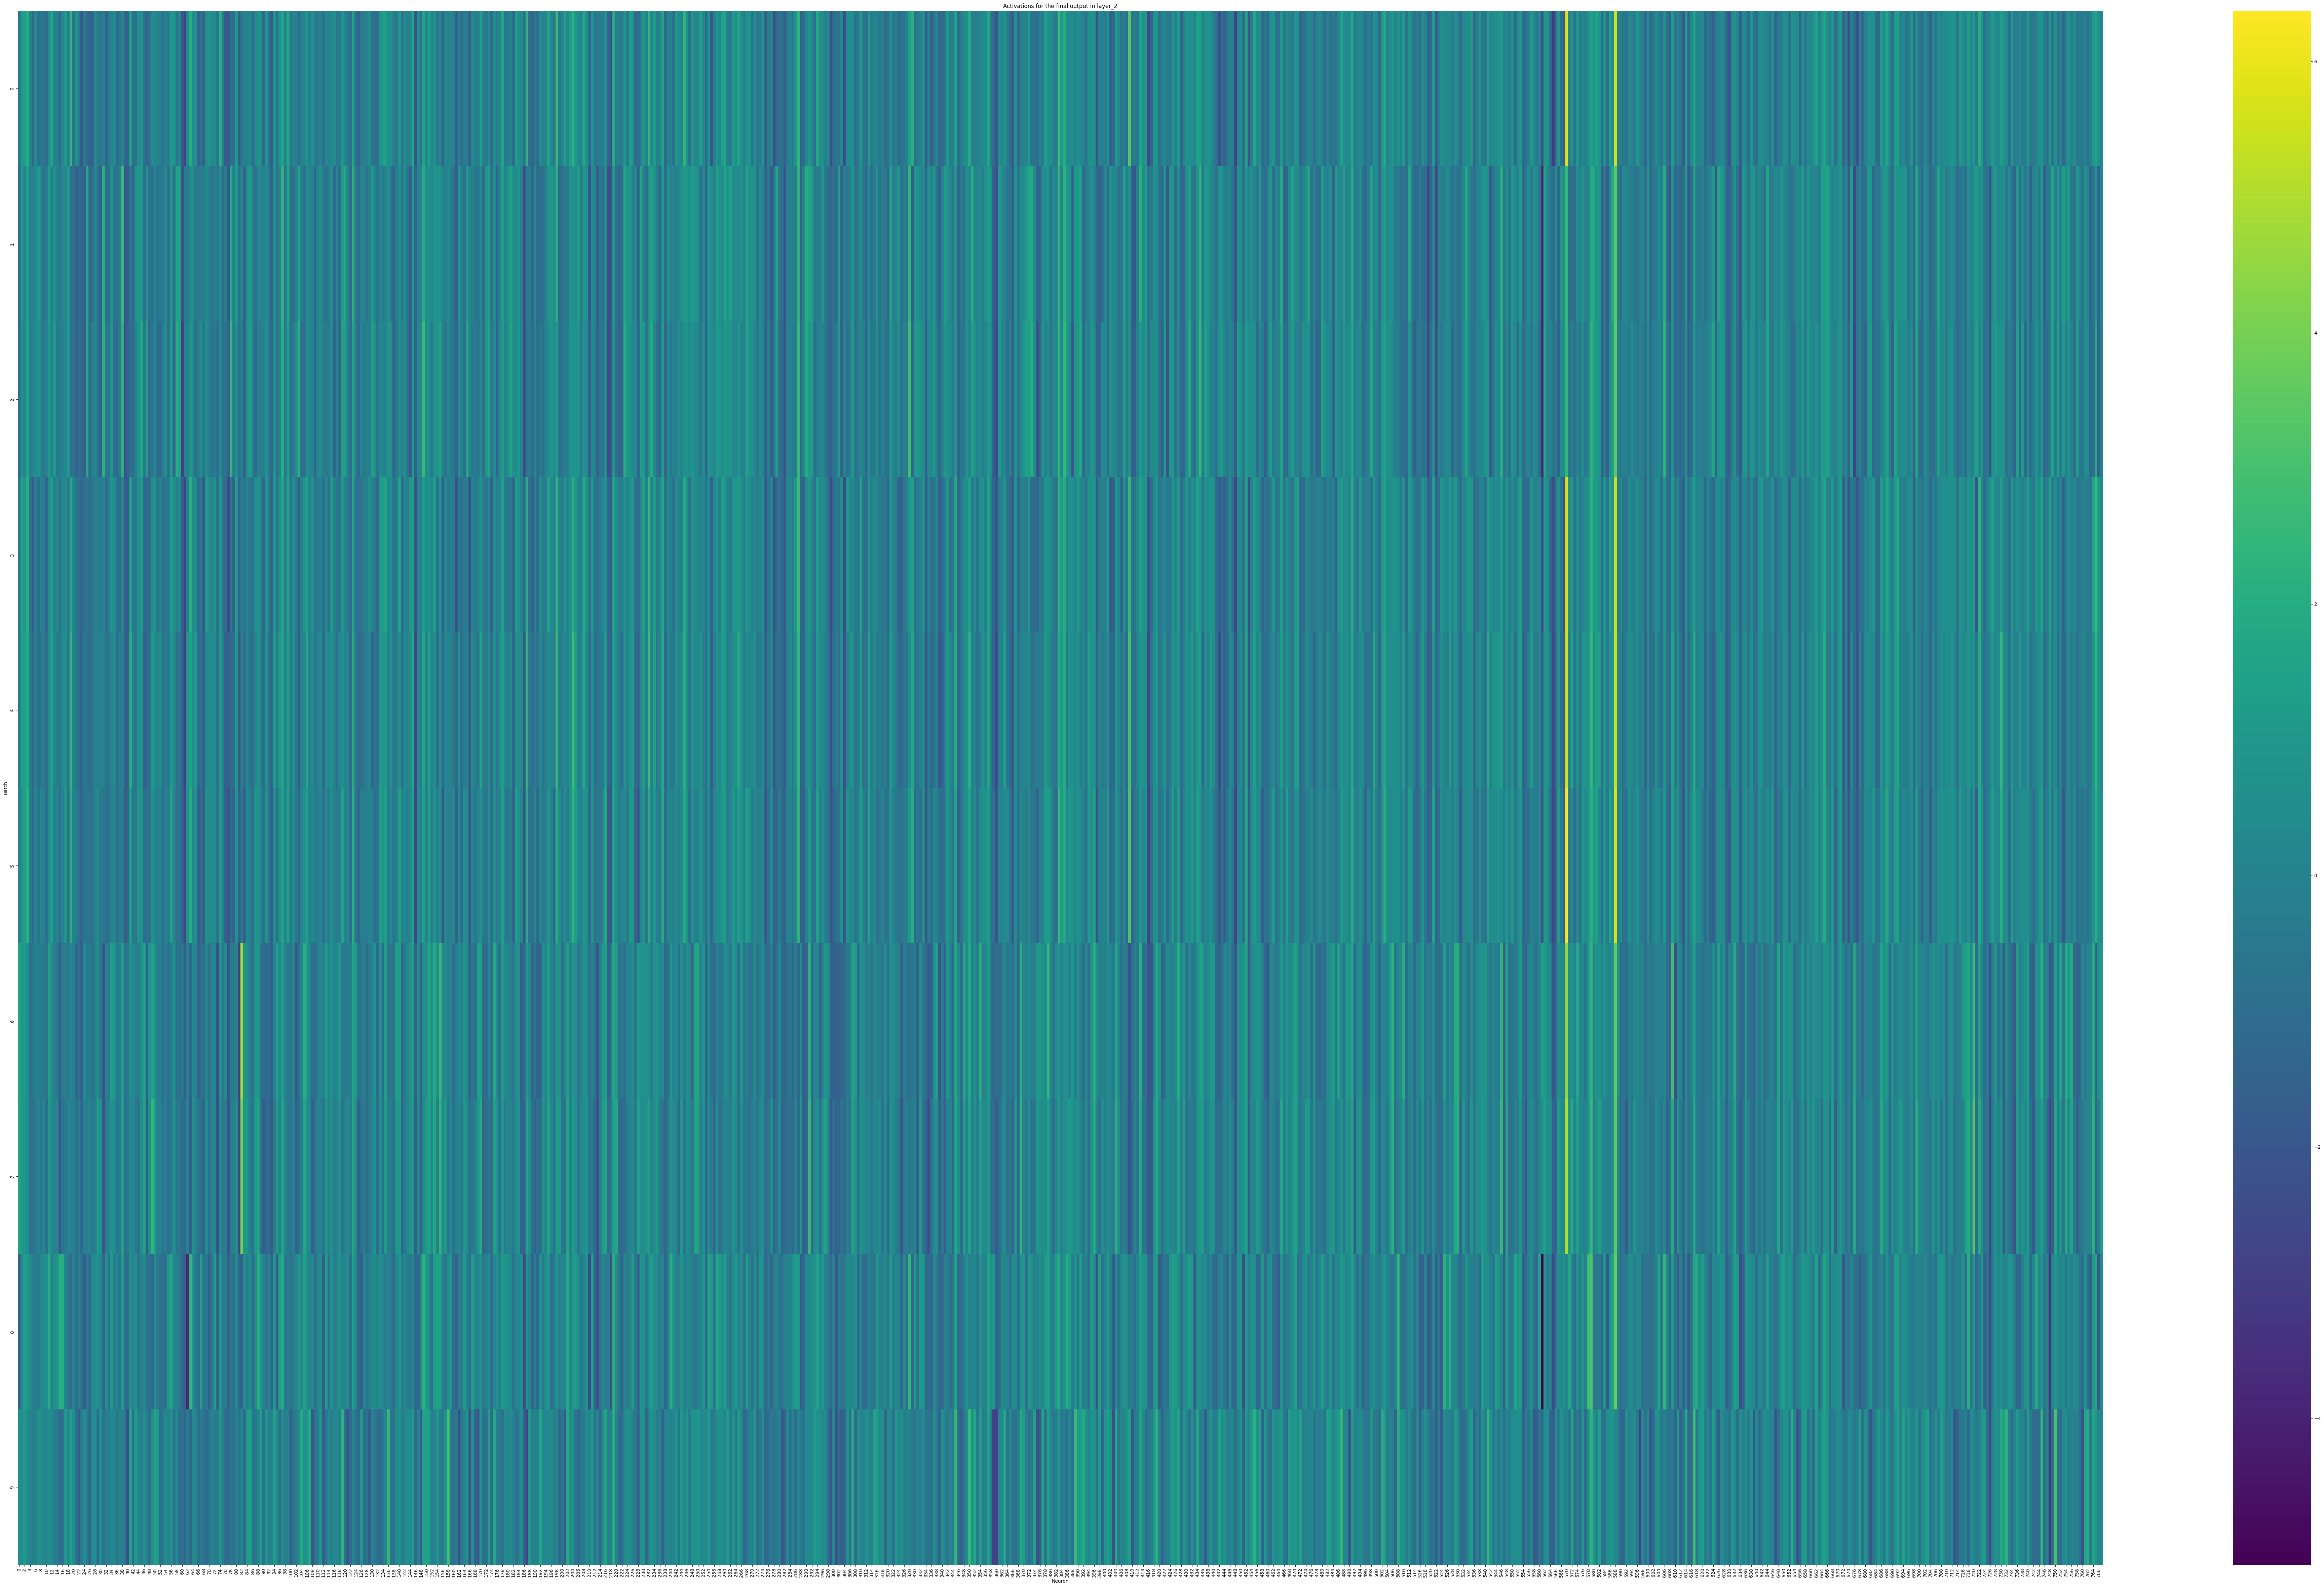

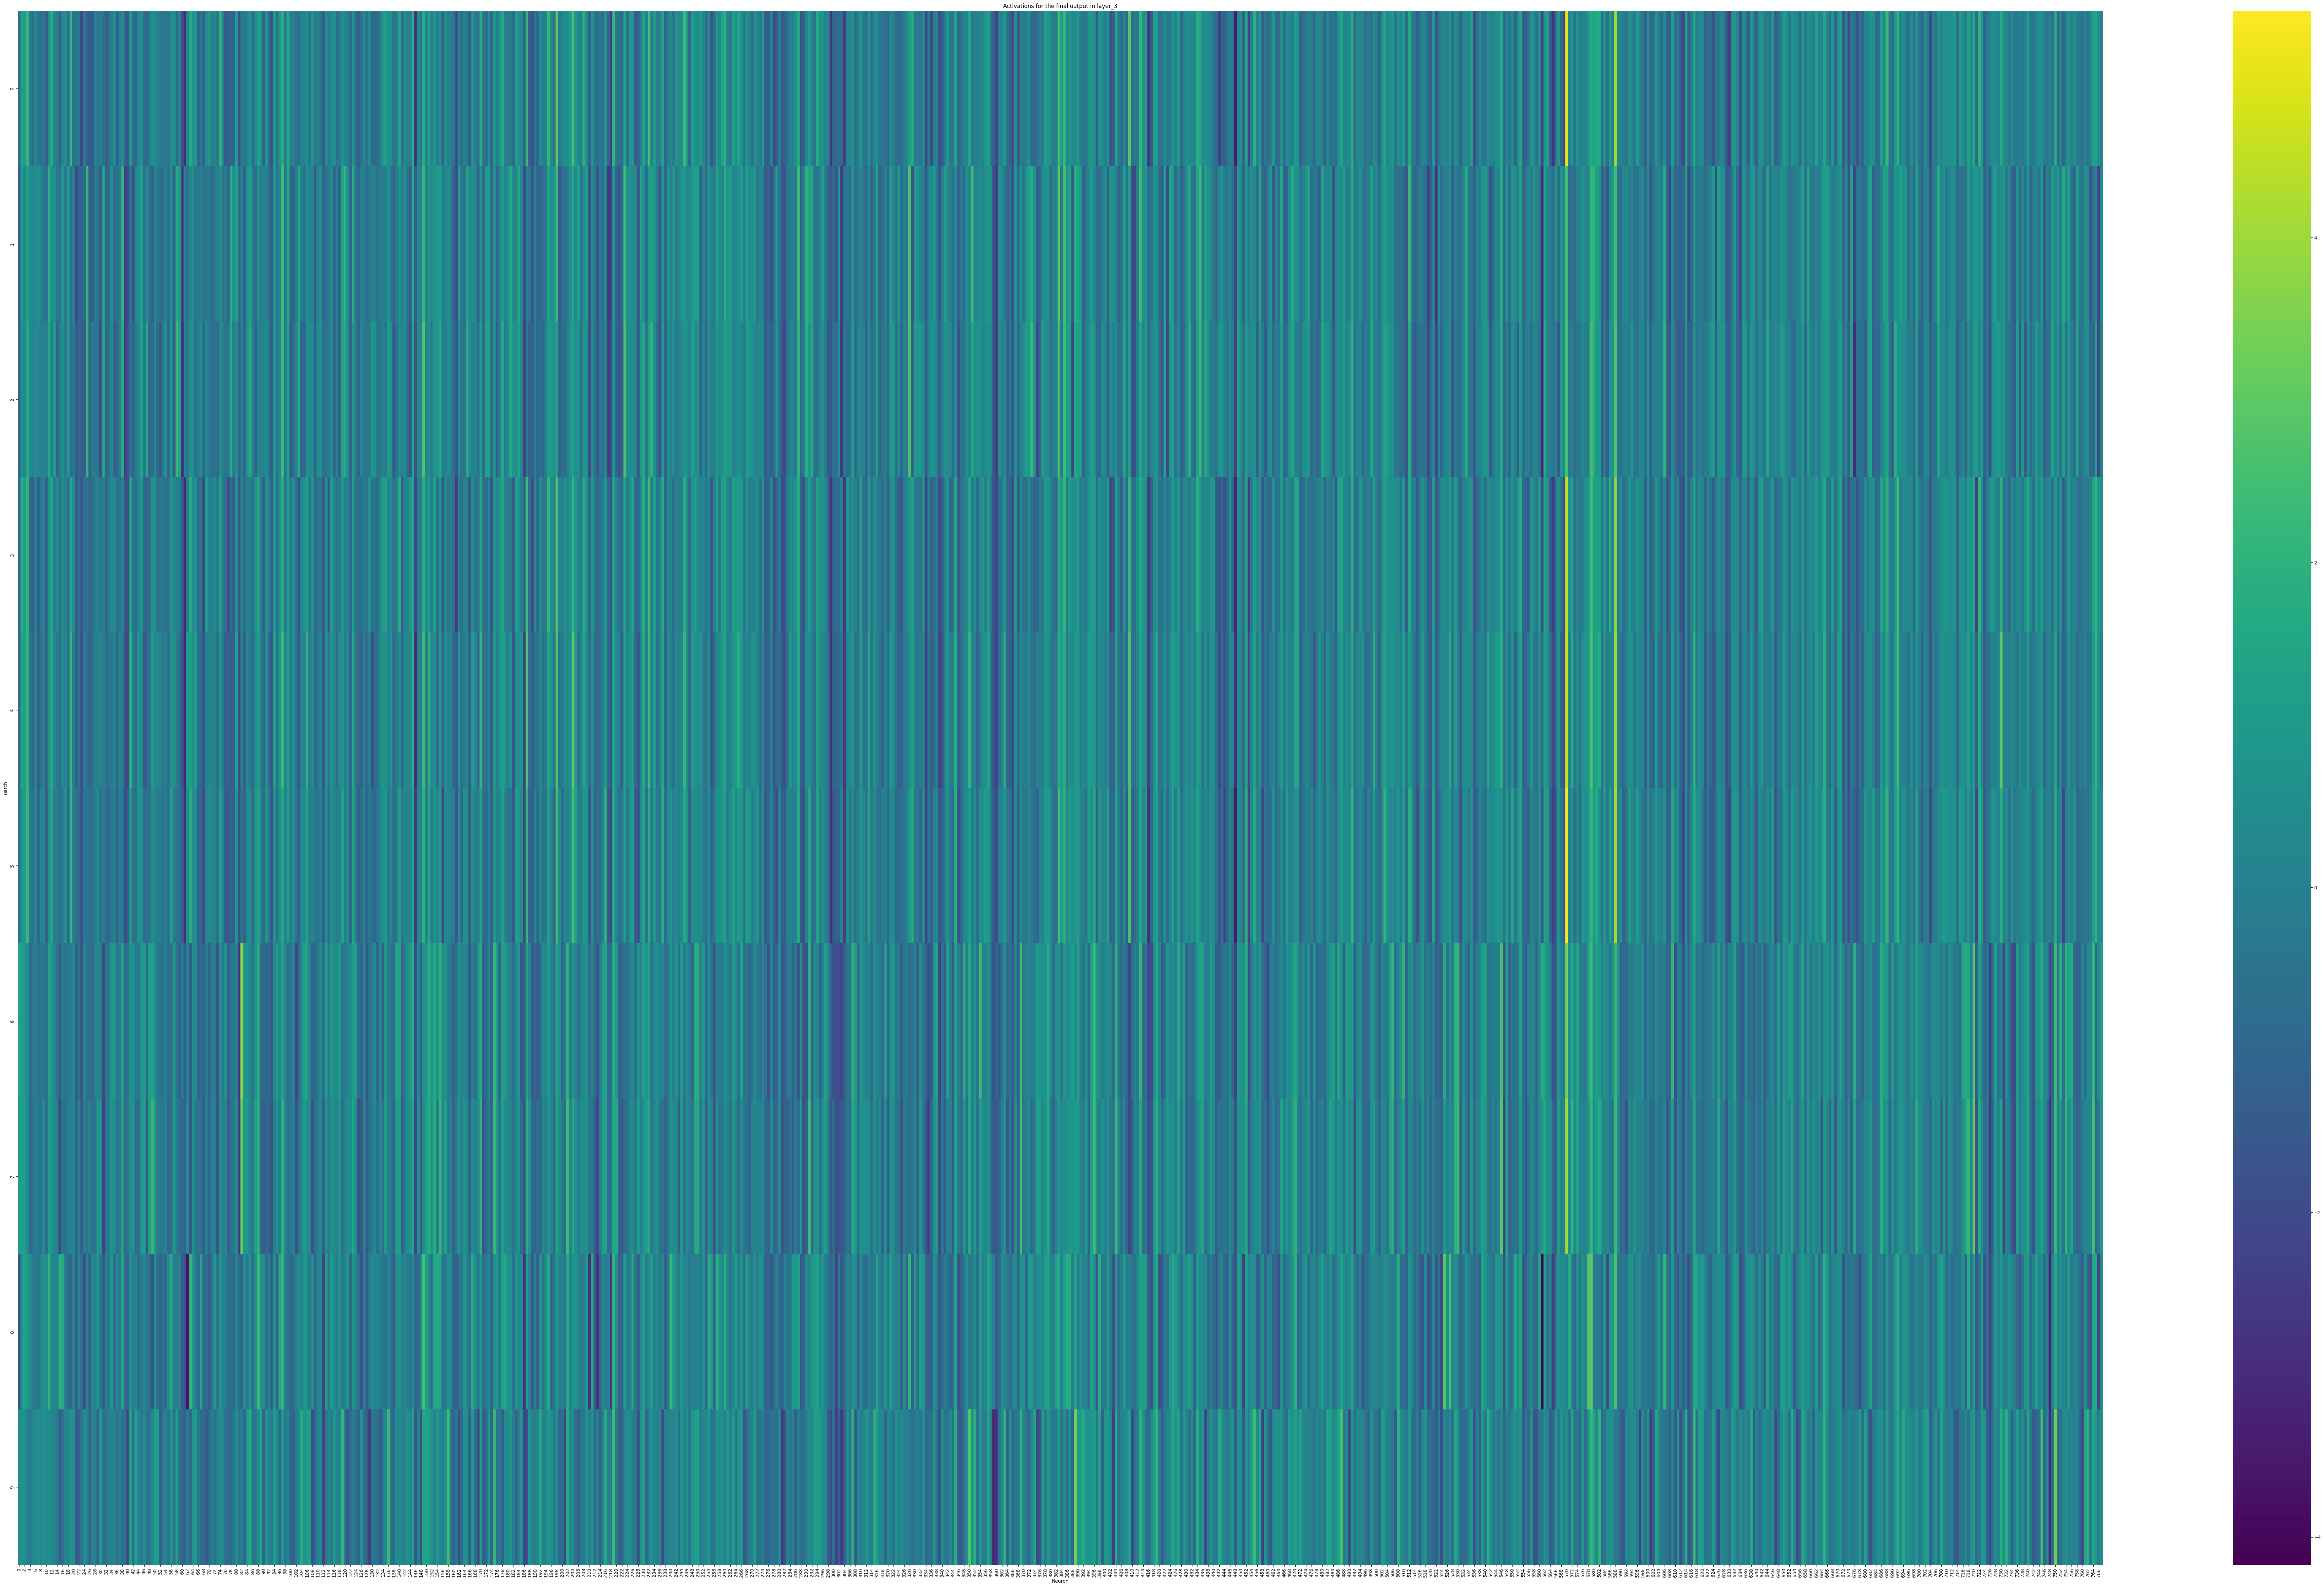

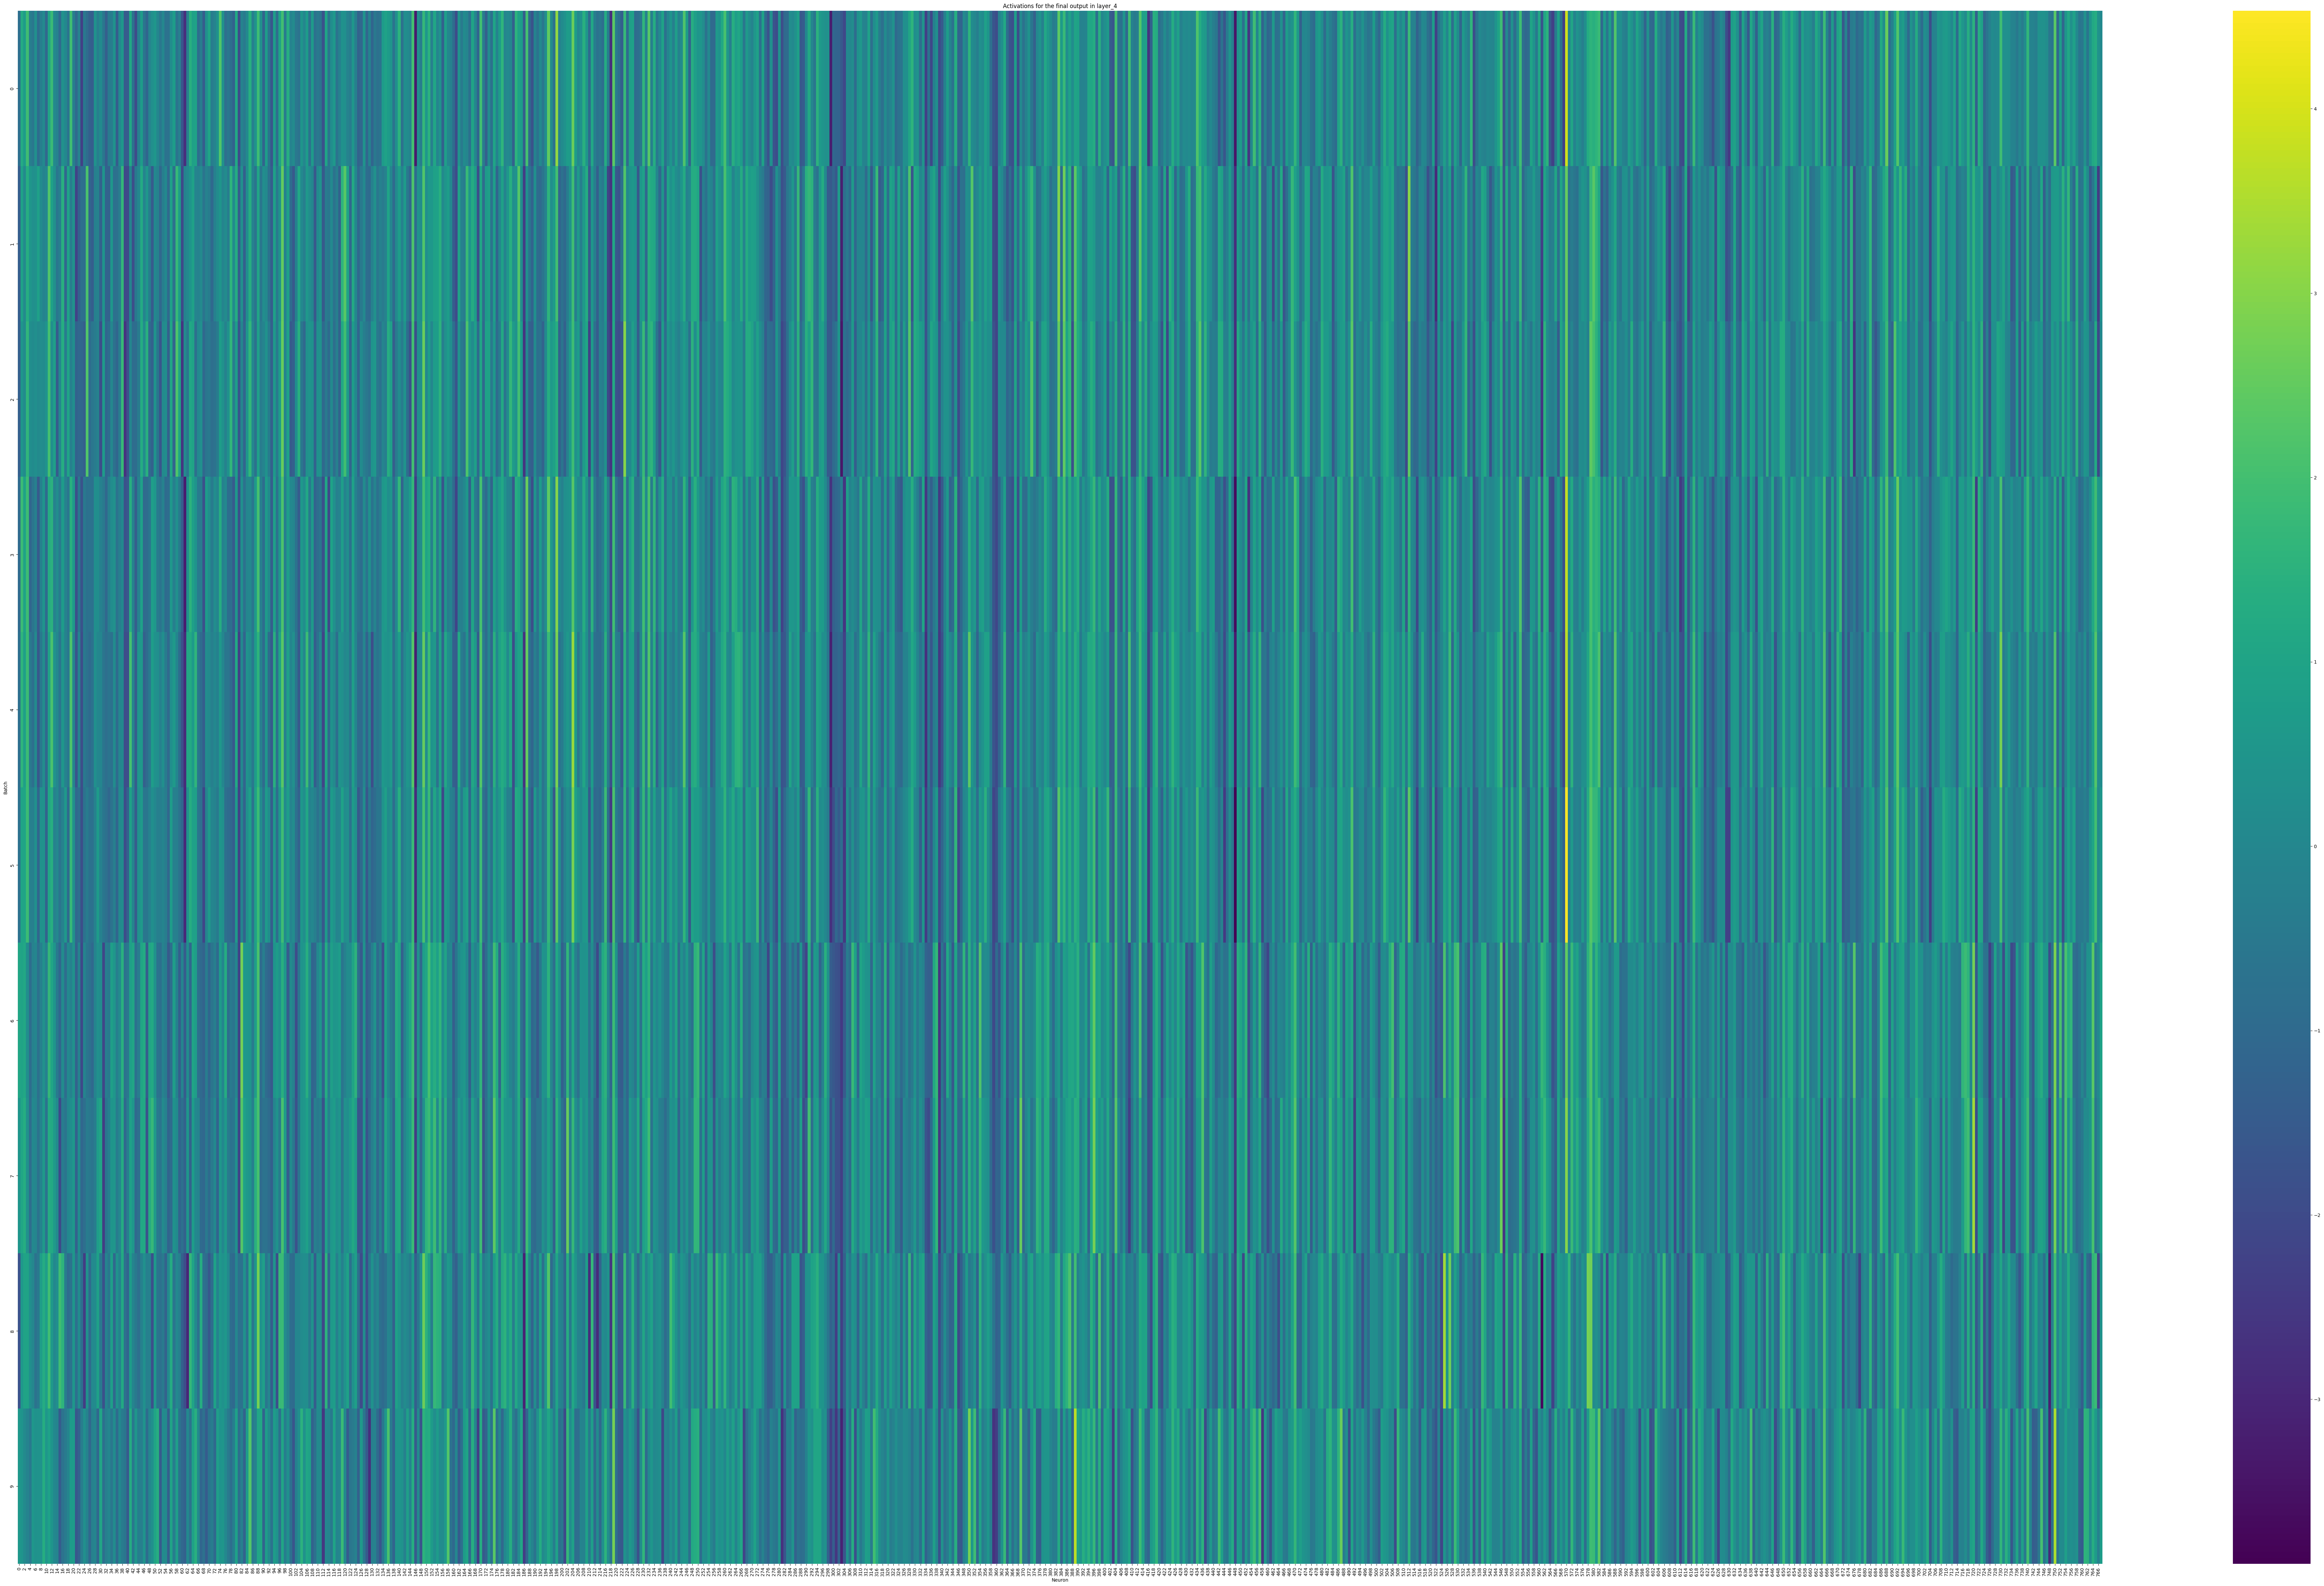

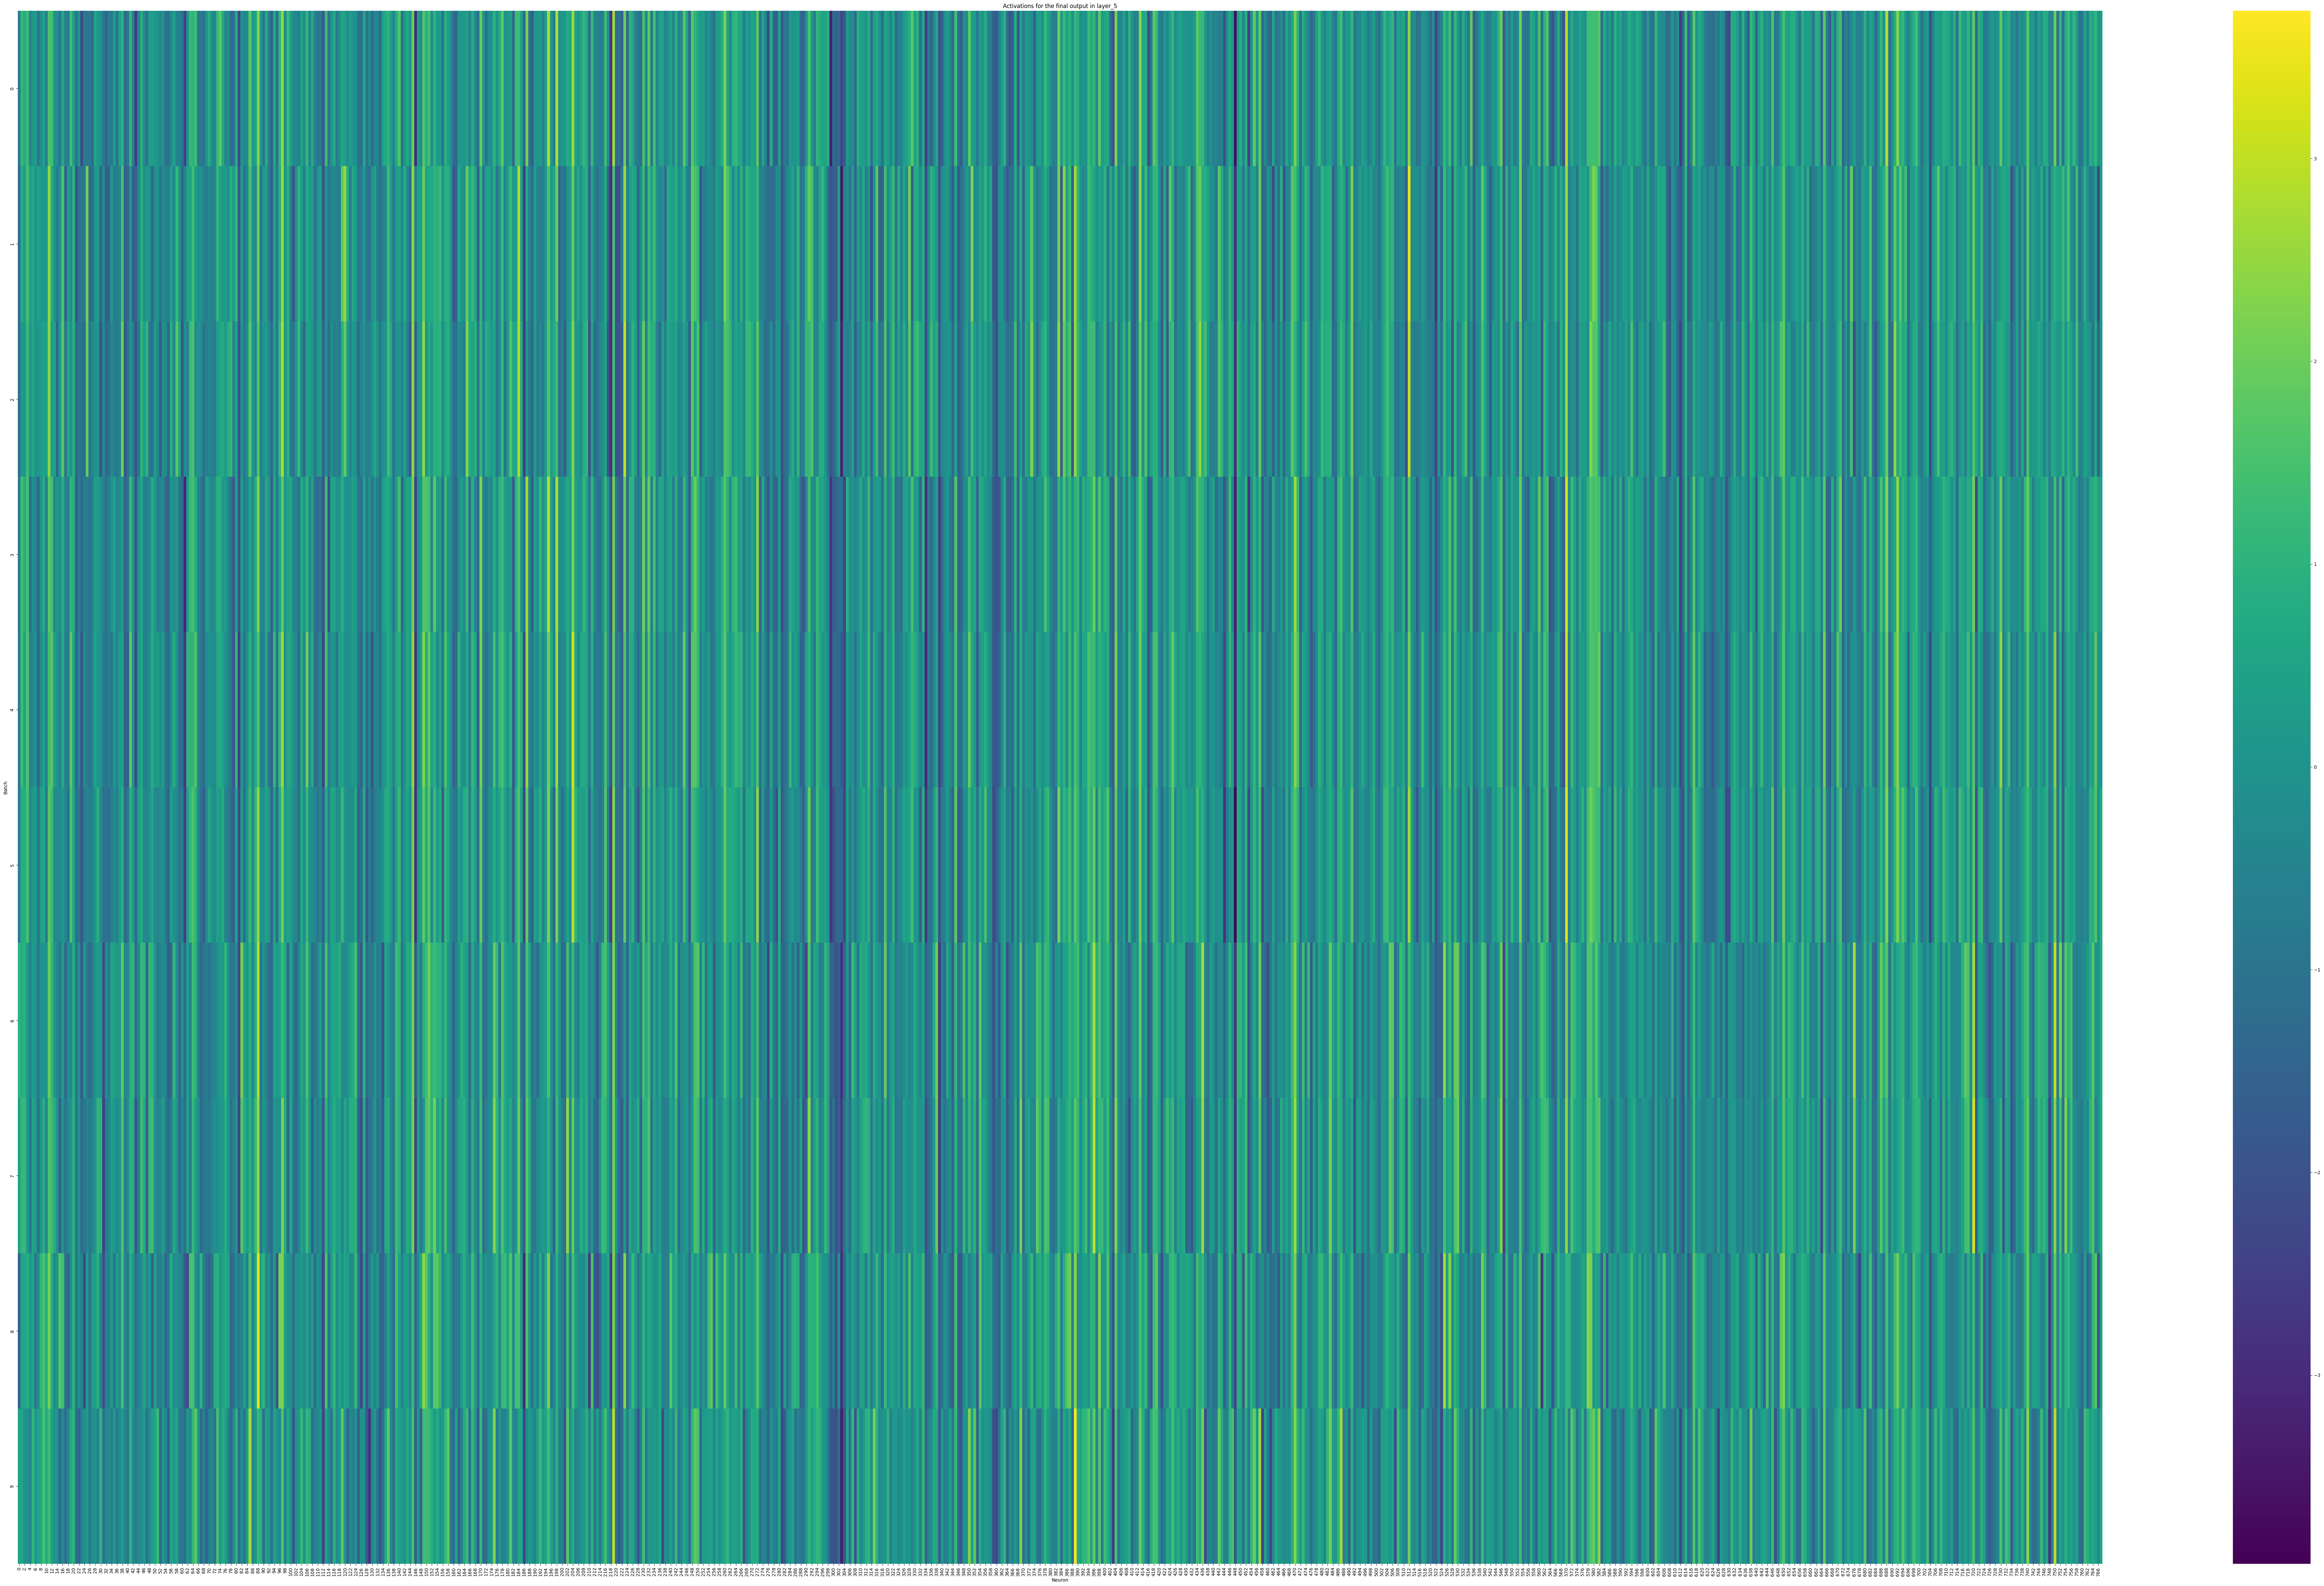

In [143]:
for layer_name, activation in activations_decoder.items():
    count = 0
    for i in activation:
        if count == 10:
            plt.figure(figsize=(100, 60))
            sns.heatmap(i.squeeze().to("cpu").numpy(), cmap='viridis')
            plt.title(f'Activations for the final output in {layer_name}')
            plt.xlabel('Neuron')
            plt.ylabel('Batch')
            plt.show()
        count+=1